## Prediction of Housing Prices in the US

By He,X.

The time series analysis will be performed to explore median housing value at each zip code between 1997 and 2021 and find out which three zip codes would provide the best investment opportunity based on 1 year and 5 year return on investment (ROI). Data provided by Zillow Home Value Index (ZHVI) only includes records of 45 states in the US. 

In [1]:
## Referenced MILLER (2015) and BROWNLEE (2016)
## Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from pandas import DataFrame
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from prophet import Prophet

In [2]:
# The data was Zillow Home Value Index (ZHVI) from single family home by zip code
zhvi = pd.read_csv('http://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_month.csv ', header=0)
  
#zhvi = zhvi.sort_index()
print(zhvi.head())
print(zhvi.shape)
print(zhvi.tail())

   RegionID  SizeRank  RegionName RegionType StateName State          City  \
0     61148         0        8701        zip        NJ    NJ      Lakewood   
1     91982         1       77494        zip        TX    TX          Katy   
2     91940         2       77449        zip        TX    TX          Katy   
3     62080         3       11368        zip        NY    NY      New York   
4     92593         4       78660        zip        TX    TX  Pflugerville   

                                   Metro        CountyName     1996-02-29  \
0  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  133406.450904   
1   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  182889.205724   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  111389.390383   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  191023.600700   
4       Austin-Round Rock-Georgetown, TX     Travis County  176706.426846   

   ...     2022-07-31     2022-08-31     2022-09-30     2022-10-31  

In [3]:
#check how many null values are in the data set
zhvi.isnull().sum()

RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName       0
             ... 
2022-12-31      0
2023-01-31    415
2023-02-28     15
2023-03-31      0
2023-04-30      2
Length: 336, dtype: int64

In [4]:
#remove rows that contain any null value in housing value columns
column_names = zhvi.columns
zhvi = zhvi.dropna(subset= column_names[9:], axis=0)
#zhvi = zhvi.dropna(axis=0)

In [5]:
#check the records after removing null values
print(zhvi.shape)

print('Number of Metro Area: ', len(set(zhvi['Metro'])))
print('Number of State: ', len(set(zhvi['State'])))
print('Number of City: ', len(set(zhvi['City'])))

(13080, 336)
Number of Metro Area:  533
Number of State:  45
Number of City:  6872


In [6]:
#check the names of states
print('ordered_state_names: \n', sorted(set(zhvi['State'])))

ordered_state_names: 
 ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV']


In [7]:
#check the names of metro areas
print('ordered_metro_names: \n', set(zhvi['Metro']))

ordered_metro_names: 
 {nan, 'Barre, VT', 'Crossville, TN', 'El Paso, TX', 'California-Lexington Park, MD', 'Charlotte-Concord-Gastonia, NC-SC', 'Richmond, VA', 'Columbus, GA-AL', 'Columbus, OH', 'Naples-Marco Island, FL', 'Jesup, GA', 'Goldsboro, NC', 'Wilmington, OH', 'Marshalltown, IA', 'Brookings, OR', 'San Jose-Sunnyvale-Santa Clara, CA', 'Monroe, LA', 'Erie, PA', 'Cumberland, MD-WV', 'Greeneville, TN', 'Burlington-South Burlington, VT', 'Easton, MD', 'Plattsburgh, NY', 'Coshocton, OH', 'Bellingham, WA', 'Orlando-Kissimmee-Sanford, FL', 'Virginia Beach-Norfolk-Newport News, VA-NC', 'Clewiston, FL', 'Jonesboro, AR', 'Texarkana, TX-AR', 'Laconia, NH', 'Tullahoma-Manchester, TN', 'Bennington, VT', 'North Port-Sarasota-Bradenton, FL', 'Bloomsburg-Berwick, PA', 'Miami, OK', 'Sevierville, TN', 'New Haven-Milford, CT', 'Olympia-Lacey-Tumwater, WA', 'Charlottesville, VA', 'Batesville, AR', 'Homosassa Springs, FL', 'Fresno, CA', 'Walla Walla, WA', 'Wooster, OH', 'Summerville, GA', 'Winston

In [8]:
#prepare alldata that only includes columns we need
zhvi = zhvi.drop(['RegionID', 'RegionType', 'StateName', 'CountyName'], axis=1)

print(zhvi)

       SizeRank  RegionName State          City  \
0             0        8701    NJ      Lakewood   
1             1       77494    TX          Katy   
2             2       77449    TX          Katy   
4             4       78660    TX  Pflugerville   
5             5       11385    NY      New York   
...         ...         ...   ...           ...   
29515     39809       26544    WV    Maidsville   
29518     39809       95419    CA   Camp Meeker   
29519     39809       14415    NY       Bellona   
29524     39809        2575    MA  West Tisbury   
29527     39809       22722    VA       Haywood   

                                              Metro     1996-02-29  \
0             New York-Newark-Jersey City, NY-NJ-PA  133406.450904   
1              Houston-The Woodlands-Sugar Land, TX  182889.205724   
2              Houston-The Woodlands-Sugar Land, TX  111389.390383   
4                  Austin-Round Rock-Georgetown, TX  176706.426846   
5             New York-Newark-Jersey 

### Overall Data Exploration

In [11]:
#convert alldata to a new data frame where the record for each month became a row
final_df = zhvi.melt(id_vars=['SizeRank', 'RegionName','State', 'City', 'Metro',], 
        var_name="Date", 
        value_name="Value")

print(final_df)

         SizeRank  RegionName State          City  \
0               0        8701    NJ      Lakewood   
1               1       77494    TX          Katy   
2               2       77449    TX          Katy   
3               4       78660    TX  Pflugerville   
4               5       11385    NY      New York   
...           ...         ...   ...           ...   
4277155     39809       26544    WV    Maidsville   
4277156     39809       95419    CA   Camp Meeker   
4277157     39809       14415    NY       Bellona   
4277158     39809        2575    MA  West Tisbury   
4277159     39809       22722    VA       Haywood   

                                                Metro        Date  \
0               New York-Newark-Jersey City, NY-NJ-PA  1996-02-29   
1                Houston-The Woodlands-Sugar Land, TX  1996-02-29   
2                Houston-The Woodlands-Sugar Land, TX  1996-02-29   
3                    Austin-Round Rock-Georgetown, TX  1996-02-29   
4               Ne

In [12]:
#Add Year column to only save the year of each record
final_df['Year'] = final_df['Date'].str[:4]
final_df['Year'] = final_df['Year'].apply(pd.to_numeric)

#only use data from 1997 through 2022
final_df = final_df[(final_df['Year'] > 1996) & (final_df['Year'] < 2023) ]
final_df = final_df.reset_index(drop=True)

#### Explore Entire Housing Price Data

[]

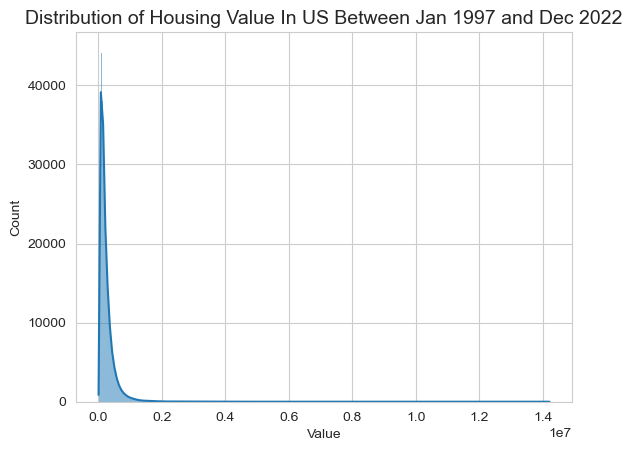

In [14]:
#exploratory data analysis: plot the distribution of SchoolPay
sb.set_style('whitegrid')
sb.histplot(x=final_df['Value'],
           kde = True)
plt.title('Distribution of Housing Value In US Between Jan 1997 and Dec 2022', fontdict = {'fontsize': 14})
plt.plot()

In [13]:
print(final_df['Value'].describe())

count    2.730936e+06
mean     2.870012e+05
std      3.201565e+05
min      7.618906e+03
25%      1.220930e+05
50%      1.999880e+05
75%      3.406603e+05
max      1.283025e+07
Name: Value, dtype: float64


[]

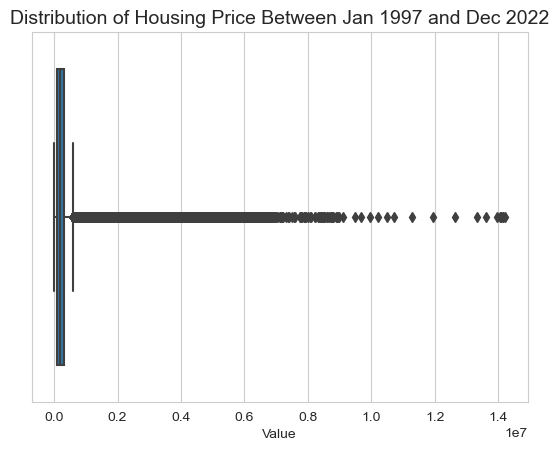

In [15]:
#create a box plot
sb.boxplot(x = final_df['Value'])
plt.title('Distribution of Housing Price Between Jan 1997 and Dec 2022', fontdict = {'fontsize': 14})
plt.plot()

#### Develop time series plots for the following Arkansas metro areas: Hot Springs, Little Rock, Fayetteville, Searcy
• Present all values from 1997 to present
• Average at the metro area level

In [16]:
#Create subset of data that only includes the above mentioned four Arkansas metro areas.
AR_df = final_df.loc[final_df['Metro'].isin(['Hot Springs, AR', 'Little Rock-North Little Rock-Conway, AR', 'Fayetteville-Springdale-Rogers, AR', 'Searcy, AR'])]
print(AR_df.shape)
print(AR_df)

(27768, 8)
         SizeRank  RegionName State          City  \
564           690       72764    AR    Springdale   
871          1060       72701    AR  Fayetteville   
1140         1419       72762    AR    Springdale   
1236         1539       72758    AR        Rogers   
1259         1575       72712    AR   Bentonville   
...           ...         ...   ...           ...   
4079298     21944       72717    AR      Canehill   
4079602     23357       72025    AR          Casa   
4079649     23575       72773    AR        Wesley   
4080081     25903       72047    AR         Enola   
4080194     26709       72742    AR      Kingston   

                                            Metro        Date          Value  \
564            Fayetteville-Springdale-Rogers, AR  1997-01-31   93628.544804   
871            Fayetteville-Springdale-Rogers, AR  1997-01-31   92295.754463   
1140           Fayetteville-Springdale-Rogers, AR  1997-01-31  114247.631847   
1236           Fayetteville-Spri

In [17]:
#remove irrelevant columns
AR_df = AR_df.iloc[: , 4:7]

In [18]:
#perform group by to get dataframe that includes the average median housing price of each Metro
grouped_AR = AR_df.groupby(['Metro','Date']).agg('mean')
grouped_AR = grouped_AR.reset_index()
print(grouped_AR)

                                   Metro        Date          Value
0     Fayetteville-Springdale-Rogers, AR  1997-01-31   83213.254687
1     Fayetteville-Springdale-Rogers, AR  1997-02-28   83058.999834
2     Fayetteville-Springdale-Rogers, AR  1997-03-31   83728.624733
3     Fayetteville-Springdale-Rogers, AR  1997-04-30   84804.799230
4     Fayetteville-Springdale-Rogers, AR  1997-05-31   85380.433934
...                                  ...         ...            ...
1243                          Searcy, AR  2022-08-31  166520.262712
1244                          Searcy, AR  2022-09-30  165208.837644
1245                          Searcy, AR  2022-10-31  165161.666756
1246                          Searcy, AR  2022-11-30  164443.583630
1247                          Searcy, AR  2022-12-31  163918.973299

[1248 rows x 3 columns]


[]

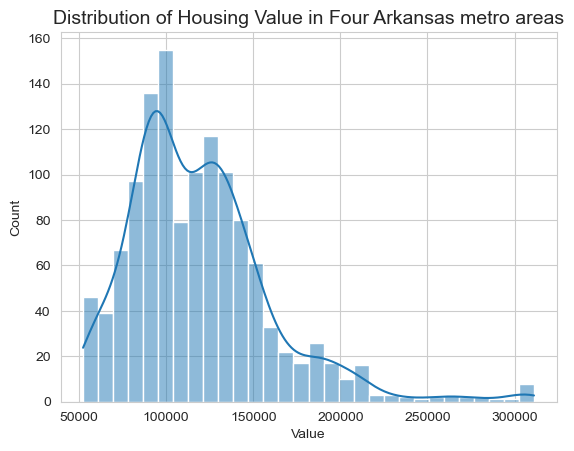

In [19]:
#exploratory data analysis: plot the distribution of housing price in four AR Metro Areas
sb.set_style('whitegrid')
sb.histplot(x=grouped_AR['Value'],
           kde = True)
plt.title('Distribution of Housing Value in Four Arkansas metro areas', fontdict = {'fontsize': 14})
plt.plot()

[]

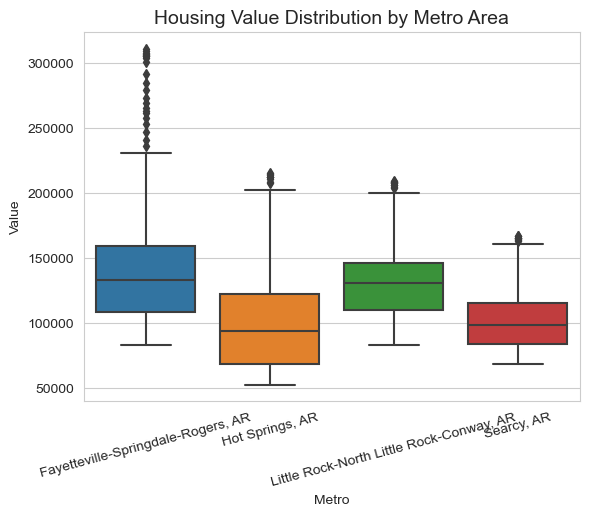

In [20]:
# review distributions of housing prices in each area
sb.boxplot(x = grouped_AR['Metro'],
            y = grouped_AR['Value'])
plt.title('Housing Value Distribution by Metro Area', fontdict = {'fontsize': 14})
plt.xticks(rotation = 15)
plt.plot()

In [21]:
#prepare data for time series analysis
final_AR = grouped_AR[grouped_AR['Metro'] == 'Fayetteville-Springdale-Rogers, AR'][['Date']]
final_AR['Fayetteville'] = grouped_AR[grouped_AR['Metro'] == 'Fayetteville-Springdale-Rogers, AR'][['Value']]
final_AR['Hot_Springs'] = grouped_AR[grouped_AR['Metro'] == 'Hot Springs, AR'][['Value']].reset_index(drop=True)
final_AR['Little_Rock'] = grouped_AR[grouped_AR['Metro'] == 'Little Rock-North Little Rock-Conway, AR'][['Value']].reset_index(drop=True)
final_AR['Searcy'] = grouped_AR[grouped_AR['Metro'] == 'Searcy, AR'][['Value']].reset_index(drop=True)

#set Date column as index
final_AR = final_AR.set_index('Date')
print(final_AR)

             Fayetteville    Hot_Springs    Little_Rock         Searcy
Date                                                                  
1997-01-31   83213.254687   52303.708821   83083.573430   68444.261332
1997-02-28   83058.999834   53497.113550   83024.323729   68306.566936
1997-03-31   83728.624733   53270.389964   83232.591901   68654.511242
1997-04-30   84804.799230   53165.972597   83683.715137   68765.287114
1997-05-31   85380.433934   53777.017152   84387.446571   69435.592436
...                   ...            ...            ...            ...
2022-08-31  307511.855713  214111.212253  208445.707566  166520.262712
2022-09-30  305606.192490  212423.717309  208232.789672  165208.837644
2022-10-31  306264.831518  212018.772412  207746.931744  165161.666756
2022-11-30  305319.687975  210995.901360  206097.800449  164443.583630
2022-12-31  303923.418412  208275.702280  204500.591656  163918.973299

[312 rows x 4 columns]


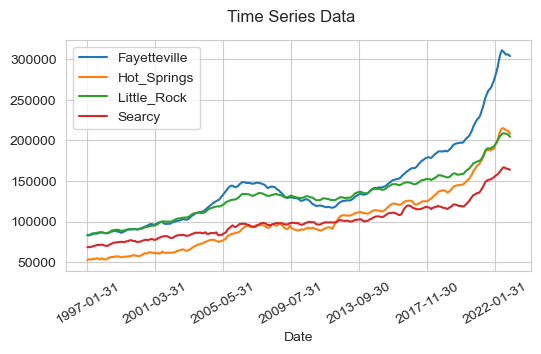

In [22]:
# Line plots of time series
sb.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
final_AR.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

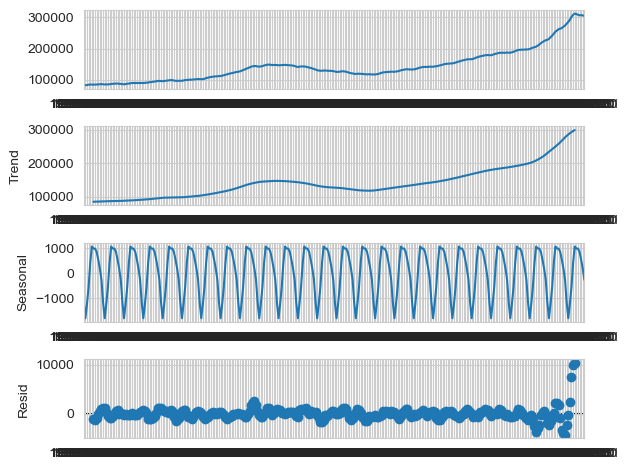

In [23]:
# Plot decomposed the series data
decomp = seasonal_decompose(final_AR[['Fayetteville']], period = 12)
decomp.plot()
plt.show()

In [24]:
# define a function to check stationary for any series
def check_stationary (df, name):
    series = df[[name]]
    result = adfuller(series,autolag='AIC')
    return('p-value: %f' % result[1])

In [25]:
# check stationarity for each series
print('Result for Fayetteville: ', check_stationary(final_AR,'Fayetteville'))
print('Result for Hot_Springs: ',check_stationary(final_AR,'Hot_Springs'))
print('Result for Little_Rock: ',check_stationary(final_AR,'Little_Rock'))
print('Result for Searcy: ',check_stationary(final_AR,'Searcy'))

Result for Fayetteville:  p-value: 0.965922
Result for Hot_Springs:  p-value: 0.997758
Result for Little_Rock:  p-value: 0.956257
Result for Searcy:  p-value: 0.994011


In [26]:
# define a function to check stationary after first order differencing
def check_stationary_diff1 (df, name):
    series = df[[name]]
    series_diff1 = series.diff()
    series_diff1.dropna(inplace=True)
    result = adfuller(series_diff1,autolag='AIC')
    return('p-value: %f' % result[1])

In [27]:
# check stationarity for each series
print('Result for Fayetteville: ', check_stationary_diff1(final_AR,'Fayetteville'))
print('Result for Hot_Springs: ',check_stationary_diff1(final_AR,'Hot_Springs'))
print('Result for Little_Rock: ',check_stationary_diff1(final_AR,'Little_Rock'))
print('Result for Searcy: ',check_stationary_diff1(final_AR,'Searcy'))

Result for Fayetteville:  p-value: 0.020834
Result for Hot_Springs:  p-value: 0.036726
Result for Little_Rock:  p-value: 0.226899
Result for Searcy:  p-value: 0.046253


In [28]:
print(final_AR.index)

Index(['1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30', '1997-05-31',
       '1997-06-30', '1997-07-31', '1997-08-31', '1997-09-30', '1997-10-31',
       ...
       '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'],
      dtype='object', name='Date', length=312)


In [29]:
#Create a dataframe that includes series with first order differencing
final_AR_diff1 = pd.DataFrame()
final_AR_diff1['Fayetteville_diff1'] = final_AR['Fayetteville'].diff()
final_AR_diff1['Hot_Springs_diff1'] = final_AR['Hot_Springs'].diff()
final_AR_diff1['Little_Rock_diff1'] = final_AR['Little_Rock'].diff()
final_AR_diff1['Searcy_diff1'] = final_AR['Searcy'].diff()
final_AR_diff1 = final_AR_diff1.dropna(axis=0)

In [30]:
print(final_AR_diff1)

            Fayetteville_diff1  Hot_Springs_diff1  Little_Rock_diff1  \
Date                                                                   
1997-02-28         -154.254853        1193.404728         -59.249701   
1997-03-31          669.624899        -226.723585         208.268172   
1997-04-30         1076.174497        -104.417367         451.123236   
1997-05-31          575.634704         611.044554         703.731434   
1997-06-30         -181.901428          -8.504357         734.604565   
...                        ...                ...                ...   
2022-08-31        -2053.390273        -817.661483        -473.118253   
2022-09-30        -1905.663223       -1687.494944        -212.917894   
2022-10-31          658.639028        -404.944898        -485.857928   
2022-11-30         -945.143543       -1022.871052       -1649.131296   
2022-12-31        -1396.269563       -2720.199080       -1597.208792   

            Searcy_diff1  
Date                      
1997-02-2

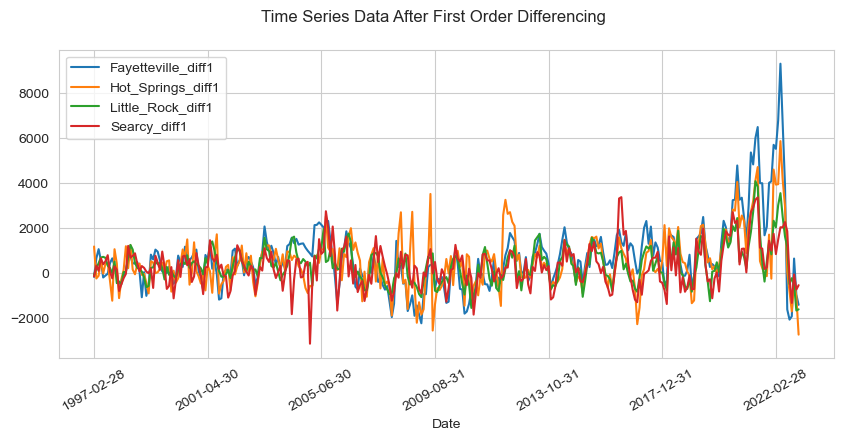

In [31]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle('Time Series Data After First Order Differencing')
final_AR_diff1.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

In [32]:
#First order differencing didn't remove non-stationary for every time series

In [33]:
# Check stationary after second order differencing
def check_stationary_diff2 (df, name):
    series = df[[name]]
    series_diff2 = series.diff().diff()
    series_diff2.dropna(inplace=True)
    result = adfuller(series_diff2,autolag='AIC')
    return('p-value: %f' % result[1])

In [34]:
print('Result for Fayetteville: ', check_stationary_diff2(final_AR,'Fayetteville'))
print('Result for Hot_Springs: ',check_stationary_diff2(final_AR,'Hot_Springs'))
print('Result for Little_Rock: ',check_stationary_diff2(final_AR,'Little_Rock'))
print('Result for Searcy: ',check_stationary_diff2(final_AR,'Searcy'))

Result for Fayetteville:  p-value: 0.000028
Result for Hot_Springs:  p-value: 0.000000
Result for Little_Rock:  p-value: 0.000000
Result for Searcy:  p-value: 0.000000


In [35]:
#Create a dataframe that includes series with second order differencing
final_AR_diff2 = pd.DataFrame()
final_AR_diff2['Fayetteville_diff2'] = final_AR['Fayetteville'].diff().diff()
final_AR_diff2['Hot_Springs_diff2'] = final_AR['Hot_Springs'].diff().diff()
final_AR_diff2['Little_Rock_diff2'] = final_AR['Little_Rock'].diff().diff()
final_AR_diff2['Searcy_diff2'] = final_AR['Searcy'].diff().diff()
final_AR_diff2 = final_AR_diff2.dropna(axis=0)

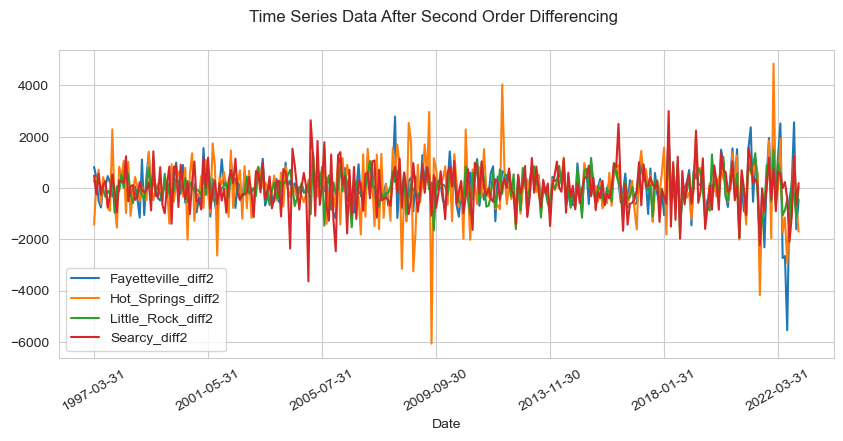

In [36]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle('Time Series Data After Second Order Differencing')
final_AR_diff2.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

In [37]:
#Second order differencing removed non-stationary for all regions tested above

In [38]:
#ask jupyter notebook to print graphs inline
%matplotlib inline
rcParams['figure.figsize'] = 8,4

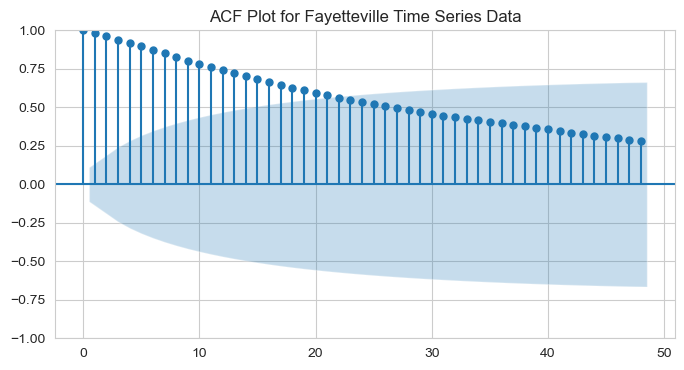

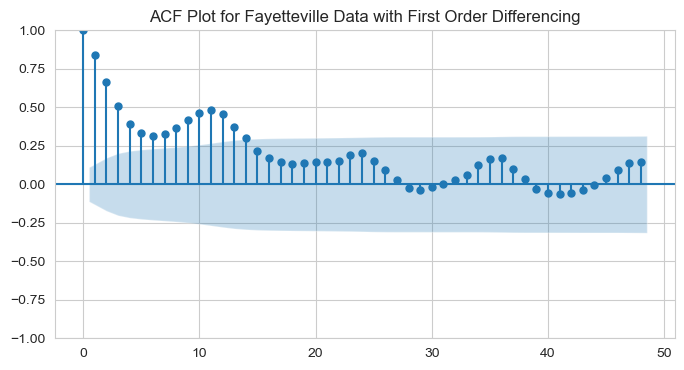

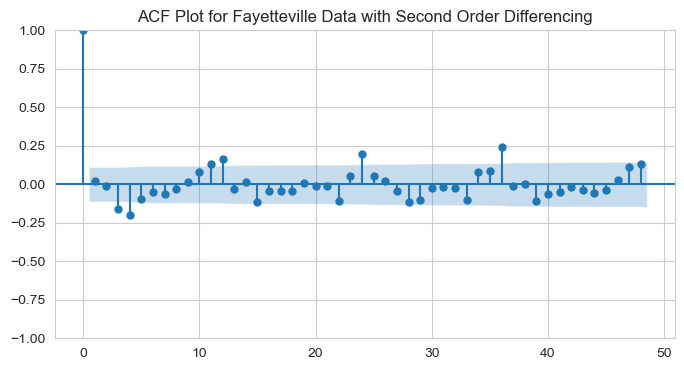

In [39]:
# Look at ACF plots in Fayetteville area
plot_acf(final_AR[['Fayetteville']], lags=48)
plt.title("ACF Plot for Fayetteville Time Series Data")
plt.show()

plot_acf(final_AR_diff1[['Fayetteville_diff1']], lags=48)
plt.title("ACF Plot for Fayetteville Data with First Order Differencing")
plt.show()

plot_acf(final_AR_diff2[['Fayetteville_diff2']], lags=48)
plt.title("ACF Plot for Fayetteville Data with Second Order Differencing")
plt.show()

#### Explore CPI Data

In [73]:
#Read 1997-2022 CPI data
cpi = pd.read_csv('cpi_record.csv', header=0)
print(cpi)

     year period    value
0    2022    M12  296.797
1    2022    M11  297.711
2    2022    M10  298.012
3    2022    M09  296.808
4    2022    M08  296.171
..    ...    ...      ...
307  1997    M05  160.100
308  1997    M04  160.200
309  1997    M03  160.000
310  1997    M02  159.600
311  1997    M01  159.100

[312 rows x 3 columns]


In [74]:
#check how many null values are in the data set
cpi.isnull().sum()

year      0
period    0
value     0
dtype: int64

In [75]:
#change data format and add ds column for yyyy-mm-dd
cpi['period']= cpi['period'].str[-2:]
cpi['ds'] = cpi['year'].astype(str) +"-"+ cpi["period"] +"-01"
cpi = cpi.sort_values('ds')
print(cpi)

     year period    value          ds
311  1997     01  159.100  1997-01-01
310  1997     02  159.600  1997-02-01
309  1997     03  160.000  1997-03-01
308  1997     04  160.200  1997-04-01
307  1997     05  160.100  1997-05-01
..    ...    ...      ...         ...
4    2022     08  296.171  2022-08-01
3    2022     09  296.808  2022-09-01
2    2022     10  298.012  2022-10-01
1    2022     11  297.711  2022-11-01
0    2022     12  296.797  2022-12-01

[312 rows x 4 columns]


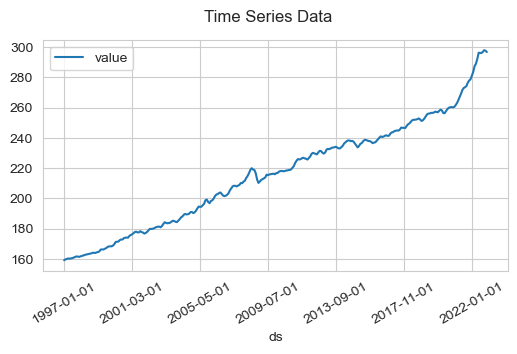

In [76]:
# Line plots of time series
cpi_series = cpi[['ds','value']]
cpi_series = cpi_series.set_index('ds')


fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
cpi_series.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

### Model and Analysis

#### Build Prophet Model Using Housing Price Data

In [47]:
# extract data before 2022 for predictions
model_data = final_df[final_df['Year'] < 2022]

# Rename columns for prophet
model_data = model_data.rename(columns={"Value": "y", "Date": "ds"})
model_data = model_data[['ds','y','RegionName']]
model_data['ds'] = model_data['ds'].str[:7]
model_data['ds'] = model_data['ds'].astype(str) +"-01"
print(model_data.head())

           ds              y  RegionName
0  1997-01-01  132679.641460        8701
1  1997-01-01  190056.714417       77494
2  1997-01-01  110834.182195       77449
3  1997-01-01  177798.427926       78660
4  1997-01-01  175560.749897       11385


In [48]:
# Get list of RegionName names
ordered_RegionNames = (sorted(set(model_data['RegionName'])))
#print('ordered_RegionNames: ', ordered_RegionNames)
print('Total number of unique zip codes: ', len(ordered_RegionNames))

Total number of unique zip codes:  13080


In [49]:
#Create predictions for each month in 2022 for each Zip Code 
region_list = ordered_RegionNames
predictions = pd.DataFrame(columns= ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'RegionName'])

# run forecasts into 12 months in 2022 for each zip code, and combine data for each zip code to one data set
for region in region_list:
    region_series = model_data.loc[model_data['RegionName'] == region]
    region_series = region_series[['y','ds']]
    
    # MODEL using Prophet - Set the uncertainty interval to 95% (the Prophet default is 80%)
    model = Prophet(interval_width=0.95)
    # fit the model
    model = model.fit(region_series)
    
    #model = fit.prophet(model, df = region_series)
    future_date = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future_date)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    #print(forecast)
    forecast['RegionName'] = region

    #append data for current zip code to final prediction result data set
    predictions = pd.concat([predictions,forecast])


18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
18:07:28 - cmdstanpy - INFO - Chain [1] start processing
18:07:28 - cmdstanpy - INFO - Chain [1] done processing
18:07:28 - cmdstanpy - INFO - Chain [1] start processing
18:07:28 - cmdstanpy - INFO - Chain [1] done processing
18:07:28 - cmdstanpy - INFO - Chain [1] start processing
18:07:28 - cmdstanpy - INFO - Chain [1] done processing
18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1]

18:07:48 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] 

18:08:10 - cmdstanpy - INFO - Chain [1] done processing
18:08:10 - cmdstanpy - INFO - Chain [1] start processing
18:08:10 - cmdstanpy - INFO - Chain [1] done processing
18:08:10 - cmdstanpy - INFO - Chain [1] start processing
18:08:10 - cmdstanpy - INFO - Chain [1] done processing
18:08:11 - cmdstanpy - INFO - Chain [1] start processing
18:08:11 - cmdstanpy - INFO - Chain [1] done processing
18:08:11 - cmdstanpy - INFO - Chain [1] start processing
18:08:11 - cmdstanpy - INFO - Chain [1] done processing
18:08:11 - cmdstanpy - INFO - Chain [1] start processing
18:08:11 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] 

18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] 

18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] 

18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:24 - cmdstanpy - INFO - Chain [1] done processing
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
18:09:24 - cmdstanpy - INFO - Chain [1] done processing
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
18:09:24 - cmdstanpy - INFO - Chain [1] done processing
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
18:09:24 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] 

18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:47 - cmdstanpy - INFO - Chain [1] 

18:10:07 - cmdstanpy - INFO - Chain [1] done processing
18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] 

18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] 

18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] 

18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] 

18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] 

18:11:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:02 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - INFO - Chain [1] 

18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] 

18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] 

18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] 

18:13:32 - cmdstanpy - INFO - Chain [1] done processing
18:13:32 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
18:13:35 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing
18:13:35 - cmdstanpy - INFO - Chain [1] 

18:13:55 - cmdstanpy - INFO - Chain [1] done processing
18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
18:13:56 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1] done processing
18:13:56 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1] done processing
18:13:56 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1] done processing
18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
18:13:58 - cmdstanpy - INFO - Chain [1] 

18:14:18 - cmdstanpy - INFO - Chain [1] done processing
18:14:18 - cmdstanpy - INFO - Chain [1] start processing
18:14:18 - cmdstanpy - INFO - Chain [1] done processing
18:14:18 - cmdstanpy - INFO - Chain [1] start processing
18:14:19 - cmdstanpy - INFO - Chain [1] done processing
18:14:19 - cmdstanpy - INFO - Chain [1] start processing
18:14:19 - cmdstanpy - INFO - Chain [1] done processing
18:14:19 - cmdstanpy - INFO - Chain [1] start processing
18:14:19 - cmdstanpy - INFO - Chain [1] done processing
18:14:19 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
18:14:21 - cmdstanpy - INFO - Chain [1] 

18:14:43 - cmdstanpy - INFO - Chain [1] done processing
18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:43 - cmdstanpy - INFO - Chain [1] done processing
18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:46 - cmdstanpy - INFO - Chain [1] 

18:15:05 - cmdstanpy - INFO - Chain [1] done processing
18:15:05 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:08 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1] done processing
18:15:08 - cmdstanpy - INFO - Chain [1] 

18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
18:15:32 - cmdstanpy - INFO - Chain [1] 

18:15:52 - cmdstanpy - INFO - Chain [1] done processing
18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:53 - cmdstanpy - INFO - Chain [1] done processing
18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:53 - cmdstanpy - INFO - Chain [1] done processing
18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:53 - cmdstanpy - INFO - Chain [1] done processing
18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing
18:15:55 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing
18:15:55 - cmdstanpy - INFO - Chain [1] 

18:16:15 - cmdstanpy - INFO - Chain [1] done processing
18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
18:16:17 - cmdstanpy - INFO - Chain [1] start processing
18:16:17 - cmdstanpy - INFO - Chain [1] done processing
18:16:17 - cmdstanpy - INFO - Chain [1] start processing
18:16:18 - cmdstanpy - INFO - Chain [1] done processing
18:16:18 - cmdstanpy - INFO - Chain [1] start processing
18:16:18 - cmdstanpy - INFO - Chain [1] done processing
18:16:18 - cmdstanpy - INFO - Chain [1] start processing
18:16:18 - cmdstanpy - INFO - Chain [1] done processing
18:16:19 - cmdstanpy - INFO - Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
18:16:19 - cmdstanpy - INFO - Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
18:16:19 - cmdstanpy - INFO - Chain [1] 

18:16:41 - cmdstanpy - INFO - Chain [1] done processing
18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:41 - cmdstanpy - INFO - Chain [1] done processing
18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:41 - cmdstanpy - INFO - Chain [1] done processing
18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:43 - cmdstanpy - INFO - Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1] done processing
18:16:43 - cmdstanpy - INFO - Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1] done processing
18:16:43 - cmdstanpy - INFO - Chain [1] 

18:17:05 - cmdstanpy - INFO - Chain [1] done processing
18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
18:17:07 - cmdstanpy - INFO - Chain [1] 

18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
18:17:33 - cmdstanpy - INFO - Chain [1] 

18:17:53 - cmdstanpy - INFO - Chain [1] done processing
18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing
18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing
18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing
18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing
18:17:55 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:55 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:55 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:56 - cmdstanpy - INFO - Chain [1] 

18:18:17 - cmdstanpy - INFO - Chain [1] done processing
18:18:17 - cmdstanpy - INFO - Chain [1] start processing
18:18:17 - cmdstanpy - INFO - Chain [1] done processing
18:18:17 - cmdstanpy - INFO - Chain [1] start processing
18:18:17 - cmdstanpy - INFO - Chain [1] done processing
18:18:17 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] 

18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
18:18:42 - cmdstanpy - INFO - Chain [1] 

18:19:03 - cmdstanpy - INFO - Chain [1] done processing
18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:03 - cmdstanpy - INFO - Chain [1] done processing
18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing
18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing
18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing
18:19:05 - cmdstanpy - INFO - Chain [1] start processing
18:19:05 - cmdstanpy - INFO - Chain [1] done processing
18:19:05 - cmdstanpy - INFO - Chain [1] start processing
18:19:05 - cmdstanpy - INFO - Chain [1] done processing
18:19:05 - cmdstanpy - INFO - Chain [1] start processing
18:19:05 - cmdstanpy - INFO - Chain [1] done processing
18:19:06 - cmdstanpy - INFO - Chain [1] start processing
18:19:06 - cmdstanpy - INFO - Chain [1] done processing
18:19:06 - cmdstanpy - INFO - Chain [1] 

18:19:26 - cmdstanpy - INFO - Chain [1] done processing
18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing
18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing
18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing
18:19:27 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing
18:19:27 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing
18:19:27 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
18:19:28 - cmdstanpy - INFO - Chain [1] 

18:19:49 - cmdstanpy - INFO - Chain [1] done processing
18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
18:19:50 - cmdstanpy - INFO - Chain [1] start processing
18:19:50 - cmdstanpy - INFO - Chain [1] done processing
18:19:50 - cmdstanpy - INFO - Chain [1] start processing
18:19:50 - cmdstanpy - INFO - Chain [1] done processing
18:19:50 - cmdstanpy - INFO - Chain [1] start processing
18:19:50 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] 

18:20:12 - cmdstanpy - INFO - Chain [1] done processing
18:20:12 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing
18:20:12 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing
18:20:12 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing
18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing
18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing
18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing
18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
18:20:14 - cmdstanpy - INFO - Chain [1] 

18:20:35 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing
18:20:38 - cmdstanpy - INFO - Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing
18:20:38 - cmdstanpy - INFO - Chain [1] 

18:20:58 - cmdstanpy - INFO - Chain [1] done processing
18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1] done processing
18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing
18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing
18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing
18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
18:21:01 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing
18:21:01 - cmdstanpy - INFO - Chain [1] 

18:21:22 - cmdstanpy - INFO - Chain [1] done processing
18:21:22 - cmdstanpy - INFO - Chain [1] start processing
18:21:22 - cmdstanpy - INFO - Chain [1] done processing
18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:25 - cmdstanpy - INFO - Chain [1] done processing
18:21:25 - cmdstanpy - INFO - Chain [1] 

18:21:45 - cmdstanpy - INFO - Chain [1] done processing
18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:45 - cmdstanpy - INFO - Chain [1] done processing
18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:46 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:46 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:46 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:48 - cmdstanpy - INFO - Chain [1] 

18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:11 - cmdstanpy - INFO - Chain [1] 

18:22:40 - cmdstanpy - INFO - Chain [1] done processing
18:22:40 - cmdstanpy - INFO - Chain [1] start processing
18:22:40 - cmdstanpy - INFO - Chain [1] done processing
18:22:40 - cmdstanpy - INFO - Chain [1] start processing
18:22:40 - cmdstanpy - INFO - Chain [1] done processing
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1] done processing
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1] done processing
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1] done processing
18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
18:22:43 - cmdstanpy - INFO - Chain [1] 

18:23:03 - cmdstanpy - INFO - Chain [1] done processing
18:23:03 - cmdstanpy - INFO - Chain [1] start processing
18:23:03 - cmdstanpy - INFO - Chain [1] done processing
18:23:04 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing
18:23:04 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing
18:23:04 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing
18:23:04 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] 

18:23:27 - cmdstanpy - INFO - Chain [1] done processing
18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
18:23:29 - cmdstanpy - INFO - Chain [1] start processing
18:23:29 - cmdstanpy - INFO - Chain [1] done processing
18:23:29 - cmdstanpy - INFO - Chain [1] start processing
18:23:29 - cmdstanpy - INFO - Chain [1] done processing
18:23:29 - cmdstanpy - INFO - Chain [1] start processing
18:23:29 - cmdstanpy - INFO - Chain [1] done processing
18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
18:23:30 - cmdstanpy - INFO - Chain [1] 

18:23:52 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:55 - cmdstanpy - INFO - Chain [1] done processing
18:23:55 - cmdstanpy - INFO - Chain [1] start processing
18:23:55 - cmdstanpy - INFO - Chain [1] done processing
18:23:55 - cmdstanpy - INFO - Chain [1] 

18:24:17 - cmdstanpy - INFO - Chain [1] done processing
18:24:17 - cmdstanpy - INFO - Chain [1] start processing
18:24:17 - cmdstanpy - INFO - Chain [1] done processing
18:24:18 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
18:24:18 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
18:24:18 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
18:24:19 - cmdstanpy - INFO - Chain [1] start processing
18:24:19 - cmdstanpy - INFO - Chain [1] done processing
18:24:19 - cmdstanpy - INFO - Chain [1] start processing
18:24:19 - cmdstanpy - INFO - Chain [1] done processing
18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
18:24:20 - cmdstanpy - INFO - Chain [1] 

18:24:41 - cmdstanpy - INFO - Chain [1] done processing
18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
18:24:42 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
18:24:42 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
18:24:42 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
18:24:42 - cmdstanpy - INFO - Chain [1] start processing
18:24:43 - cmdstanpy - INFO - Chain [1] done processing
18:24:43 - cmdstanpy - INFO - Chain [1] start processing
18:24:43 - cmdstanpy - INFO - Chain [1] done processing
18:24:43 - cmdstanpy - INFO - Chain [1] start processing
18:24:43 - cmdstanpy - INFO - Chain [1] done processing
18:24:43 - cmdstanpy - INFO - Chain [1] 

18:25:05 - cmdstanpy - INFO - Chain [1] done processing
18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing
18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:07 - cmdstanpy - INFO - Chain [1] 

18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:34 - cmdstanpy - INFO - Chain [1] 

18:25:55 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] 

18:26:20 - cmdstanpy - INFO - Chain [1] done processing
18:26:20 - cmdstanpy - INFO - Chain [1] start processing
18:26:20 - cmdstanpy - INFO - Chain [1] done processing
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing
18:26:22 - cmdstanpy - INFO - Chain [1] start processing
18:26:22 - cmdstanpy - INFO - Chain [1] done processing
18:26:22 - cmdstanpy - INFO - Chain [1] start processing
18:26:22 - cmdstanpy - INFO - Chain [1] done processing
18:26:22 - cmdstanpy - INFO - Chain [1] start processing
18:26:22 - cmdstanpy - INFO - Chain [1] done processing
18:26:23 - cmdstanpy - INFO - Chain [1] start processing
18:26:23 - cmdstanpy - INFO - Chain [1] done processing
18:26:23 - cmdstanpy - INFO - Chain [1] 

18:26:45 - cmdstanpy - INFO - Chain [1] done processing
18:26:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:46 - cmdstanpy - INFO - Chain [1] done processing
18:26:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:46 - cmdstanpy - INFO - Chain [1] done processing
18:26:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:46 - cmdstanpy - INFO - Chain [1] done processing
18:26:47 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing
18:26:47 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing
18:26:47 - cmdstanpy - INFO - Chain [1] start processing
18:26:48 - cmdstanpy - INFO - Chain [1] done processing
18:26:48 - cmdstanpy - INFO - Chain [1] start processing
18:26:48 - cmdstanpy - INFO - Chain [1] done processing
18:26:48 - cmdstanpy - INFO - Chain [1] start processing
18:26:48 - cmdstanpy - INFO - Chain [1] done processing
18:26:49 - cmdstanpy - INFO - Chain [1] 

18:27:11 - cmdstanpy - INFO - Chain [1] done processing
18:27:11 - cmdstanpy - INFO - Chain [1] start processing
18:27:11 - cmdstanpy - INFO - Chain [1] done processing
18:27:11 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
18:27:12 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
18:27:12 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
18:27:12 - cmdstanpy - INFO - Chain [1] start processing
18:27:13 - cmdstanpy - INFO - Chain [1] done processing
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
18:27:13 - cmdstanpy - INFO - Chain [1] done processing
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
18:27:13 - cmdstanpy - INFO - Chain [1] done processing
18:27:14 - cmdstanpy - INFO - Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing
18:27:14 - cmdstanpy - INFO - Chain [1] 

18:27:37 - cmdstanpy - INFO - Chain [1] done processing
18:27:37 - cmdstanpy - INFO - Chain [1] start processing
18:27:37 - cmdstanpy - INFO - Chain [1] done processing
18:27:38 - cmdstanpy - INFO - Chain [1] start processing
18:27:38 - cmdstanpy - INFO - Chain [1] done processing
18:27:38 - cmdstanpy - INFO - Chain [1] start processing
18:27:38 - cmdstanpy - INFO - Chain [1] done processing
18:27:38 - cmdstanpy - INFO - Chain [1] start processing
18:27:38 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:40 - cmdstanpy - INFO - Chain [1] start processing
18:27:40 - cmdstanpy - INFO - Chain [1] done processing
18:27:40 - cmdstanpy - INFO - Chain [1] 

18:28:03 - cmdstanpy - INFO - Chain [1] done processing
18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:06 - cmdstanpy - INFO - Chain [1] start processing
18:28:06 - cmdstanpy - INFO - Chain [1] done processing
18:28:06 - cmdstanpy - INFO - Chain [1] start processing
18:28:06 - cmdstanpy - INFO - Chain [1] done processing
18:28:06 - cmdstanpy - INFO - Chain [1] start processing
18:28:06 - cmdstanpy - INFO - Chain [1] done processing
18:28:07 - cmdstanpy - INFO - Chain [1] 

18:28:31 - cmdstanpy - INFO - Chain [1] done processing
18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing
18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing
18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing
18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:34 - cmdstanpy - INFO - Chain [1] done processing
18:28:34 - cmdstanpy - INFO - Chain [1] 

18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
18:29:00 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
18:29:00 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
18:29:01 - cmdstanpy - INFO - Chain [1] start processing
18:29:01 - cmdstanpy - INFO - Chain [1] done processing
18:29:01 - cmdstanpy - INFO - Chain [1] 

18:29:24 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
18:29:28 - cmdstanpy - INFO - Chain [1] 

18:29:50 - cmdstanpy - INFO - Chain [1] done processing
18:29:50 - cmdstanpy - INFO - Chain [1] start processing
18:29:50 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
18:29:52 - cmdstanpy - INFO - Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
18:29:52 - cmdstanpy - INFO - Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:53 - cmdstanpy - INFO - Chain [1] done processing
18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:53 - cmdstanpy - INFO - Chain [1] done processing
18:29:53 - cmdstanpy - INFO - Chain [1] 

18:30:18 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] 

18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1] done processing
18:30:49 - cmdstanpy - INFO - Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1] done processing
18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] 

18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] 

18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
18:31:44 - cmdstanpy - INFO - Chain [1] 

18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] 

18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:33 - cmdstanpy - INFO - Chain [1] 

18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing
18:32:56 - cmdstanpy - INFO - Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing
18:32:56 - cmdstanpy - INFO - Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing
18:32:56 - cmdstanpy - INFO - Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing
18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:57 - cmdstanpy - INFO - Chain [1] done processing
18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:57 - cmdstanpy - INFO - Chain [1] done processing
18:32:57 - cmdstanpy - INFO - Chain [1] 

18:33:19 - cmdstanpy - INFO - Chain [1] done processing
18:33:20 - cmdstanpy - INFO - Chain [1] start processing
18:33:20 - cmdstanpy - INFO - Chain [1] done processing
18:33:20 - cmdstanpy - INFO - Chain [1] start processing
18:33:20 - cmdstanpy - INFO - Chain [1] done processing
18:33:20 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing
18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing
18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing
18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] 

18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1] done processing
18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1] done processing
18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1] done processing
18:33:50 - cmdstanpy - INFO - Chain [1] 

18:34:14 - cmdstanpy - INFO - Chain [1] done processing
18:34:14 - cmdstanpy - INFO - Chain [1] start processing
18:34:14 - cmdstanpy - INFO - Chain [1] done processing
18:34:15 - cmdstanpy - INFO - Chain [1] start processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing
18:34:15 - cmdstanpy - INFO - Chain [1] start processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing
18:34:15 - cmdstanpy - INFO - Chain [1] start processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing
18:34:16 - cmdstanpy - INFO - Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing
18:34:16 - cmdstanpy - INFO - Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing
18:34:16 - cmdstanpy - INFO - Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing
18:34:17 - cmdstanpy - INFO - Chain [1] start processing
18:34:17 - cmdstanpy - INFO - Chain [1] done processing
18:34:17 - cmdstanpy - INFO - Chain [1] 

18:34:39 - cmdstanpy - INFO - Chain [1] done processing
18:34:39 - cmdstanpy - INFO - Chain [1] start processing
18:34:39 - cmdstanpy - INFO - Chain [1] done processing
18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing
18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing
18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
18:34:41 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
18:34:41 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
18:34:41 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
18:34:42 - cmdstanpy - INFO - Chain [1] 

18:35:04 - cmdstanpy - INFO - Chain [1] done processing
18:35:04 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
18:35:07 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
18:35:07 - cmdstanpy - INFO - Chain [1] 

18:35:32 - cmdstanpy - INFO - Chain [1] done processing
18:35:32 - cmdstanpy - INFO - Chain [1] start processing
18:35:32 - cmdstanpy - INFO - Chain [1] done processing
18:35:32 - cmdstanpy - INFO - Chain [1] start processing
18:35:32 - cmdstanpy - INFO - Chain [1] done processing
18:35:32 - cmdstanpy - INFO - Chain [1] start processing
18:35:33 - cmdstanpy - INFO - Chain [1] done processing
18:35:33 - cmdstanpy - INFO - Chain [1] start processing
18:35:33 - cmdstanpy - INFO - Chain [1] done processing
18:35:33 - cmdstanpy - INFO - Chain [1] start processing
18:35:33 - cmdstanpy - INFO - Chain [1] done processing
18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:35 - cmdstanpy - INFO - Chain [1] 

18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
18:36:01 - cmdstanpy - INFO - Chain [1] 

18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
18:36:27 - cmdstanpy - INFO - Chain [1] 

18:36:49 - cmdstanpy - INFO - Chain [1] done processing
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
18:36:49 - cmdstanpy - INFO - Chain [1] done processing
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
18:36:49 - cmdstanpy - INFO - Chain [1] done processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] done processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] done processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] done processing
18:36:51 - cmdstanpy - INFO - Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing
18:36:51 - cmdstanpy - INFO - Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing
18:36:51 - cmdstanpy - INFO - Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing
18:36:52 - cmdstanpy - INFO - Chain [1] 

18:37:14 - cmdstanpy - INFO - Chain [1] done processing
18:37:14 - cmdstanpy - INFO - Chain [1] start processing
18:37:14 - cmdstanpy - INFO - Chain [1] done processing
18:37:15 - cmdstanpy - INFO - Chain [1] start processing
18:37:15 - cmdstanpy - INFO - Chain [1] done processing
18:37:15 - cmdstanpy - INFO - Chain [1] start processing
18:37:15 - cmdstanpy - INFO - Chain [1] done processing
18:37:16 - cmdstanpy - INFO - Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1] done processing
18:37:16 - cmdstanpy - INFO - Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1] done processing
18:37:16 - cmdstanpy - INFO - Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:17 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] 

18:37:41 - cmdstanpy - INFO - Chain [1] done processing
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
18:37:45 - cmdstanpy - INFO - Chain [1] 

18:38:08 - cmdstanpy - INFO - Chain [1] done processing
18:38:08 - cmdstanpy - INFO - Chain [1] start processing
18:38:08 - cmdstanpy - INFO - Chain [1] done processing
18:38:09 - cmdstanpy - INFO - Chain [1] start processing
18:38:09 - cmdstanpy - INFO - Chain [1] done processing
18:38:09 - cmdstanpy - INFO - Chain [1] start processing
18:38:09 - cmdstanpy - INFO - Chain [1] done processing
18:38:09 - cmdstanpy - INFO - Chain [1] start processing
18:38:10 - cmdstanpy - INFO - Chain [1] done processing
18:38:10 - cmdstanpy - INFO - Chain [1] start processing
18:38:10 - cmdstanpy - INFO - Chain [1] done processing
18:38:10 - cmdstanpy - INFO - Chain [1] start processing
18:38:10 - cmdstanpy - INFO - Chain [1] done processing
18:38:11 - cmdstanpy - INFO - Chain [1] start processing
18:38:11 - cmdstanpy - INFO - Chain [1] done processing
18:38:11 - cmdstanpy - INFO - Chain [1] start processing
18:38:11 - cmdstanpy - INFO - Chain [1] done processing
18:38:11 - cmdstanpy - INFO - Chain [1] 

18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing
18:38:38 - cmdstanpy - INFO - Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing
18:38:38 - cmdstanpy - INFO - Chain [1] 

18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:06 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:06 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] 

18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:32 - cmdstanpy - INFO - Chain [1] done processing
18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:32 - cmdstanpy - INFO - Chain [1] done processing
18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing
18:39:33 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing
18:39:33 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing
18:39:34 - cmdstanpy - INFO - Chain [1] start processing
18:39:34 - cmdstanpy - INFO - Chain [1] done processing
18:39:34 - cmdstanpy - INFO - Chain [1] start processing
18:39:34 - cmdstanpy - INFO - Chain [1] done processing
18:39:34 - cmdstanpy - INFO - Chain [1] 

18:39:59 - cmdstanpy - INFO - Chain [1] done processing
18:39:59 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] 

18:40:26 - cmdstanpy - INFO - Chain [1] done processing
18:40:26 - cmdstanpy - INFO - Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1] done processing
18:40:27 - cmdstanpy - INFO - Chain [1] start processing
18:40:27 - cmdstanpy - INFO - Chain [1] done processing
18:40:27 - cmdstanpy - INFO - Chain [1] start processing
18:40:27 - cmdstanpy - INFO - Chain [1] done processing
18:40:27 - cmdstanpy - INFO - Chain [1] start processing
18:40:27 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing
18:40:29 - cmdstanpy - INFO - Chain [1] 

18:40:54 - cmdstanpy - INFO - Chain [1] done processing
18:40:54 - cmdstanpy - INFO - Chain [1] start processing
18:40:54 - cmdstanpy - INFO - Chain [1] done processing
18:40:54 - cmdstanpy - INFO - Chain [1] start processing
18:40:54 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing
18:40:57 - cmdstanpy - INFO - Chain [1] 

18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing
18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] 

18:41:47 - cmdstanpy - INFO - Chain [1] done processing
18:41:47 - cmdstanpy - INFO - Chain [1] start processing
18:41:47 - cmdstanpy - INFO - Chain [1] done processing
18:41:47 - cmdstanpy - INFO - Chain [1] start processing
18:41:47 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing
18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing
18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing
18:41:50 - cmdstanpy - INFO - Chain [1] 

18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing
18:42:16 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing
18:42:16 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:18 - cmdstanpy - INFO - Chain [1] 

18:42:42 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] 

18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:10 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing
18:43:10 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing
18:43:10 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] 

18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] 

18:44:02 - cmdstanpy - INFO - Chain [1] done processing
18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:02 - cmdstanpy - INFO - Chain [1] done processing
18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:02 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing
18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing
18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing
18:44:05 - cmdstanpy - INFO - Chain [1] 

18:44:30 - cmdstanpy - INFO - Chain [1] done processing
18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:33 - cmdstanpy - INFO - Chain [1] start processing
18:44:33 - cmdstanpy - INFO - Chain [1] done processing
18:44:33 - cmdstanpy - INFO - Chain [1] start processing
18:44:33 - cmdstanpy - INFO - Chain [1] done processing
18:44:33 - cmdstanpy - INFO - Chain [1] 

18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing
18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing
18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing
18:44:59 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing
18:44:59 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing
18:44:59 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing
18:45:00 - cmdstanpy - INFO - Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1] done processing
18:45:00 - cmdstanpy - INFO - Chain [1] 

18:45:24 - cmdstanpy - INFO - Chain [1] done processing
18:45:24 - cmdstanpy - INFO - Chain [1] start processing
18:45:24 - cmdstanpy - INFO - Chain [1] done processing
18:45:24 - cmdstanpy - INFO - Chain [1] start processing
18:45:25 - cmdstanpy - INFO - Chain [1] done processing
18:45:25 - cmdstanpy - INFO - Chain [1] start processing
18:45:25 - cmdstanpy - INFO - Chain [1] done processing
18:45:25 - cmdstanpy - INFO - Chain [1] start processing
18:45:25 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:27 - cmdstanpy - INFO - Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
18:45:27 - cmdstanpy - INFO - Chain [1] 

18:45:52 - cmdstanpy - INFO - Chain [1] done processing
18:45:53 - cmdstanpy - INFO - Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing
18:45:53 - cmdstanpy - INFO - Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing
18:45:53 - cmdstanpy - INFO - Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing
18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:54 - cmdstanpy - INFO - Chain [1] done processing
18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:54 - cmdstanpy - INFO - Chain [1] done processing
18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:54 - cmdstanpy - INFO - Chain [1] done processing
18:45:55 - cmdstanpy - INFO - Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing
18:45:55 - cmdstanpy - INFO - Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing
18:45:55 - cmdstanpy - INFO - Chain [1] 

18:46:22 - cmdstanpy - INFO - Chain [1] done processing
18:46:23 - cmdstanpy - INFO - Chain [1] start processing
18:46:23 - cmdstanpy - INFO - Chain [1] done processing
18:46:23 - cmdstanpy - INFO - Chain [1] start processing
18:46:23 - cmdstanpy - INFO - Chain [1] done processing
18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:24 - cmdstanpy - INFO - Chain [1] done processing
18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:24 - cmdstanpy - INFO - Chain [1] done processing
18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:24 - cmdstanpy - INFO - Chain [1] done processing
18:46:25 - cmdstanpy - INFO - Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
18:46:25 - cmdstanpy - INFO - Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
18:46:25 - cmdstanpy - INFO - Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] 

18:46:57 - cmdstanpy - INFO - Chain [1] done processing
18:46:57 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:47:00 - cmdstanpy - INFO - Chain [1] start processing
18:47:00 - cmdstanpy - INFO - Chain [1] done processing
18:47:00 - cmdstanpy - INFO - Chain [1] start processing
18:47:00 - cmdstanpy - INFO - Chain [1] done processing
18:47:00 - cmdstanpy - INFO - Chain [1] 

18:47:24 - cmdstanpy - INFO - Chain [1] done processing
18:47:24 - cmdstanpy - INFO - Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain [1] done processing
18:47:26 - cmdstanpy - INFO - Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain [1] done processing
18:47:26 - cmdstanpy - INFO - Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain [1] done processing
18:47:27 - cmdstanpy - INFO - Chain [1] start processing
18:47:27 - cmdstanpy - INFO - Chain [1] done processing
18:47:27 - cmdstanpy - INFO - Chain [1] start processing
18:47:27 - cmdstanpy - INFO - Chain [1] done processing
18:47:27 - cmdstanpy - INFO - Chain [1] 

18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing
18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing
18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:52 - cmdstanpy - INFO - Chain [1] done processing
18:47:52 - cmdstanpy - INFO - Chain [1] start processing
18:47:52 - cmdstanpy - INFO - Chain [1] done processing
18:47:52 - cmdstanpy - INFO - Chain [1] start processing
18:47:52 - cmdstanpy - INFO - Chain [1] done processing
18:47:53 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing
18:47:53 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing
18:47:53 - cmdstanpy - INFO - Chain [1] 

18:48:18 - cmdstanpy - INFO - Chain [1] done processing
18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:18 - cmdstanpy - INFO - Chain [1] done processing
18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:18 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:20 - cmdstanpy - INFO - Chain [1] done processing
18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:20 - cmdstanpy - INFO - Chain [1] done processing
18:48:21 - cmdstanpy - INFO - Chain [1] start processing
18:48:21 - cmdstanpy - INFO - Chain [1] done processing
18:48:21 - cmdstanpy - INFO - Chain [1] 

18:48:44 - cmdstanpy - INFO - Chain [1] done processing
18:48:44 - cmdstanpy - INFO - Chain [1] start processing
18:48:44 - cmdstanpy - INFO - Chain [1] done processing
18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:45 - cmdstanpy - INFO - Chain [1] done processing
18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:45 - cmdstanpy - INFO - Chain [1] done processing
18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] 

18:49:12 - cmdstanpy - INFO - Chain [1] done processing
18:49:12 - cmdstanpy - INFO - Chain [1] start processing
18:49:12 - cmdstanpy - INFO - Chain [1] done processing
18:49:12 - cmdstanpy - INFO - Chain [1] start processing
18:49:12 - cmdstanpy - INFO - Chain [1] done processing
18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing
18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing
18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing
18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing
18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing
18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing
18:49:15 - cmdstanpy - INFO - Chain [1] 

18:49:38 - cmdstanpy - INFO - Chain [1] done processing
18:49:38 - cmdstanpy - INFO - Chain [1] start processing
18:49:38 - cmdstanpy - INFO - Chain [1] done processing
18:49:39 - cmdstanpy - INFO - Chain [1] start processing
18:49:39 - cmdstanpy - INFO - Chain [1] done processing
18:49:39 - cmdstanpy - INFO - Chain [1] start processing
18:49:39 - cmdstanpy - INFO - Chain [1] done processing
18:49:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:40 - cmdstanpy - INFO - Chain [1] done processing
18:49:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:40 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] 

18:50:07 - cmdstanpy - INFO - Chain [1] done processing
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
18:50:08 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing
18:50:08 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] 

18:50:37 - cmdstanpy - INFO - Chain [1] done processing
18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:41 - cmdstanpy - INFO - Chain [1] done processing
18:50:41 - cmdstanpy - INFO - Chain [1] 

18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing
18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing
18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing
18:51:08 - cmdstanpy - INFO - Chain [1] 

18:51:31 - cmdstanpy - INFO - Chain [1] done processing
18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:51:31 - cmdstanpy - INFO - Chain [1] done processing
18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing
18:51:34 - cmdstanpy - INFO - Chain [1] 

18:51:58 - cmdstanpy - INFO - Chain [1] done processing
18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] 

18:52:25 - cmdstanpy - INFO - Chain [1] done processing
18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
18:52:29 - cmdstanpy - INFO - Chain [1] 

18:52:53 - cmdstanpy - INFO - Chain [1] done processing
18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing
18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:54 - cmdstanpy - INFO - Chain [1] done processing
18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:54 - cmdstanpy - INFO - Chain [1] done processing
18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] 

18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:25 - cmdstanpy - INFO - Chain [1] 

18:53:50 - cmdstanpy - INFO - Chain [1] done processing
18:53:50 - cmdstanpy - INFO - Chain [1] start processing
18:53:50 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
18:53:52 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
18:53:52 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] 

18:54:19 - cmdstanpy - INFO - Chain [1] done processing
18:54:19 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
18:54:20 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
18:54:20 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:21 - cmdstanpy - INFO - Chain [1] done processing
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:21 - cmdstanpy - INFO - Chain [1] done processing
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:21 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] 

18:54:47 - cmdstanpy - INFO - Chain [1] done processing
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:47 - cmdstanpy - INFO - Chain [1] done processing
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:47 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
18:54:50 - cmdstanpy - INFO - Chain [1] 

18:55:14 - cmdstanpy - INFO - Chain [1] done processing
18:55:14 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing
18:55:14 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing
18:55:15 - cmdstanpy - INFO - Chain [1] start processing
18:55:15 - cmdstanpy - INFO - Chain [1] done processing
18:55:15 - cmdstanpy - INFO - Chain [1] start processing
18:55:15 - cmdstanpy - INFO - Chain [1] done processing
18:55:15 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] 

18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] 

18:56:09 - cmdstanpy - INFO - Chain [1] done processing
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:09 - cmdstanpy - INFO - Chain [1] done processing
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] 

18:56:37 - cmdstanpy - INFO - Chain [1] done processing
18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:40 - cmdstanpy - INFO - Chain [1] start processing
18:56:40 - cmdstanpy - INFO - Chain [1] done processing
18:56:40 - cmdstanpy - INFO - Chain [1] 

18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing
18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:07 - cmdstanpy - INFO - Chain [1] done processing
18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:07 - cmdstanpy - INFO - Chain [1] done processing
18:57:07 - cmdstanpy - INFO - Chain [1] 

18:57:34 - cmdstanpy - INFO - Chain [1] done processing
18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:38 - cmdstanpy - INFO - Chain [1] 

18:58:02 - cmdstanpy - INFO - Chain [1] done processing
18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] 

18:58:32 - cmdstanpy - INFO - Chain [1] done processing
18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing
18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing
18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing
18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:34 - cmdstanpy - INFO - Chain [1] done processing
18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:34 - cmdstanpy - INFO - Chain [1] done processing
18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
18:58:36 - cmdstanpy - INFO - Chain [1] 

18:59:02 - cmdstanpy - INFO - Chain [1] done processing
18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:03 - cmdstanpy - INFO - Chain [1] done processing
18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:03 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:05 - cmdstanpy - INFO - Chain [1] done processing
18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:05 - cmdstanpy - INFO - Chain [1] done processing
18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:06 - cmdstanpy - INFO - Chain [1] done processing
18:59:06 - cmdstanpy - INFO - Chain [1] 

18:59:35 - cmdstanpy - INFO - Chain [1] done processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing
18:59:39 - cmdstanpy - INFO - Chain [1] 

19:00:05 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:09 - cmdstanpy - INFO - Chain [1] done processing
19:00:09 - cmdstanpy - INFO - Chain [1] 

19:00:36 - cmdstanpy - INFO - Chain [1] done processing
19:00:36 - cmdstanpy - INFO - Chain [1] start processing
19:00:36 - cmdstanpy - INFO - Chain [1] done processing
19:00:36 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] 

19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing
19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing
19:01:09 - cmdstanpy - INFO - Chain [1] 

19:01:38 - cmdstanpy - INFO - Chain [1] done processing
19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:40 - cmdstanpy - INFO - Chain [1] done processing
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:40 - cmdstanpy - INFO - Chain [1] done processing
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing
19:01:41 - cmdstanpy - INFO - Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing
19:01:41 - cmdstanpy - INFO - Chain [1] 

19:02:06 - cmdstanpy - INFO - Chain [1] done processing
19:02:06 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing
19:02:07 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing
19:02:07 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing
19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing
19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing
19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:09 - cmdstanpy - INFO - Chain [1] done processing
19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:09 - cmdstanpy - INFO - Chain [1] done processing
19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:09 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] 

19:02:36 - cmdstanpy - INFO - Chain [1] done processing
19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:36 - cmdstanpy - INFO - Chain [1] done processing
19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:36 - cmdstanpy - INFO - Chain [1] done processing
19:02:37 - cmdstanpy - INFO - Chain [1] start processing
19:02:37 - cmdstanpy - INFO - Chain [1] done processing
19:02:37 - cmdstanpy - INFO - Chain [1] start processing
19:02:37 - cmdstanpy - INFO - Chain [1] done processing
19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing
19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing
19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing
19:02:39 - cmdstanpy - INFO - Chain [1] start processing
19:02:39 - cmdstanpy - INFO - Chain [1] done processing
19:02:39 - cmdstanpy - INFO - Chain [1] 

19:03:04 - cmdstanpy - INFO - Chain [1] done processing
19:03:05 - cmdstanpy - INFO - Chain [1] start processing
19:03:05 - cmdstanpy - INFO - Chain [1] done processing
19:03:05 - cmdstanpy - INFO - Chain [1] start processing
19:03:05 - cmdstanpy - INFO - Chain [1] done processing
19:03:05 - cmdstanpy - INFO - Chain [1] start processing
19:03:05 - cmdstanpy - INFO - Chain [1] done processing
19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:06 - cmdstanpy - INFO - Chain [1] done processing
19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:06 - cmdstanpy - INFO - Chain [1] done processing
19:03:07 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
19:03:07 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
19:03:07 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
19:03:08 - cmdstanpy - INFO - Chain [1] 

19:03:33 - cmdstanpy - INFO - Chain [1] done processing
19:03:34 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing
19:03:34 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:36 - cmdstanpy - INFO - Chain [1] done processing
19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:36 - cmdstanpy - INFO - Chain [1] done processing
19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing
19:03:37 - cmdstanpy - INFO - Chain [1] 

19:04:03 - cmdstanpy - INFO - Chain [1] done processing
19:04:03 - cmdstanpy - INFO - Chain [1] start processing
19:04:03 - cmdstanpy - INFO - Chain [1] done processing
19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:05 - cmdstanpy - INFO - Chain [1] done processing
19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:05 - cmdstanpy - INFO - Chain [1] done processing
19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing
19:04:06 - cmdstanpy - INFO - Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing
19:04:06 - cmdstanpy - INFO - Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing
19:04:07 - cmdstanpy - INFO - Chain [1] 

19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] done processing
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] done processing
19:04:35 - cmdstanpy - INFO - Chain [1] 

19:04:59 - cmdstanpy - INFO - Chain [1] done processing
19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:00 - cmdstanpy - INFO - Chain [1] done processing
19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:00 - cmdstanpy - INFO - Chain [1] done processing
19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:01 - cmdstanpy - INFO - Chain [1] done processing
19:05:01 - cmdstanpy - INFO - Chain [1] start processing
19:05:01 - cmdstanpy - INFO - Chain [1] done processing
19:05:01 - cmdstanpy - INFO - Chain [1] start processing
19:05:01 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] 

19:05:29 - cmdstanpy - INFO - Chain [1] done processing
19:05:30 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing
19:05:30 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing
19:05:30 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:33 - cmdstanpy - INFO - Chain [1] done processing
19:05:33 - cmdstanpy - INFO - Chain [1] 

19:05:59 - cmdstanpy - INFO - Chain [1] done processing
19:05:59 - cmdstanpy - INFO - Chain [1] start processing
19:05:59 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
19:06:03 - cmdstanpy - INFO - Chain [1] 

19:06:27 - cmdstanpy - INFO - Chain [1] done processing
19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] 

19:06:55 - cmdstanpy - INFO - Chain [1] done processing
19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing
19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:56 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:56 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
19:06:58 - cmdstanpy - INFO - Chain [1] start processing
19:06:58 - cmdstanpy - INFO - Chain [1] done processing
19:06:58 - cmdstanpy - INFO - Chain [1] 

19:07:22 - cmdstanpy - INFO - Chain [1] done processing
19:07:22 - cmdstanpy - INFO - Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing
19:07:23 - cmdstanpy - INFO - Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing
19:07:23 - cmdstanpy - INFO - Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
19:07:25 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing
19:07:25 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing
19:07:25 - cmdstanpy - INFO - Chain [1] 

19:07:49 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:51 - cmdstanpy - INFO - Chain [1] start processing
19:07:51 - cmdstanpy - INFO - Chain [1] done processing
19:07:51 - cmdstanpy - INFO - Chain [1] start processing
19:07:51 - cmdstanpy - INFO - Chain [1] done processing
19:07:51 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing
19:07:52 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing
19:07:52 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing
19:07:53 - cmdstanpy - INFO - Chain [1] 

19:08:18 - cmdstanpy - INFO - Chain [1] done processing
19:08:18 - cmdstanpy - INFO - Chain [1] start processing
19:08:18 - cmdstanpy - INFO - Chain [1] done processing
19:08:18 - cmdstanpy - INFO - Chain [1] start processing
19:08:18 - cmdstanpy - INFO - Chain [1] done processing
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:20 - cmdstanpy - INFO - Chain [1] done processing
19:08:20 - cmdstanpy - INFO - Chain [1] start processing
19:08:20 - cmdstanpy - INFO - Chain [1] done processing
19:08:20 - cmdstanpy - INFO - Chain [1] start processing
19:08:20 - cmdstanpy - INFO - Chain [1] done processing
19:08:21 - cmdstanpy - INFO - Chain [1] start processing
19:08:21 - cmdstanpy - INFO - Chain [1] done processing
19:08:21 - cmdstanpy - INFO - Chain [1] 

19:08:47 - cmdstanpy - INFO - Chain [1] done processing
19:08:47 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing
19:08:48 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing
19:08:48 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing
19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:49 - cmdstanpy - INFO - Chain [1] done processing
19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:49 - cmdstanpy - INFO - Chain [1] done processing
19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:50 - cmdstanpy - INFO - Chain [1] done processing
19:08:50 - cmdstanpy - INFO - Chain [1] start processing
19:08:50 - cmdstanpy - INFO - Chain [1] done processing
19:08:50 - cmdstanpy - INFO - Chain [1] start processing
19:08:50 - cmdstanpy - INFO - Chain [1] done processing
19:08:51 - cmdstanpy - INFO - Chain [1] 

19:09:16 - cmdstanpy - INFO - Chain [1] done processing
19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done processing
19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing
19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
19:09:19 - cmdstanpy - INFO - Chain [1] start processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing
19:09:19 - cmdstanpy - INFO - Chain [1] start processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing
19:09:20 - cmdstanpy - INFO - Chain [1] 

19:09:45 - cmdstanpy - INFO - Chain [1] done processing
19:09:45 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing
19:09:46 - cmdstanpy - INFO - Chain [1] start processing
19:09:46 - cmdstanpy - INFO - Chain [1] done processing
19:09:46 - cmdstanpy - INFO - Chain [1] start processing
19:09:46 - cmdstanpy - INFO - Chain [1] done processing
19:09:47 - cmdstanpy - INFO - Chain [1] start processing
19:09:47 - cmdstanpy - INFO - Chain [1] done processing
19:09:47 - cmdstanpy - INFO - Chain [1] start processing
19:09:47 - cmdstanpy - INFO - Chain [1] done processing
19:09:47 - cmdstanpy - INFO - Chain [1] start processing
19:09:48 - cmdstanpy - INFO - Chain [1] done processing
19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:48 - cmdstanpy - INFO - Chain [1] done processing
19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:48 - cmdstanpy - INFO - Chain [1] done processing
19:09:49 - cmdstanpy - INFO - Chain [1] 

19:10:14 - cmdstanpy - INFO - Chain [1] done processing
19:10:14 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] done processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] done processing
19:10:17 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:17 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:17 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:18 - cmdstanpy - INFO - Chain [1] 

19:10:43 - cmdstanpy - INFO - Chain [1] done processing
19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:43 - cmdstanpy - INFO - Chain [1] done processing
19:10:44 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:44 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:44 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:45 - cmdstanpy - INFO - Chain [1] done processing
19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:45 - cmdstanpy - INFO - Chain [1] done processing
19:10:46 - cmdstanpy - INFO - Chain [1] start processing
19:10:46 - cmdstanpy - INFO - Chain [1] done processing
19:10:46 - cmdstanpy - INFO - Chain [1] start processing
19:10:46 - cmdstanpy - INFO - Chain [1] done processing
19:10:46 - cmdstanpy - INFO - Chain [1] 

19:11:11 - cmdstanpy - INFO - Chain [1] done processing
19:11:11 - cmdstanpy - INFO - Chain [1] start processing
19:11:11 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:12 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:12 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing
19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing
19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing
19:11:14 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing
19:11:14 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing
19:11:14 - cmdstanpy - INFO - Chain [1] 

19:11:41 - cmdstanpy - INFO - Chain [1] done processing
19:11:41 - cmdstanpy - INFO - Chain [1] start processing
19:11:41 - cmdstanpy - INFO - Chain [1] done processing
19:11:41 - cmdstanpy - INFO - Chain [1] start processing
19:11:42 - cmdstanpy - INFO - Chain [1] done processing
19:11:42 - cmdstanpy - INFO - Chain [1] start processing
19:11:42 - cmdstanpy - INFO - Chain [1] done processing
19:11:42 - cmdstanpy - INFO - Chain [1] start processing
19:11:42 - cmdstanpy - INFO - Chain [1] done processing
19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:43 - cmdstanpy - INFO - Chain [1] done processing
19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:43 - cmdstanpy - INFO - Chain [1] done processing
19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] 

19:12:11 - cmdstanpy - INFO - Chain [1] done processing
19:12:11 - cmdstanpy - INFO - Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing
19:12:11 - cmdstanpy - INFO - Chain [1] start processing
19:12:12 - cmdstanpy - INFO - Chain [1] done processing
19:12:12 - cmdstanpy - INFO - Chain [1] start processing
19:12:12 - cmdstanpy - INFO - Chain [1] done processing
19:12:12 - cmdstanpy - INFO - Chain [1] start processing
19:12:12 - cmdstanpy - INFO - Chain [1] done processing
19:12:13 - cmdstanpy - INFO - Chain [1] start processing
19:12:13 - cmdstanpy - INFO - Chain [1] done processing
19:12:13 - cmdstanpy - INFO - Chain [1] start processing
19:12:13 - cmdstanpy - INFO - Chain [1] done processing
19:12:13 - cmdstanpy - INFO - Chain [1] start processing
19:12:14 - cmdstanpy - INFO - Chain [1] done processing
19:12:14 - cmdstanpy - INFO - Chain [1] start processing
19:12:14 - cmdstanpy - INFO - Chain [1] done processing
19:12:14 - cmdstanpy - INFO - Chain [1] 

19:12:41 - cmdstanpy - INFO - Chain [1] done processing
19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:41 - cmdstanpy - INFO - Chain [1] done processing
19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:42 - cmdstanpy - INFO - Chain [1] done processing
19:12:42 - cmdstanpy - INFO - Chain [1] start processing
19:12:42 - cmdstanpy - INFO - Chain [1] done processing
19:12:42 - cmdstanpy - INFO - Chain [1] start processing
19:12:42 - cmdstanpy - INFO - Chain [1] done processing
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing
19:12:44 - cmdstanpy - INFO - Chain [1] start processing
19:12:44 - cmdstanpy - INFO - Chain [1] done processing
19:12:44 - cmdstanpy - INFO - Chain [1] start processing
19:12:44 - cmdstanpy - INFO - Chain [1] done processing
19:12:44 - cmdstanpy - INFO - Chain [1] 

19:13:10 - cmdstanpy - INFO - Chain [1] done processing
19:13:10 - cmdstanpy - INFO - Chain [1] start processing
19:13:10 - cmdstanpy - INFO - Chain [1] done processing
19:13:11 - cmdstanpy - INFO - Chain [1] start processing
19:13:11 - cmdstanpy - INFO - Chain [1] done processing
19:13:11 - cmdstanpy - INFO - Chain [1] start processing
19:13:11 - cmdstanpy - INFO - Chain [1] done processing
19:13:11 - cmdstanpy - INFO - Chain [1] start processing
19:13:12 - cmdstanpy - INFO - Chain [1] done processing
19:13:12 - cmdstanpy - INFO - Chain [1] start processing
19:13:12 - cmdstanpy - INFO - Chain [1] done processing
19:13:12 - cmdstanpy - INFO - Chain [1] start processing
19:13:12 - cmdstanpy - INFO - Chain [1] done processing
19:13:13 - cmdstanpy - INFO - Chain [1] start processing
19:13:13 - cmdstanpy - INFO - Chain [1] done processing
19:13:13 - cmdstanpy - INFO - Chain [1] start processing
19:13:13 - cmdstanpy - INFO - Chain [1] done processing
19:13:13 - cmdstanpy - INFO - Chain [1] 

19:13:40 - cmdstanpy - INFO - Chain [1] done processing
19:13:41 - cmdstanpy - INFO - Chain [1] start processing
19:13:41 - cmdstanpy - INFO - Chain [1] done processing
19:13:41 - cmdstanpy - INFO - Chain [1] start processing
19:13:41 - cmdstanpy - INFO - Chain [1] done processing
19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:42 - cmdstanpy - INFO - Chain [1] done processing
19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:42 - cmdstanpy - INFO - Chain [1] done processing
19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing
19:13:43 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing
19:13:43 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing
19:13:44 - cmdstanpy - INFO - Chain [1] start processing
19:13:44 - cmdstanpy - INFO - Chain [1] done processing
19:13:44 - cmdstanpy - INFO - Chain [1] 

19:14:10 - cmdstanpy - INFO - Chain [1] done processing
19:14:10 - cmdstanpy - INFO - Chain [1] start processing
19:14:10 - cmdstanpy - INFO - Chain [1] done processing
19:14:10 - cmdstanpy - INFO - Chain [1] start processing
19:14:10 - cmdstanpy - INFO - Chain [1] done processing
19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:11 - cmdstanpy - INFO - Chain [1] done processing
19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:11 - cmdstanpy - INFO - Chain [1] done processing
19:14:12 - cmdstanpy - INFO - Chain [1] start processing
19:14:12 - cmdstanpy - INFO - Chain [1] done processing
19:14:12 - cmdstanpy - INFO - Chain [1] start processing
19:14:12 - cmdstanpy - INFO - Chain [1] done processing
19:14:12 - cmdstanpy - INFO - Chain [1] start processing
19:14:12 - cmdstanpy - INFO - Chain [1] done processing
19:14:13 - cmdstanpy - INFO - Chain [1] start processing
19:14:13 - cmdstanpy - INFO - Chain [1] done processing
19:14:13 - cmdstanpy - INFO - Chain [1] 

19:14:41 - cmdstanpy - INFO - Chain [1] done processing
19:14:41 - cmdstanpy - INFO - Chain [1] start processing
19:14:42 - cmdstanpy - INFO - Chain [1] done processing
19:14:42 - cmdstanpy - INFO - Chain [1] start processing
19:14:42 - cmdstanpy - INFO - Chain [1] done processing
19:14:42 - cmdstanpy - INFO - Chain [1] start processing
19:14:42 - cmdstanpy - INFO - Chain [1] done processing
19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:43 - cmdstanpy - INFO - Chain [1] done processing
19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:43 - cmdstanpy - INFO - Chain [1] done processing
19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:44 - cmdstanpy - INFO - Chain [1] done processing
19:14:44 - cmdstanpy - INFO - Chain [1] start processing
19:14:44 - cmdstanpy - INFO - Chain [1] done processing
19:14:44 - cmdstanpy - INFO - Chain [1] start processing
19:14:44 - cmdstanpy - INFO - Chain [1] done processing
19:14:45 - cmdstanpy - INFO - Chain [1] 

19:15:11 - cmdstanpy - INFO - Chain [1] done processing
19:15:11 - cmdstanpy - INFO - Chain [1] start processing
19:15:11 - cmdstanpy - INFO - Chain [1] done processing
19:15:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:12 - cmdstanpy - INFO - Chain [1] done processing
19:15:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:12 - cmdstanpy - INFO - Chain [1] done processing
19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing
19:15:15 - cmdstanpy - INFO - Chain [1] start processing
19:15:15 - cmdstanpy - INFO - Chain [1] done processing
19:15:15 - cmdstanpy - INFO - Chain [1] 

19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] 

19:16:14 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] 

19:16:45 - cmdstanpy - INFO - Chain [1] done processing
19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:45 - cmdstanpy - INFO - Chain [1] done processing
19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:45 - cmdstanpy - INFO - Chain [1] done processing
19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing
19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:48 - cmdstanpy - INFO - Chain [1] start processing
19:16:48 - cmdstanpy - INFO - Chain [1] done processing
19:16:48 - cmdstanpy - INFO - Chain [1] 

19:17:16 - cmdstanpy - INFO - Chain [1] done processing
19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:16 - cmdstanpy - INFO - Chain [1] done processing
19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:18 - cmdstanpy - INFO - Chain [1] done processing
19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:18 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] 

19:17:46 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:48 - cmdstanpy - INFO - Chain [1] start processing
19:17:48 - cmdstanpy - INFO - Chain [1] done processing
19:17:48 - cmdstanpy - INFO - Chain [1] start processing
19:17:48 - cmdstanpy - INFO - Chain [1] done processing
19:17:49 - cmdstanpy - INFO - Chain [1] start processing
19:17:49 - cmdstanpy - INFO - Chain [1] done processing
19:17:49 - cmdstanpy - INFO - Chain [1] start processing
19:17:49 - cmdstanpy - INFO - Chain [1] done processing
19:17:49 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - INFO - Chain [1] 

19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:21 - cmdstanpy - INFO - Chain [1] 

19:18:48 - cmdstanpy - INFO - Chain [1] done processing
19:18:49 - cmdstanpy - INFO - Chain [1] start processing
19:18:49 - cmdstanpy - INFO - Chain [1] done processing
19:18:49 - cmdstanpy - INFO - Chain [1] start processing
19:18:49 - cmdstanpy - INFO - Chain [1] done processing
19:18:49 - cmdstanpy - INFO - Chain [1] start processing
19:18:49 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:52 - cmdstanpy - INFO - Chain [1] done processing
19:18:52 - cmdstanpy - INFO - Chain [1] 

19:19:22 - cmdstanpy - INFO - Chain [1] done processing
19:19:22 - cmdstanpy - INFO - Chain [1] start processing
19:19:22 - cmdstanpy - INFO - Chain [1] done processing
19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] 

19:36:32 - cmdstanpy - INFO - Chain [1] done processing
19:36:32 - cmdstanpy - INFO - Chain [1] start processing
19:36:32 - cmdstanpy - INFO - Chain [1] done processing
19:36:32 - cmdstanpy - INFO - Chain [1] start processing
19:36:33 - cmdstanpy - INFO - Chain [1] done processing
19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing
19:42:27 - cmdstanpy - INFO - Chain [1] start processing
19:42:27 - cmdstanpy - INFO - Chain [1] done processing
19:42:27 - cmdstanpy - INFO - Chain [1] start processing
19:42:27 - cmdstanpy - INFO - Chain [1] done processing
19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing
19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing
19:42:29 - cmdstanpy - INFO - Chain [1] start processing
19:42:29 - cmdstanpy - INFO - Chain [1] done processing
19:42:29 - cmdstanpy - INFO - Chain [1] 

19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing
19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing
19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing
19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing
19:43:06 - cmdstanpy - INFO - Chain [1] 

19:43:32 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:34 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:34 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:35 - cmdstanpy - INFO - Chain [1] done processing
19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:35 - cmdstanpy - INFO - Chain [1] done processing
19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:36 - cmdstanpy - INFO - Chain [1] 

19:44:05 - cmdstanpy - INFO - Chain [1] done processing
19:44:06 - cmdstanpy - INFO - Chain [1] start processing
19:44:06 - cmdstanpy - INFO - Chain [1] done processing
19:44:06 - cmdstanpy - INFO - Chain [1] start processing
19:44:06 - cmdstanpy - INFO - Chain [1] done processing
19:44:07 - cmdstanpy - INFO - Chain [1] start processing
19:44:07 - cmdstanpy - INFO - Chain [1] done processing
19:44:07 - cmdstanpy - INFO - Chain [1] start processing
19:44:07 - cmdstanpy - INFO - Chain [1] done processing
19:44:08 - cmdstanpy - INFO - Chain [1] start processing
19:44:08 - cmdstanpy - INFO - Chain [1] done processing
19:44:08 - cmdstanpy - INFO - Chain [1] start processing
19:44:08 - cmdstanpy - INFO - Chain [1] done processing
19:44:08 - cmdstanpy - INFO - Chain [1] start processing
19:44:08 - cmdstanpy - INFO - Chain [1] done processing
19:44:09 - cmdstanpy - INFO - Chain [1] start processing
19:44:09 - cmdstanpy - INFO - Chain [1] done processing
19:44:09 - cmdstanpy - INFO - Chain [1] 

19:44:36 - cmdstanpy - INFO - Chain [1] done processing
19:44:36 - cmdstanpy - INFO - Chain [1] start processing
19:44:36 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:38 - cmdstanpy - INFO - Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1] done processing
19:44:38 - cmdstanpy - INFO - Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:40 - cmdstanpy - INFO - Chain [1] 

19:45:07 - cmdstanpy - INFO - Chain [1] done processing
19:45:07 - cmdstanpy - INFO - Chain [1] start processing
19:45:07 - cmdstanpy - INFO - Chain [1] done processing
19:45:07 - cmdstanpy - INFO - Chain [1] start processing
19:45:07 - cmdstanpy - INFO - Chain [1] done processing
19:45:08 - cmdstanpy - INFO - Chain [1] start processing
19:45:08 - cmdstanpy - INFO - Chain [1] done processing
19:45:08 - cmdstanpy - INFO - Chain [1] start processing
19:45:08 - cmdstanpy - INFO - Chain [1] done processing
19:45:09 - cmdstanpy - INFO - Chain [1] start processing
19:45:09 - cmdstanpy - INFO - Chain [1] done processing
19:45:09 - cmdstanpy - INFO - Chain [1] start processing
19:45:09 - cmdstanpy - INFO - Chain [1] done processing
19:45:09 - cmdstanpy - INFO - Chain [1] start processing
19:45:09 - cmdstanpy - INFO - Chain [1] done processing
19:45:10 - cmdstanpy - INFO - Chain [1] start processing
19:45:10 - cmdstanpy - INFO - Chain [1] done processing
19:45:10 - cmdstanpy - INFO - Chain [1] 

19:45:36 - cmdstanpy - INFO - Chain [1] done processing
19:45:37 - cmdstanpy - INFO - Chain [1] start processing
19:45:37 - cmdstanpy - INFO - Chain [1] done processing
19:45:37 - cmdstanpy - INFO - Chain [1] start processing
19:45:37 - cmdstanpy - INFO - Chain [1] done processing
19:45:38 - cmdstanpy - INFO - Chain [1] start processing
19:45:38 - cmdstanpy - INFO - Chain [1] done processing
19:45:38 - cmdstanpy - INFO - Chain [1] start processing
19:45:38 - cmdstanpy - INFO - Chain [1] done processing
19:45:38 - cmdstanpy - INFO - Chain [1] start processing
19:45:38 - cmdstanpy - INFO - Chain [1] done processing
19:45:39 - cmdstanpy - INFO - Chain [1] start processing
19:45:39 - cmdstanpy - INFO - Chain [1] done processing
19:45:39 - cmdstanpy - INFO - Chain [1] start processing
19:45:39 - cmdstanpy - INFO - Chain [1] done processing
19:45:40 - cmdstanpy - INFO - Chain [1] start processing
19:45:40 - cmdstanpy - INFO - Chain [1] done processing
19:45:40 - cmdstanpy - INFO - Chain [1] 

19:46:08 - cmdstanpy - INFO - Chain [1] done processing
19:46:08 - cmdstanpy - INFO - Chain [1] start processing
19:46:08 - cmdstanpy - INFO - Chain [1] done processing
19:46:09 - cmdstanpy - INFO - Chain [1] start processing
19:46:09 - cmdstanpy - INFO - Chain [1] done processing
19:46:09 - cmdstanpy - INFO - Chain [1] start processing
19:46:09 - cmdstanpy - INFO - Chain [1] done processing
19:46:09 - cmdstanpy - INFO - Chain [1] start processing
19:46:10 - cmdstanpy - INFO - Chain [1] done processing
19:46:10 - cmdstanpy - INFO - Chain [1] start processing
19:46:10 - cmdstanpy - INFO - Chain [1] done processing
19:46:10 - cmdstanpy - INFO - Chain [1] start processing
19:46:10 - cmdstanpy - INFO - Chain [1] done processing
19:46:11 - cmdstanpy - INFO - Chain [1] start processing
19:46:11 - cmdstanpy - INFO - Chain [1] done processing
19:46:11 - cmdstanpy - INFO - Chain [1] start processing
19:46:11 - cmdstanpy - INFO - Chain [1] done processing
19:46:12 - cmdstanpy - INFO - Chain [1] 

19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:40 - cmdstanpy - INFO - Chain [1] start processing
19:46:40 - cmdstanpy - INFO - Chain [1] done processing
19:46:40 - cmdstanpy - INFO - Chain [1] start processing
19:46:40 - cmdstanpy - INFO - Chain [1] done processing
19:46:41 - cmdstanpy - INFO - Chain [1] start processing
19:46:41 - cmdstanpy - INFO - Chain [1] done processing
19:46:41 - cmdstanpy - INFO - Chain [1] start processing
19:46:41 - cmdstanpy - INFO - Chain [1] done processing
19:46:41 - cmdstanpy - INFO - Chain [1] start processing
19:46:42 - cmdstanpy - INFO - Chain [1] done processing
19:46:42 - cmdstanpy - INFO - Chain [1] start processing
19:46:42 - cmdstanpy - INFO - Chain [1] done processing
19:46:42 - cmdstanpy - INFO - Chain [1] start processing
19:46:42 - cmdstanpy - INFO - Chain [1] done processing
19:46:43 - cmdstanpy - INFO - Chain [1] start processing
19:46:43 - cmdstanpy - INFO - Chain [1] done processing
19:46:43 - cmdstanpy - INFO - Chain [1] 

19:47:12 - cmdstanpy - INFO - Chain [1] done processing
19:47:12 - cmdstanpy - INFO - Chain [1] start processing
19:47:12 - cmdstanpy - INFO - Chain [1] done processing
19:47:13 - cmdstanpy - INFO - Chain [1] start processing
19:47:13 - cmdstanpy - INFO - Chain [1] done processing
19:47:13 - cmdstanpy - INFO - Chain [1] start processing
19:47:13 - cmdstanpy - INFO - Chain [1] done processing
19:47:13 - cmdstanpy - INFO - Chain [1] start processing
19:47:14 - cmdstanpy - INFO - Chain [1] done processing
19:47:14 - cmdstanpy - INFO - Chain [1] start processing
19:47:14 - cmdstanpy - INFO - Chain [1] done processing
19:47:14 - cmdstanpy - INFO - Chain [1] start processing
19:47:14 - cmdstanpy - INFO - Chain [1] done processing
19:47:15 - cmdstanpy - INFO - Chain [1] start processing
19:47:15 - cmdstanpy - INFO - Chain [1] done processing
19:47:15 - cmdstanpy - INFO - Chain [1] start processing
19:47:15 - cmdstanpy - INFO - Chain [1] done processing
19:47:16 - cmdstanpy - INFO - Chain [1] 

19:47:43 - cmdstanpy - INFO - Chain [1] done processing
19:47:43 - cmdstanpy - INFO - Chain [1] start processing
19:47:43 - cmdstanpy - INFO - Chain [1] done processing
19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:44 - cmdstanpy - INFO - Chain [1] done processing
19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:44 - cmdstanpy - INFO - Chain [1] done processing
19:47:44 - cmdstanpy - INFO - Chain [1] start processing
19:47:45 - cmdstanpy - INFO - Chain [1] done processing
19:47:45 - cmdstanpy - INFO - Chain [1] start processing
19:47:45 - cmdstanpy - INFO - Chain [1] done processing
19:47:45 - cmdstanpy - INFO - Chain [1] start processing
19:47:45 - cmdstanpy - INFO - Chain [1] done processing
19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing
19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing
19:47:47 - cmdstanpy - INFO - Chain [1] 

19:48:14 - cmdstanpy - INFO - Chain [1] done processing
19:48:15 - cmdstanpy - INFO - Chain [1] start processing
19:48:15 - cmdstanpy - INFO - Chain [1] done processing
19:48:15 - cmdstanpy - INFO - Chain [1] start processing
19:48:15 - cmdstanpy - INFO - Chain [1] done processing
19:48:16 - cmdstanpy - INFO - Chain [1] start processing
19:48:16 - cmdstanpy - INFO - Chain [1] done processing
19:48:16 - cmdstanpy - INFO - Chain [1] start processing
19:48:16 - cmdstanpy - INFO - Chain [1] done processing
19:48:17 - cmdstanpy - INFO - Chain [1] start processing
19:48:17 - cmdstanpy - INFO - Chain [1] done processing
19:48:17 - cmdstanpy - INFO - Chain [1] start processing
19:48:17 - cmdstanpy - INFO - Chain [1] done processing
19:48:17 - cmdstanpy - INFO - Chain [1] start processing
19:48:17 - cmdstanpy - INFO - Chain [1] done processing
19:48:18 - cmdstanpy - INFO - Chain [1] start processing
19:48:18 - cmdstanpy - INFO - Chain [1] done processing
19:48:18 - cmdstanpy - INFO - Chain [1] 

19:48:47 - cmdstanpy - INFO - Chain [1] done processing
19:48:47 - cmdstanpy - INFO - Chain [1] start processing
19:48:47 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] start processing
19:48:48 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] start processing
19:48:48 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] start processing
19:48:49 - cmdstanpy - INFO - Chain [1] done processing
19:48:49 - cmdstanpy - INFO - Chain [1] start processing
19:48:49 - cmdstanpy - INFO - Chain [1] done processing
19:48:49 - cmdstanpy - INFO - Chain [1] start processing
19:48:49 - cmdstanpy - INFO - Chain [1] done processing
19:48:50 - cmdstanpy - INFO - Chain [1] start processing
19:48:50 - cmdstanpy - INFO - Chain [1] done processing
19:48:50 - cmdstanpy - INFO - Chain [1] start processing
19:48:50 - cmdstanpy - INFO - Chain [1] done processing
19:48:51 - cmdstanpy - INFO - Chain [1] 

19:49:19 - cmdstanpy - INFO - Chain [1] done processing
19:49:20 - cmdstanpy - INFO - Chain [1] start processing
19:49:20 - cmdstanpy - INFO - Chain [1] done processing
19:49:20 - cmdstanpy - INFO - Chain [1] start processing
19:49:20 - cmdstanpy - INFO - Chain [1] done processing
19:49:21 - cmdstanpy - INFO - Chain [1] start processing
19:49:21 - cmdstanpy - INFO - Chain [1] done processing
19:49:21 - cmdstanpy - INFO - Chain [1] start processing
19:49:21 - cmdstanpy - INFO - Chain [1] done processing
19:49:22 - cmdstanpy - INFO - Chain [1] start processing
19:49:22 - cmdstanpy - INFO - Chain [1] done processing
19:49:22 - cmdstanpy - INFO - Chain [1] start processing
19:49:22 - cmdstanpy - INFO - Chain [1] done processing
19:49:22 - cmdstanpy - INFO - Chain [1] start processing
19:49:23 - cmdstanpy - INFO - Chain [1] done processing
19:49:23 - cmdstanpy - INFO - Chain [1] start processing
19:49:23 - cmdstanpy - INFO - Chain [1] done processing
19:49:23 - cmdstanpy - INFO - Chain [1] 

19:49:53 - cmdstanpy - INFO - Chain [1] done processing
19:49:53 - cmdstanpy - INFO - Chain [1] start processing
19:49:53 - cmdstanpy - INFO - Chain [1] done processing
19:49:54 - cmdstanpy - INFO - Chain [1] start processing
19:49:54 - cmdstanpy - INFO - Chain [1] done processing
19:49:54 - cmdstanpy - INFO - Chain [1] start processing
19:49:54 - cmdstanpy - INFO - Chain [1] done processing
19:49:55 - cmdstanpy - INFO - Chain [1] start processing
19:49:55 - cmdstanpy - INFO - Chain [1] done processing
19:49:55 - cmdstanpy - INFO - Chain [1] start processing
19:49:55 - cmdstanpy - INFO - Chain [1] done processing
19:49:56 - cmdstanpy - INFO - Chain [1] start processing
19:49:56 - cmdstanpy - INFO - Chain [1] done processing
19:49:56 - cmdstanpy - INFO - Chain [1] start processing
19:49:56 - cmdstanpy - INFO - Chain [1] done processing
19:49:56 - cmdstanpy - INFO - Chain [1] start processing
19:49:57 - cmdstanpy - INFO - Chain [1] done processing
19:49:57 - cmdstanpy - INFO - Chain [1] 

19:50:26 - cmdstanpy - INFO - Chain [1] done processing
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] done processing
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] done processing
19:50:28 - cmdstanpy - INFO - Chain [1] start processing
19:50:28 - cmdstanpy - INFO - Chain [1] done processing
19:50:28 - cmdstanpy - INFO - Chain [1] start processing
19:50:28 - cmdstanpy - INFO - Chain [1] done processing
19:50:28 - cmdstanpy - INFO - Chain [1] start processing
19:50:28 - cmdstanpy - INFO - Chain [1] done processing
19:50:29 - cmdstanpy - INFO - Chain [1] start processing
19:50:29 - cmdstanpy - INFO - Chain [1] done processing
19:50:29 - cmdstanpy - INFO - Chain [1] start processing
19:50:29 - cmdstanpy - INFO - Chain [1] done processing
19:50:30 - cmdstanpy - INFO - Chain [1] start processing
19:50:30 - cmdstanpy - INFO - Chain [1] done processing
19:50:30 - cmdstanpy - INFO - Chain [1] 

19:51:00 - cmdstanpy - INFO - Chain [1] done processing
19:51:00 - cmdstanpy - INFO - Chain [1] start processing
19:51:00 - cmdstanpy - INFO - Chain [1] done processing
19:51:00 - cmdstanpy - INFO - Chain [1] start processing
19:51:00 - cmdstanpy - INFO - Chain [1] done processing
19:51:01 - cmdstanpy - INFO - Chain [1] start processing
19:51:01 - cmdstanpy - INFO - Chain [1] done processing
19:51:01 - cmdstanpy - INFO - Chain [1] start processing
19:51:01 - cmdstanpy - INFO - Chain [1] done processing
19:51:02 - cmdstanpy - INFO - Chain [1] start processing
19:51:02 - cmdstanpy - INFO - Chain [1] done processing
19:51:02 - cmdstanpy - INFO - Chain [1] start processing
19:51:02 - cmdstanpy - INFO - Chain [1] done processing
19:51:03 - cmdstanpy - INFO - Chain [1] start processing
19:51:03 - cmdstanpy - INFO - Chain [1] done processing
19:51:03 - cmdstanpy - INFO - Chain [1] start processing
19:51:03 - cmdstanpy - INFO - Chain [1] done processing
19:51:03 - cmdstanpy - INFO - Chain [1] 

19:51:31 - cmdstanpy - INFO - Chain [1] done processing
19:51:32 - cmdstanpy - INFO - Chain [1] start processing
19:51:32 - cmdstanpy - INFO - Chain [1] done processing
19:51:32 - cmdstanpy - INFO - Chain [1] start processing
19:51:32 - cmdstanpy - INFO - Chain [1] done processing
19:51:33 - cmdstanpy - INFO - Chain [1] start processing
19:51:33 - cmdstanpy - INFO - Chain [1] done processing
19:51:33 - cmdstanpy - INFO - Chain [1] start processing
19:51:33 - cmdstanpy - INFO - Chain [1] done processing
19:51:33 - cmdstanpy - INFO - Chain [1] start processing
19:51:34 - cmdstanpy - INFO - Chain [1] done processing
19:51:34 - cmdstanpy - INFO - Chain [1] start processing
19:51:34 - cmdstanpy - INFO - Chain [1] done processing
19:51:34 - cmdstanpy - INFO - Chain [1] start processing
19:51:34 - cmdstanpy - INFO - Chain [1] done processing
19:51:35 - cmdstanpy - INFO - Chain [1] start processing
19:51:35 - cmdstanpy - INFO - Chain [1] done processing
19:51:35 - cmdstanpy - INFO - Chain [1] 

In [50]:
print(predictions)

            ds           yhat     yhat_lower     yhat_upper RegionName
0   1997-01-01  124530.206743  117208.241240  131440.364671       1001
1   1997-02-01  124015.156489  117151.714457  131512.266476       1001
2   1997-03-01  124167.374008  116685.740079  131181.097021       1001
3   1997-04-01  125780.878535  118533.421045  132866.501290       1001
4   1997-05-01  127758.215224  120584.599439  134950.998040       1001
..         ...            ...            ...            ...        ...
307 2022-08-01  483848.177731  474031.732017  493510.926760      99587
308 2022-09-01  483918.998823  473997.740574  493860.603254      99587
309 2022-10-01  485437.672100  475393.772085  495298.720224      99587
310 2022-11-01  484983.177466  474584.060883  494801.313371      99587
311 2022-12-01  485241.244705  474733.084232  495446.848292      99587

[4080960 rows x 5 columns]


In [51]:
print(predictions.dtypes)

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
RegionName            object
dtype: object
            ds           yhat     yhat_lower     yhat_upper RegionName
0   1997-01-01  124530.206743  117208.241240  131440.364671       1001
1   1997-02-01  124015.156489  117151.714457  131512.266476       1001
2   1997-03-01  124167.374008  116685.740079  131181.097021       1001
3   1997-04-01  125780.878535  118533.421045  132866.501290       1001
4   1997-05-01  127758.215224  120584.599439  134950.998040       1001
..         ...            ...            ...            ...        ...
307 2022-08-01  483848.177731  474031.732017  493510.926760      99587
308 2022-09-01  483918.998823  473997.740574  493860.603254      99587
309 2022-10-01  485437.672100  475393.772085  495298.720224      99587
310 2022-11-01  484983.177466  474584.060883  494801.313371      99587
311 2022-12-01  485241.244705  474733.084232  495446.848292 

In [52]:
#create a validation data set
validation_data = final_df[final_df['Year'] == 2022]
validation_data['Date'] = validation_data['Date'].str[:7]
validation_data['Date'] = validation_data['Date'].astype(str) +"-01"
validation_data = validation_data.rename(columns={"Value": "y", "Date": "ds"})
validation_data = validation_data[['ds','y','RegionName']].reset_index(drop=True)
print(validation_data)

#create a subset of predictions that only includes data for 2022
predictions_eval = predictions.loc[(predictions['ds'].astype(str) > '2021-12-01') & (predictions['ds'].astype(str) < '2023-01-01')]
predictions_eval = predictions_eval.reset_index(drop=True)
print(predictions_eval)

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_56310/274098337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].str[:7]
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_56310/274098337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].astype(str) +"-01"


                ds             y  RegionName
0       2022-01-01  5.616502e+05        8701
1       2022-01-01  4.762375e+05       77494
2       2022-01-01  2.628260e+05       77449
3       2022-01-01  4.440341e+05       78660
4       2022-01-01  7.614545e+05       11385
...            ...           ...         ...
156955  2022-12-01  1.562497e+05       26544
156956  2022-12-01  4.297723e+05       95419
156957  2022-12-01  1.740607e+05       14415
156958  2022-12-01  1.495477e+06        2575
156959  2022-12-01  3.441369e+05       22722

[156960 rows x 3 columns]
               ds           yhat     yhat_lower     yhat_upper RegionName
0      2022-01-01  302927.385007  295472.732245  309903.539183       1001
1      2022-02-01  302431.656951  295329.108110  310147.863382       1001
2      2022-03-01  303271.102460  295622.401376  310775.576310       1001
3      2022-04-01  305154.451552  298301.031174  312715.133916       1001
4      2022-05-01  307260.407007  299501.554141  314627.718983 

In [53]:
#evaluate prediction results
evaluation_results = pd.DataFrame(columns= ['RegionName','MAE','RMSE'])
for region in region_list:
    region_actual = validation_data[validation_data['RegionName'] == region]
    region_predicted = predictions_eval[predictions_eval['RegionName'] == region]
    y_actual = region_actual['y']
    y_predicted = region_predicted['yhat']
    y_predicted = y_predicted.astype(int)
    MAE = mean_absolute_error(y_actual, y_predicted)
    RMSE = sqrt(mean_squared_error(y_actual, y_predicted))
    my_dict = {
        'RegionName': region,
        'MAE': MAE,
        'RMSE': RMSE}
    results = pd.DataFrame([my_dict])
    evaluation_results = pd.concat([evaluation_results,results])

In [54]:
#Check the statistics of MAE and RMSE
print(evaluation_results)
print(evaluation_results[['MAE','RMSE']].describe())

   RegionName           MAE          RMSE
0        1001  18579.469690  19438.704777
0        1002  35829.882345  36790.827614
0        1005  27885.223522  29432.361915
0        1007  31382.031756  32110.284676
0        1008  26636.365419  27663.819799
..        ...           ...           ...
0       99515   7452.726596   8116.898951
0       99516  33920.495422  34639.142422
0       99517   3016.089081   3324.194287
0       99540  28976.154666  30339.307801
0       99587  21121.016289  22115.907410

[13080 rows x 3 columns]
                MAE          RMSE
count  1.308000e+04  1.308000e+04
mean   4.694460e+04  4.872457e+04
std    8.475933e+04  8.631949e+04
min    6.359858e+02  7.564122e+02
25%    1.696572e+04  1.785884e+04
50%    2.865656e+04  2.996779e+04
75%    4.972875e+04  5.157455e+04
max    4.879770e+06  4.939050e+06


### Calculate the Return on Investments

In [55]:
print(predictions.dtypes)

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
RegionName            object
dtype: object


In [56]:
#perform group by to get average median housing value per year
predictions['Year'] = predictions['ds'].astype(str).str[:4]
predictions['Year'] = predictions['Year'].apply(pd.to_numeric)
predictions = predictions[['RegionName','Year','yhat']]

#aggarate data by year to get the average housing price each year in each zip code
grouped_all = predictions.groupby(['RegionName','Year']).agg('mean')
grouped_all = grouped_all.rename(columns={"yhat": "y"})
grouped_all = grouped_all.reset_index()
print(grouped_all)

# pivot table to have each year's value having their own columns
df_by_year = grouped_all.pivot(index='RegionName', columns='Year', values='y')
df_by_year = df_by_year.rename_axis("", axis="columns")
print(df_by_year)

        RegionName  Year              y
0             1001  1997  129745.933553
1             1001  1998  137187.142991
2             1001  1999  144628.147702
3             1001  2000  152005.058653
4             1001  2001  159924.842202
...            ...   ...            ...
340075       99587  2018  408817.796958
340076       99587  2019  426194.033513
340077       99587  2020  443739.943624
340078       99587  2021  461019.749311
340079       99587  2022  478395.762341

[340080 rows x 3 columns]
                     1997           1998           1999           2000  \
RegionName                                                               
1001        129745.933553  137187.142991  144628.147702  152005.058653   
1002        191211.195956  199611.274599  210109.010479  223626.931274   
1005        122787.045697  131371.237437  140587.898877  155166.579912   
1007        157618.031643  166444.911973  175389.119405  185514.092481   
1008        118602.046109  123459.606649  128316.

In [57]:
#Performed additional cleaning
df_by_year['RegionName'] = df_by_year.index
df_by_year= df_by_year.set_index([pd.Index(list(range(13080)))])

# create new variables for changes in average housing values between predicted year and last available year
df_by_year['1Y_ROI'] = df_by_year.iloc[:,-2]/df_by_year.iloc[:,-3] - 1
df_by_year['5Y_ROI'] = df_by_year.iloc[:,-3]/df_by_year.iloc[:,-8] - 1

# return the top 3 records when ranking by 1 year return
print('\nTop 3 Zip Codes With Highest 1-Year Return on Investment: ')
model1_top3_1y = df_by_year.nlargest(3, '1Y_ROI', keep='last')[['RegionName','1Y_ROI']]
print(model1_top3_1y)


# return the top 3 records when ranking by 5 year return
print('\nTop 3 Zip Codes With Highest 5-Year Return on Investment: ')
model1_top3_5y = df_by_year.nlargest(3, '5Y_ROI', keep='last')[['RegionName','5Y_ROI']]
print(model1_top3_5y)


Top 3 Zip Codes With Highest 1-Year Return on Investment: 
      RegionName    1Y_ROI
5079       30314  0.179061
7976       48206  0.159781
7081       43211  0.153011

Top 3 Zip Codes With Highest 5-Year Return on Investment: 
      RegionName    5Y_ROI
5079       30314  3.163567
7976       48206  2.218466
7081       43211  1.975764


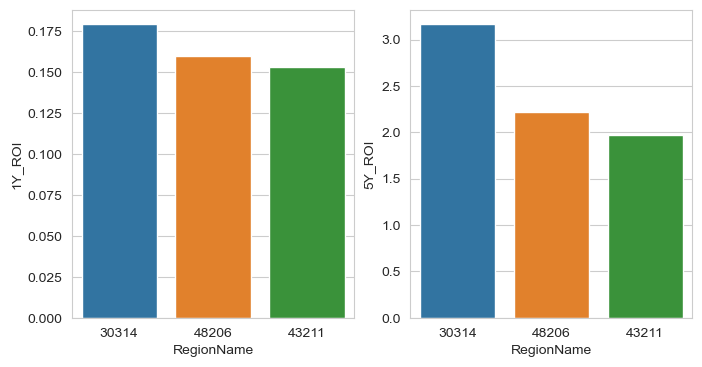

In [58]:
#Create a bar plot
fig, axs = plt.subplots(ncols=2)
sb.barplot(x="RegionName",
           y="1Y_ROI",
           data = model1_top3_1y,
          order = model1_top3_1y.sort_values('1Y_ROI',ascending = False).RegionName,
           ax=axs[0])
sb.barplot(x="RegionName",
           y="5Y_ROI",
           data = model1_top3_5y,
          order = model1_top3_5y.sort_values('5Y_ROI',ascending = False).RegionName, 
           ax=axs[1])
plt.show()

In [59]:
#create a plot for top 3 zip codes
def top3_df (df, top1, top2, top3):
    # Create a dataframe to save the records for top 3 zip codes
    predictions1 = df[df['RegionName'] == top1].reset_index()
    predictions2 = df[df['RegionName'] == top2].reset_index()
    predictions3 = df[df['RegionName'] == top3].reset_index()

    year = predictions1['Year']
    Top1 = predictions1['y']
    Top2 = predictions2['y']
    Top3 = predictions3['y']
    
    # Create DataFrame
    df_final = pd.DataFrame({'year': year,
                        'Top1': Top1,
                        'Top2': Top2,
                        'Top3': Top3
                       })

    df_final = df_final.set_index('year')
    return(df_final)

In [60]:
top1_region = 30314
top2_region = 48206
top3_region = 43211

top3_results = top3_df(grouped_all,top1_region,top2_region,top3_region)
print(top3_results)

               Top1           Top2           Top3
year                                             
1997   28837.223271   14771.826686   42102.599866
1998   33510.512264   16106.739928   45924.014670
1999   38190.225172   17441.623267   49718.088908
2000   42926.366036   18770.931547   52763.868140
2001   47750.502216   20122.977466   54181.551760
2002   54446.378770   21506.783936   54741.550924
2003   63347.995751   23405.148635   55301.286096
2004   72663.810003   25435.602432   55785.145394
2005   81930.561931   27361.308048   56416.808090
2006   88832.143940   28861.459683   56359.416786
2007   81317.227188   26788.277555   53090.526982
2008   60163.588981   20559.251977   46457.299033
2009   39011.820877   14170.672502   39749.991336
2010   26547.840097   10151.984209   32962.225389
2011   22379.034004    9256.433200   26292.470009
2012   23035.696478   10601.796060   21190.579951
2013   26390.241132   13464.096570   21022.154212
2014   30068.496244   16738.189734   22665.739918


In [61]:
# return the records for any zip code
def record_by_region (DF, zipcode):
    return(DF[DF['RegionName']== zipcode][['RegionName','State', 'City', 'Metro']].drop_duplicates())

In [62]:
top3_records = pd.DataFrame()
top3_records = pd.concat([top3_records,(record_by_region(final_df, top1_region)),(record_by_region(final_df, top2_region)),(record_by_region(final_df, top3_region)) ])
print(top3_records)

      RegionName State      City                                 Metro
4024       30314    GA   Atlanta  Atlanta-Sandy Springs-Alpharetta, GA
5410       48206    MI   Detroit           Detroit-Warren-Dearborn, MI
3965       43211    OH  Columbus                          Columbus, OH


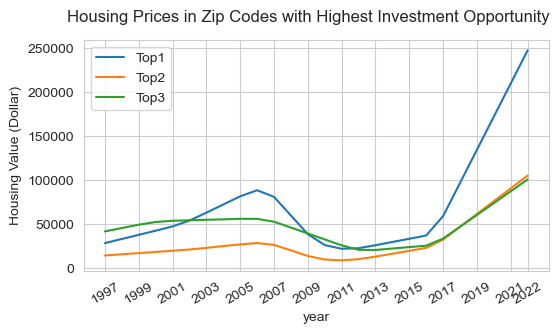

In [63]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021,2022]
fig.suptitle('Housing Prices in Zip Codes with Highest Investment Opportunity')
top3_results.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

In [64]:
#check the MAE and RMSE values for these three areas
top3_records_MAE = pd.DataFrame()
top3_records_MAE = pd.concat([top3_records_MAE,evaluation_results[evaluation_results['RegionName'] == top1_region],
                             evaluation_results[evaluation_results['RegionName'] == top2_region],
                             evaluation_results[evaluation_results['RegionName'] == top3_region]])
print(top3_records_MAE)

  RegionName           MAE          RMSE
0      30314  13459.480509  15578.264448
0      48206   6403.816711   8293.624927
0      43211  17552.709313  18344.935011


[]

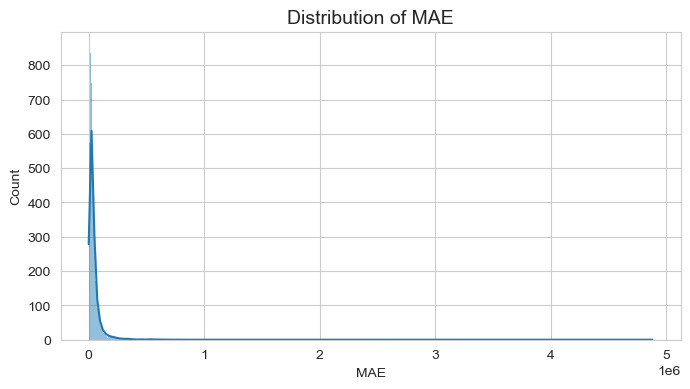

In [65]:
#exploratory data analysis: plot the distribution of SchoolPay
sb.set_style('whitegrid')
sb.histplot(x=evaluation_results['MAE'],
           kde = True)
plt.title('Distribution of MAE', fontdict = {'fontsize': 14})
plt.plot()

#### Build Model Using time series with second order differencing and add CPI regressor

In [72]:
#convert non-stationary time series data using first order differencing method
region_list = ordered_RegionNames
#region_list = [79936,11385]
model_data_diff = pd.DataFrame(columns= ['ds','y','RegionName'])
for region in region_list:
    region_series = model_data.loc[model_data['RegionName'] == region]
    region_series = region_series[['y','ds']]
    region_series = region_series.set_index('ds')
    region_series_new = region_series.diff()
    region_series_new.dropna(inplace=True)
    region_series_new['RegionName'] = region
    region_series_new['ds'] = region_series_new.index
    model_data_diff = pd.concat([model_data_diff,region_series_new])

In [77]:
#convert non-stationary time series data to stationary using differencing method
region_list = ordered_RegionNames
#region_list = [79936,11385]
model_data_diff2 = pd.DataFrame(columns= ['ds','y','RegionName'])
for region in region_list:
    region_series = model_data.loc[model_data['RegionName'] == region]
    region_series = region_series[['y','ds']]
    region_series = region_series.set_index('ds')
    region_series_new = region_series.diff().diff()
    region_series_new.dropna(inplace=True)
    region_series_new['RegionName'] = region
    region_series_new['ds'] = region_series_new.index
    model_data_diff2 = pd.concat([model_data_diff2,region_series_new])

In [78]:
#check new dataframes
model_data_diff = model_data_diff.reset_index(drop=True)
print(model_data_diff)

model_data_diff2 = model_data_diff2.reset_index(drop=True)
print(model_data_diff2)

                 ds            y RegionName
0        1997-02-01  -734.604100       1001
1        1997-03-01  -515.972048       1001
2        1997-04-01   539.090235       1001
3        1997-05-01  1362.063576       1001
4        1997-06-01  1245.000144       1001
...             ...          ...        ...
3910915  2021-08-01  2035.582884      99587
3910916  2021-09-01   -83.204087      99587
3910917  2021-10-01  2371.639075      99587
3910918  2021-11-01 -1686.813954      99587
3910919  2021-12-01  -862.153959      99587

[3910920 rows x 3 columns]
                 ds            y RegionName
0        1997-03-01   218.632052       1001
1        1997-04-01  1055.062282       1001
2        1997-05-01   822.973342       1001
3        1997-06-01  -117.063433       1001
4        1997-07-01   294.094242       1001
...             ...          ...        ...
3897835  2021-08-01 -8726.764943      99587
3897836  2021-09-01 -2118.786972      99587
3897837  2021-10-01  2454.843163      99587
3897

In [79]:
#Merge cpi and house value datasets on the value of ds
cpi = cpi.rename(columns={"value": "CPI"})
new_df1 = pd.merge(model_data, cpi, how="inner", on=["ds"])

#only keep columns we need
new_df1 = new_df1[['ds','y','RegionName','CPI']]
print(new_df1)

                 ds             y  RegionName      CPI
0        1997-01-01  1.326796e+05        8701  159.100
1        1997-01-01  1.900567e+05       77494  159.100
2        1997-01-01  1.108342e+05       77449  159.100
3        1997-01-01  1.777984e+05       78660  159.100
4        1997-01-01  1.755607e+05       11385  159.100
...             ...           ...         ...      ...
3923995  2021-12-01  1.516442e+05       26544  278.802
3923996  2021-12-01  4.236921e+05       95419  278.802
3923997  2021-12-01  1.672926e+05       14415  278.802
3923998  2021-12-01  1.270318e+06        2575  278.802
3923999  2021-12-01  3.320042e+05       22722  278.802

[3924000 rows x 4 columns]


In [80]:
#Merge cpi and house price data where first order differencing was performed
new_df1_diff = pd.merge(model_data_diff, cpi, how="inner", on=["ds"])
new_df1_diff = new_df1_diff[['ds','y','RegionName','CPI']]
print(new_df1_diff)

#Merge fed funds and house price data where second order differencing was performed
new_df1_diff2 = pd.merge(model_data_diff2, cpi, how="inner", on=["ds"])
new_df1_diff2 = new_df1_diff2[['ds','y','RegionName','CPI']]
print(new_df1_diff2)

                 ds            y RegionName      CPI
0        1997-02-01  -734.604100       1001  159.600
1        1997-02-01  -295.113485       1002  159.600
2        1997-02-01  -498.148614       1005  159.600
3        1997-02-01   279.730288       1007  159.600
4        1997-02-01 -1336.434915       1008  159.600
...             ...          ...        ...      ...
3910915  2021-12-01   261.583529      99515  278.802
3910916  2021-12-01   990.315146      99516  278.802
3910917  2021-12-01   -16.714657      99517  278.802
3910918  2021-12-01  2125.918391      99540  278.802
3910919  2021-12-01  -862.153959      99587  278.802

[3910920 rows x 4 columns]
                 ds            y RegionName      CPI
0        1997-03-01   218.632052       1001  160.000
1        1997-03-01  1037.715807       1002  160.000
2        1997-03-01   529.608781       1005  160.000
3        1997-03-01   533.061150       1007  160.000
4        1997-03-01  1422.679032       1008  160.000
...             ..

In [81]:
#Create predictions for each month in 2022 for each Zip Code with CPI regressor
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

#prepare data to build model
region_list = ordered_RegionNames
regressor_df = cpi[['ds','CPI']]
history_data = new_df1.rename(columns={"y": "yhat"})
diff1_data = new_df1_diff.rename(columns={"y": "yhat"})
predictions_regressor1 = pd.DataFrame(columns= ['ds', 'y', 'RegionName','CPI'])

#run forecasts into 12 months in 2022 for each zip code, and combine data for each zip code to one data set
for region in region_list:
    #using second order differencing series to build the model
    region_series = new_df1_diff2.loc[new_df1_diff2['RegionName'] == region]
    region_series = region_series[['y','ds','CPI']]

    # MODEL using Prophet - Set the uncertainty interval to 95% (the Prophet default is 80%)
    model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
    # adding external regressors
    model.add_regressor('CPI')
    # fit the model
    model = model.fit(region_series)
    
    #model = fit.prophet(model, df = region_series)
    future_date = model.make_future_dataframe(periods=12, freq='MS')
    values = cpi['CPI']
    future_date['CPI'] = values
    forecast = model.predict(future_date)
    forecast = forecast[['ds', 'yhat']]
    yhat = forecast['yhat']
    
    #get the original and first order differencing series for inverse steps
    history = history_data.loc[history_data['RegionName'] == region]
    diff1 = diff1_data.loc[diff1_data['RegionName'] == region]
    
    #inverse second order difference
    inverse1 = inverse_difference(diff1['yhat'].tolist(), yhat[-12:], 1)
    inverse2 = inverse_difference(history['yhat'].tolist(), inverse1, 1)
    all_ds = forecast['ds']

    #create DataFrame for the current zip code
    forecast_df = pd.DataFrame({'ds': all_ds[-12:],
        'y': inverse2})
    forecast_df['RegionName'] = region
    forecast_df['CPI'] = values
    #print(forecast_df)
    model_data_region = pd.concat([new_df1.loc[new_df1['RegionName'] == region], forecast_df])
    
    #append data for current zip code to final prediction result data set
    predictions_regressor1 = pd.concat([predictions_regressor1,model_data_region])

22:52:10 - cmdstanpy - INFO - Chain [1] start processing
22:52:10 - cmdstanpy - INFO - Chain [1] done processing
22:52:11 - cmdstanpy - INFO - Chain [1] start processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing
22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing
22:52:13 - cmdstanpy - INFO - Chain [1] start processing
22:52:13 - cmdstanpy - INFO - Chain [1] done processing
22:52:13 - cmdstanpy - INFO - Chain [1] start processing
22:52:13 - cmdstanpy - INFO - Chain [1] done processing
22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] done processing
22:52:15 - cmdstanpy - INFO - Chain [1] start processing
22:52:15 - cmdstanpy - INFO - Chain [1] done processing
22:52:16 - cmdstanpy - INFO - Chain [1] start processing
22:52:16 - cmdstanpy - INFO - Chain [1] done processing
22:52:17 - cmdstanpy - INFO - Chain [1] start processing
22:52:17 - cmdstanpy - INFO - Chain [1]

22:53:08 - cmdstanpy - INFO - Chain [1] done processing
22:53:08 - cmdstanpy - INFO - Chain [1] start processing
22:53:08 - cmdstanpy - INFO - Chain [1] done processing
22:53:09 - cmdstanpy - INFO - Chain [1] start processing
22:53:09 - cmdstanpy - INFO - Chain [1] done processing
22:53:10 - cmdstanpy - INFO - Chain [1] start processing
22:53:10 - cmdstanpy - INFO - Chain [1] done processing
22:53:11 - cmdstanpy - INFO - Chain [1] start processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing
22:53:12 - cmdstanpy - INFO - Chain [1] start processing
22:53:12 - cmdstanpy - INFO - Chain [1] done processing
22:53:12 - cmdstanpy - INFO - Chain [1] start processing
22:53:12 - cmdstanpy - INFO - Chain [1] done processing
22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:13 - cmdstanpy - INFO - Chain [1] done processing
22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:14 - cmdstanpy - INFO - Chain [1] done processing
22:53:15 - cmdstanpy - INFO - Chain [1] 

22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:07 - cmdstanpy - INFO - Chain [1] start processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing
22:54:08 - cmdstanpy - INFO - Chain [1] start processing
22:54:08 - cmdstanpy - INFO - Chain [1] done processing
22:54:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:09 - cmdstanpy - INFO - Chain [1] done processing
22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing
22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing
22:54:11 - cmdstanpy - INFO - Chain [1] start processing
22:54:11 - cmdstanpy - INFO - Chain [1] done processing
22:54:12 - cmdstanpy - INFO - Chain [1] start processing
22:54:12 - cmdstanpy - INFO - Chain [1] done processing
22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing
22:54:14 - cmdstanpy - INFO - Chain [1] 

22:55:07 - cmdstanpy - INFO - Chain [1] done processing
22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] done processing
22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] done processing
22:55:09 - cmdstanpy - INFO - Chain [1] start processing
22:55:09 - cmdstanpy - INFO - Chain [1] done processing
22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:10 - cmdstanpy - INFO - Chain [1] done processing
22:55:11 - cmdstanpy - INFO - Chain [1] start processing
22:55:11 - cmdstanpy - INFO - Chain [1] done processing
22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:12 - cmdstanpy - INFO - Chain [1] done processing
22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:12 - cmdstanpy - INFO - Chain [1] done processing
22:55:13 - cmdstanpy - INFO - Chain [1] start processing
22:55:13 - cmdstanpy - INFO - Chain [1] done processing
22:55:14 - cmdstanpy - INFO - Chain [1] 

22:56:06 - cmdstanpy - INFO - Chain [1] done processing
22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing
22:56:08 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing
22:56:09 - cmdstanpy - INFO - Chain [1] start processing
22:56:09 - cmdstanpy - INFO - Chain [1] done processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing
22:56:11 - cmdstanpy - INFO - Chain [1] start processing
22:56:11 - cmdstanpy - INFO - Chain [1] done processing
22:56:12 - cmdstanpy - INFO - Chain [1] start processing
22:56:12 - cmdstanpy - INFO - Chain [1] done processing
22:56:13 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing
22:56:14 - cmdstanpy - INFO - Chain [1] 

22:57:11 - cmdstanpy - INFO - Chain [1] done processing
22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:12 - cmdstanpy - INFO - Chain [1] done processing
22:57:13 - cmdstanpy - INFO - Chain [1] start processing
22:57:13 - cmdstanpy - INFO - Chain [1] done processing
22:57:14 - cmdstanpy - INFO - Chain [1] start processing
22:57:14 - cmdstanpy - INFO - Chain [1] done processing
22:57:15 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing
22:57:16 - cmdstanpy - INFO - Chain [1] start processing
22:57:16 - cmdstanpy - INFO - Chain [1] done processing
22:57:17 - cmdstanpy - INFO - Chain [1] start processing
22:57:17 - cmdstanpy - INFO - Chain [1] done processing
22:57:18 - cmdstanpy - INFO - Chain [1] start processing
22:57:18 - cmdstanpy - INFO - Chain [1] done processing
22:57:19 - cmdstanpy - INFO - Chain [1] start processing
22:57:19 - cmdstanpy - INFO - Chain [1] done processing
22:57:20 - cmdstanpy - INFO - Chain [1] 

22:58:22 - cmdstanpy - INFO - Chain [1] done processing
22:58:23 - cmdstanpy - INFO - Chain [1] start processing
22:58:23 - cmdstanpy - INFO - Chain [1] done processing
22:58:24 - cmdstanpy - INFO - Chain [1] start processing
22:58:24 - cmdstanpy - INFO - Chain [1] done processing
22:58:25 - cmdstanpy - INFO - Chain [1] start processing
22:58:25 - cmdstanpy - INFO - Chain [1] done processing
22:58:26 - cmdstanpy - INFO - Chain [1] start processing
22:58:26 - cmdstanpy - INFO - Chain [1] done processing
22:58:27 - cmdstanpy - INFO - Chain [1] start processing
22:58:27 - cmdstanpy - INFO - Chain [1] done processing
22:58:28 - cmdstanpy - INFO - Chain [1] start processing
22:58:28 - cmdstanpy - INFO - Chain [1] done processing
22:58:29 - cmdstanpy - INFO - Chain [1] start processing
22:58:29 - cmdstanpy - INFO - Chain [1] done processing
22:58:30 - cmdstanpy - INFO - Chain [1] start processing
22:58:30 - cmdstanpy - INFO - Chain [1] done processing
22:58:31 - cmdstanpy - INFO - Chain [1] 

22:59:29 - cmdstanpy - INFO - Chain [1] done processing
22:59:29 - cmdstanpy - INFO - Chain [1] start processing
22:59:29 - cmdstanpy - INFO - Chain [1] done processing
22:59:30 - cmdstanpy - INFO - Chain [1] start processing
22:59:30 - cmdstanpy - INFO - Chain [1] done processing
22:59:31 - cmdstanpy - INFO - Chain [1] start processing
22:59:31 - cmdstanpy - INFO - Chain [1] done processing
22:59:32 - cmdstanpy - INFO - Chain [1] start processing
22:59:32 - cmdstanpy - INFO - Chain [1] done processing
22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing
22:59:34 - cmdstanpy - INFO - Chain [1] start processing
22:59:34 - cmdstanpy - INFO - Chain [1] done processing
22:59:35 - cmdstanpy - INFO - Chain [1] start processing
22:59:35 - cmdstanpy - INFO - Chain [1] done processing
22:59:36 - cmdstanpy - INFO - Chain [1] start processing
22:59:36 - cmdstanpy - INFO - Chain [1] done processing
22:59:36 - cmdstanpy - INFO - Chain [1] 

23:00:32 - cmdstanpy - INFO - Chain [1] done processing
23:00:33 - cmdstanpy - INFO - Chain [1] start processing
23:00:33 - cmdstanpy - INFO - Chain [1] done processing
23:00:34 - cmdstanpy - INFO - Chain [1] start processing
23:00:34 - cmdstanpy - INFO - Chain [1] done processing
23:00:35 - cmdstanpy - INFO - Chain [1] start processing
23:00:35 - cmdstanpy - INFO - Chain [1] done processing
23:00:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing
23:00:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing
23:00:37 - cmdstanpy - INFO - Chain [1] start processing
23:00:37 - cmdstanpy - INFO - Chain [1] done processing
23:00:38 - cmdstanpy - INFO - Chain [1] start processing
23:00:38 - cmdstanpy - INFO - Chain [1] done processing
23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] done processing
23:00:40 - cmdstanpy - INFO - Chain [1] 

23:01:36 - cmdstanpy - INFO - Chain [1] done processing
23:01:37 - cmdstanpy - INFO - Chain [1] start processing
23:01:37 - cmdstanpy - INFO - Chain [1] done processing
23:01:37 - cmdstanpy - INFO - Chain [1] start processing
23:01:37 - cmdstanpy - INFO - Chain [1] done processing
23:01:38 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] done processing
23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing
23:01:40 - cmdstanpy - INFO - Chain [1] start processing
23:01:40 - cmdstanpy - INFO - Chain [1] done processing
23:01:41 - cmdstanpy - INFO - Chain [1] start processing
23:01:41 - cmdstanpy - INFO - Chain [1] done processing
23:01:42 - cmdstanpy - INFO - Chain [1] start processing
23:01:42 - cmdstanpy - INFO - Chain [1] done processing
23:01:43 - cmdstanpy - INFO - Chain [1] start processing
23:01:43 - cmdstanpy - INFO - Chain [1] done processing
23:01:44 - cmdstanpy - INFO - Chain [1] 

23:02:39 - cmdstanpy - INFO - Chain [1] done processing
23:02:40 - cmdstanpy - INFO - Chain [1] start processing
23:02:40 - cmdstanpy - INFO - Chain [1] done processing
23:02:41 - cmdstanpy - INFO - Chain [1] start processing
23:02:41 - cmdstanpy - INFO - Chain [1] done processing
23:02:42 - cmdstanpy - INFO - Chain [1] start processing
23:02:42 - cmdstanpy - INFO - Chain [1] done processing
23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:43 - cmdstanpy - INFO - Chain [1] done processing
23:02:44 - cmdstanpy - INFO - Chain [1] start processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing
23:02:44 - cmdstanpy - INFO - Chain [1] start processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing
23:02:45 - cmdstanpy - INFO - Chain [1] start processing
23:02:45 - cmdstanpy - INFO - Chain [1] done processing
23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing
23:02:47 - cmdstanpy - INFO - Chain [1] 

23:03:43 - cmdstanpy - INFO - Chain [1] done processing
23:03:44 - cmdstanpy - INFO - Chain [1] start processing
23:03:44 - cmdstanpy - INFO - Chain [1] done processing
23:03:45 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing
23:03:46 - cmdstanpy - INFO - Chain [1] start processing
23:03:46 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing
23:03:48 - cmdstanpy - INFO - Chain [1] start processing
23:03:48 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:50 - cmdstanpy - INFO - Chain [1] start processing
23:03:50 - cmdstanpy - INFO - Chain [1] done processing
23:03:51 - cmdstanpy - INFO - Chain [1] 

23:04:51 - cmdstanpy - INFO - Chain [1] done processing
23:04:52 - cmdstanpy - INFO - Chain [1] start processing
23:04:52 - cmdstanpy - INFO - Chain [1] done processing
23:04:53 - cmdstanpy - INFO - Chain [1] start processing
23:04:53 - cmdstanpy - INFO - Chain [1] done processing
23:04:54 - cmdstanpy - INFO - Chain [1] start processing
23:04:54 - cmdstanpy - INFO - Chain [1] done processing
23:04:55 - cmdstanpy - INFO - Chain [1] start processing
23:04:55 - cmdstanpy - INFO - Chain [1] done processing
23:04:55 - cmdstanpy - INFO - Chain [1] start processing
23:04:56 - cmdstanpy - INFO - Chain [1] done processing
23:04:56 - cmdstanpy - INFO - Chain [1] start processing
23:04:56 - cmdstanpy - INFO - Chain [1] done processing
23:04:57 - cmdstanpy - INFO - Chain [1] start processing
23:04:57 - cmdstanpy - INFO - Chain [1] done processing
23:04:58 - cmdstanpy - INFO - Chain [1] start processing
23:04:58 - cmdstanpy - INFO - Chain [1] done processing
23:04:59 - cmdstanpy - INFO - Chain [1] 

23:05:56 - cmdstanpy - INFO - Chain [1] done processing
23:05:57 - cmdstanpy - INFO - Chain [1] start processing
23:05:57 - cmdstanpy - INFO - Chain [1] done processing
23:05:57 - cmdstanpy - INFO - Chain [1] start processing
23:05:57 - cmdstanpy - INFO - Chain [1] done processing
23:05:58 - cmdstanpy - INFO - Chain [1] start processing
23:05:58 - cmdstanpy - INFO - Chain [1] done processing
23:05:59 - cmdstanpy - INFO - Chain [1] start processing
23:05:59 - cmdstanpy - INFO - Chain [1] done processing
23:06:00 - cmdstanpy - INFO - Chain [1] start processing
23:06:00 - cmdstanpy - INFO - Chain [1] done processing
23:06:01 - cmdstanpy - INFO - Chain [1] start processing
23:06:01 - cmdstanpy - INFO - Chain [1] done processing
23:06:02 - cmdstanpy - INFO - Chain [1] start processing
23:06:02 - cmdstanpy - INFO - Chain [1] done processing
23:06:03 - cmdstanpy - INFO - Chain [1] start processing
23:06:03 - cmdstanpy - INFO - Chain [1] done processing
23:06:04 - cmdstanpy - INFO - Chain [1] 

23:07:00 - cmdstanpy - INFO - Chain [1] done processing
23:07:01 - cmdstanpy - INFO - Chain [1] start processing
23:07:01 - cmdstanpy - INFO - Chain [1] done processing
23:07:02 - cmdstanpy - INFO - Chain [1] start processing
23:07:02 - cmdstanpy - INFO - Chain [1] done processing
23:07:03 - cmdstanpy - INFO - Chain [1] start processing
23:07:03 - cmdstanpy - INFO - Chain [1] done processing
23:07:04 - cmdstanpy - INFO - Chain [1] start processing
23:07:04 - cmdstanpy - INFO - Chain [1] done processing
23:07:04 - cmdstanpy - INFO - Chain [1] start processing
23:07:04 - cmdstanpy - INFO - Chain [1] done processing
23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
23:07:06 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing
23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing
23:07:08 - cmdstanpy - INFO - Chain [1] 

23:08:04 - cmdstanpy - INFO - Chain [1] done processing
23:08:05 - cmdstanpy - INFO - Chain [1] start processing
23:08:05 - cmdstanpy - INFO - Chain [1] done processing
23:08:06 - cmdstanpy - INFO - Chain [1] start processing
23:08:06 - cmdstanpy - INFO - Chain [1] done processing
23:08:07 - cmdstanpy - INFO - Chain [1] start processing
23:08:07 - cmdstanpy - INFO - Chain [1] done processing
23:08:07 - cmdstanpy - INFO - Chain [1] start processing
23:08:07 - cmdstanpy - INFO - Chain [1] done processing
23:08:08 - cmdstanpy - INFO - Chain [1] start processing
23:08:08 - cmdstanpy - INFO - Chain [1] done processing
23:08:09 - cmdstanpy - INFO - Chain [1] start processing
23:08:09 - cmdstanpy - INFO - Chain [1] done processing
23:08:10 - cmdstanpy - INFO - Chain [1] start processing
23:08:10 - cmdstanpy - INFO - Chain [1] done processing
23:08:11 - cmdstanpy - INFO - Chain [1] start processing
23:08:11 - cmdstanpy - INFO - Chain [1] done processing
23:08:12 - cmdstanpy - INFO - Chain [1] 

23:09:08 - cmdstanpy - INFO - Chain [1] done processing
23:09:09 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] done processing
23:09:10 - cmdstanpy - INFO - Chain [1] start processing
23:09:10 - cmdstanpy - INFO - Chain [1] done processing
23:09:11 - cmdstanpy - INFO - Chain [1] start processing
23:09:11 - cmdstanpy - INFO - Chain [1] done processing
23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing
23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing
23:09:13 - cmdstanpy - INFO - Chain [1] start processing
23:09:13 - cmdstanpy - INFO - Chain [1] done processing
23:09:14 - cmdstanpy - INFO - Chain [1] start processing
23:09:14 - cmdstanpy - INFO - Chain [1] done processing
23:09:15 - cmdstanpy - INFO - Chain [1] start processing
23:09:15 - cmdstanpy - INFO - Chain [1] done processing
23:09:16 - cmdstanpy - INFO - Chain [1] 

23:10:12 - cmdstanpy - INFO - Chain [1] done processing
23:10:13 - cmdstanpy - INFO - Chain [1] start processing
23:10:13 - cmdstanpy - INFO - Chain [1] done processing
23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing
23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing
23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing
23:10:16 - cmdstanpy - INFO - Chain [1] start processing
23:10:16 - cmdstanpy - INFO - Chain [1] done processing
23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing
23:10:18 - cmdstanpy - INFO - Chain [1] start processing
23:10:18 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing
23:10:20 - cmdstanpy - INFO - Chain [1] 

23:11:16 - cmdstanpy - INFO - Chain [1] done processing
23:11:17 - cmdstanpy - INFO - Chain [1] start processing
23:11:17 - cmdstanpy - INFO - Chain [1] done processing
23:11:18 - cmdstanpy - INFO - Chain [1] start processing
23:11:18 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:20 - cmdstanpy - INFO - Chain [1] done processing
23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:21 - cmdstanpy - INFO - Chain [1] done processing
23:11:21 - cmdstanpy - INFO - Chain [1] start processing
23:11:21 - cmdstanpy - INFO - Chain [1] done processing
23:11:22 - cmdstanpy - INFO - Chain [1] start processing
23:11:22 - cmdstanpy - INFO - Chain [1] done processing
23:11:23 - cmdstanpy - INFO - Chain [1] start processing
23:11:23 - cmdstanpy - INFO - Chain [1] done processing
23:11:24 - cmdstanpy - INFO - Chain [1] 

23:12:20 - cmdstanpy - INFO - Chain [1] done processing
23:12:21 - cmdstanpy - INFO - Chain [1] start processing
23:12:21 - cmdstanpy - INFO - Chain [1] done processing
23:12:22 - cmdstanpy - INFO - Chain [1] start processing
23:12:22 - cmdstanpy - INFO - Chain [1] done processing
23:12:23 - cmdstanpy - INFO - Chain [1] start processing
23:12:23 - cmdstanpy - INFO - Chain [1] done processing
23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:24 - cmdstanpy - INFO - Chain [1] done processing
23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing
23:12:26 - cmdstanpy - INFO - Chain [1] start processing
23:12:26 - cmdstanpy - INFO - Chain [1] done processing
23:12:26 - cmdstanpy - INFO - Chain [1] start processing
23:12:26 - cmdstanpy - INFO - Chain [1] done processing
23:12:27 - cmdstanpy - INFO - Chain [1] start processing
23:12:28 - cmdstanpy - INFO - Chain [1] done processing
23:12:28 - cmdstanpy - INFO - Chain [1] 

23:13:25 - cmdstanpy - INFO - Chain [1] done processing
23:13:26 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
23:13:27 - cmdstanpy - INFO - Chain [1] done processing
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
23:13:27 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:29 - cmdstanpy - INFO - Chain [1] done processing
23:13:30 - cmdstanpy - INFO - Chain [1] start processing
23:13:30 - cmdstanpy - INFO - Chain [1] done processing
23:13:31 - cmdstanpy - INFO - Chain [1] start processing
23:13:31 - cmdstanpy - INFO - Chain [1] done processing
23:13:32 - cmdstanpy - INFO - Chain [1] start processing
23:13:32 - cmdstanpy - INFO - Chain [1] done processing
23:13:33 - cmdstanpy - INFO - Chain [1] 

23:14:29 - cmdstanpy - INFO - Chain [1] done processing
23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:34 - cmdstanpy - INFO - Chain [1] start processing
23:14:34 - cmdstanpy - INFO - Chain [1] done processing
23:14:35 - cmdstanpy - INFO - Chain [1] start processing
23:14:35 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:37 - cmdstanpy - INFO - Chain [1] 

23:15:34 - cmdstanpy - INFO - Chain [1] done processing
23:15:35 - cmdstanpy - INFO - Chain [1] start processing
23:15:35 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:37 - cmdstanpy - INFO - Chain [1] start processing
23:15:37 - cmdstanpy - INFO - Chain [1] done processing
23:15:38 - cmdstanpy - INFO - Chain [1] start processing
23:15:38 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing
23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:42 - cmdstanpy - INFO - Chain [1] 

23:16:38 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:40 - cmdstanpy - INFO - Chain [1] start processing
23:16:40 - cmdstanpy - INFO - Chain [1] done processing
23:16:41 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:43 - cmdstanpy - INFO - Chain [1] start processing
23:16:43 - cmdstanpy - INFO - Chain [1] done processing
23:16:43 - cmdstanpy - INFO - Chain [1] start processing
23:16:43 - cmdstanpy - INFO - Chain [1] done processing
23:16:44 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:46 - cmdstanpy - INFO - Chain [1] 

23:17:42 - cmdstanpy - INFO - Chain [1] done processing
23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing
23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing
23:17:46 - cmdstanpy - INFO - Chain [1] start processing
23:17:46 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:48 - cmdstanpy - INFO - Chain [1] start processing
23:17:48 - cmdstanpy - INFO - Chain [1] done processing
23:17:49 - cmdstanpy - INFO - Chain [1] start processing
23:17:49 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] 

23:18:47 - cmdstanpy - INFO - Chain [1] done processing
23:18:48 - cmdstanpy - INFO - Chain [1] start processing
23:18:48 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:50 - cmdstanpy - INFO - Chain [1] done processing
23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:51 - cmdstanpy - INFO - Chain [1] done processing
23:18:52 - cmdstanpy - INFO - Chain [1] start processing
23:18:52 - cmdstanpy - INFO - Chain [1] done processing
23:18:53 - cmdstanpy - INFO - Chain [1] start processing
23:18:53 - cmdstanpy - INFO - Chain [1] done processing
23:18:54 - cmdstanpy - INFO - Chain [1] start processing
23:18:54 - cmdstanpy - INFO - Chain [1] done processing
23:18:54 - cmdstanpy - INFO - Chain [1] start processing
23:18:54 - cmdstanpy - INFO - Chain [1] done processing
23:18:55 - cmdstanpy - INFO - Chain [1] 

23:19:53 - cmdstanpy - INFO - Chain [1] done processing
23:19:54 - cmdstanpy - INFO - Chain [1] start processing
23:19:54 - cmdstanpy - INFO - Chain [1] done processing
23:19:54 - cmdstanpy - INFO - Chain [1] start processing
23:19:54 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:56 - cmdstanpy - INFO - Chain [1] start processing
23:19:56 - cmdstanpy - INFO - Chain [1] done processing
23:19:57 - cmdstanpy - INFO - Chain [1] start processing
23:19:57 - cmdstanpy - INFO - Chain [1] done processing
23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:58 - cmdstanpy - INFO - Chain [1] done processing
23:19:59 - cmdstanpy - INFO - Chain [1] start processing
23:19:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] 

23:21:00 - cmdstanpy - INFO - Chain [1] done processing
23:21:00 - cmdstanpy - INFO - Chain [1] start processing
23:21:00 - cmdstanpy - INFO - Chain [1] done processing
23:21:01 - cmdstanpy - INFO - Chain [1] start processing
23:21:01 - cmdstanpy - INFO - Chain [1] done processing
23:21:02 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing
23:21:03 - cmdstanpy - INFO - Chain [1] start processing
23:21:03 - cmdstanpy - INFO - Chain [1] done processing
23:21:04 - cmdstanpy - INFO - Chain [1] start processing
23:21:04 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:06 - cmdstanpy - INFO - Chain [1] start processing
23:21:06 - cmdstanpy - INFO - Chain [1] done processing
23:21:07 - cmdstanpy - INFO - Chain [1] start processing
23:21:07 - cmdstanpy - INFO - Chain [1] done processing
23:21:07 - cmdstanpy - INFO - Chain [1] 

23:22:06 - cmdstanpy - INFO - Chain [1] done processing
23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing
23:22:10 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing
23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing
23:22:12 - cmdstanpy - INFO - Chain [1] start processing
23:22:12 - cmdstanpy - INFO - Chain [1] done processing
23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:13 - cmdstanpy - INFO - Chain [1] done processing
23:22:14 - cmdstanpy - INFO - Chain [1] start processing
23:22:14 - cmdstanpy - INFO - Chain [1] done processing
23:22:14 - cmdstanpy - INFO - Chain [1] 

23:23:14 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:16 - cmdstanpy - INFO - Chain [1] start processing
23:23:16 - cmdstanpy - INFO - Chain [1] done processing
23:23:17 - cmdstanpy - INFO - Chain [1] start processing
23:23:17 - cmdstanpy - INFO - Chain [1] done processing
23:23:17 - cmdstanpy - INFO - Chain [1] start processing
23:23:17 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:19 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing
23:23:20 - cmdstanpy - INFO - Chain [1] start processing
23:23:20 - cmdstanpy - INFO - Chain [1] done processing
23:23:21 - cmdstanpy - INFO - Chain [1] start processing
23:23:21 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] 

23:24:25 - cmdstanpy - INFO - Chain [1] done processing
23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing
23:24:27 - cmdstanpy - INFO - Chain [1] start processing
23:24:27 - cmdstanpy - INFO - Chain [1] done processing
23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:28 - cmdstanpy - INFO - Chain [1] done processing
23:24:29 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing
23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:30 - cmdstanpy - INFO - Chain [1] done processing
23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing
23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing
23:24:32 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] 

23:25:32 - cmdstanpy - INFO - Chain [1] done processing
23:25:33 - cmdstanpy - INFO - Chain [1] start processing
23:25:33 - cmdstanpy - INFO - Chain [1] done processing
23:25:34 - cmdstanpy - INFO - Chain [1] start processing
23:25:34 - cmdstanpy - INFO - Chain [1] done processing
23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:35 - cmdstanpy - INFO - Chain [1] done processing
23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:38 - cmdstanpy - INFO - Chain [1] start processing
23:25:38 - cmdstanpy - INFO - Chain [1] done processing
23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] done processing
23:25:40 - cmdstanpy - INFO - Chain [1] start processing
23:25:40 - cmdstanpy - INFO - Chain [1] done processing
23:25:41 - cmdstanpy - INFO - Chain [1] 

23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:42 - cmdstanpy - INFO - Chain [1] start processing
23:26:42 - cmdstanpy - INFO - Chain [1] done processing
23:26:42 - cmdstanpy - INFO - Chain [1] start processing
23:26:43 - cmdstanpy - INFO - Chain [1] done processing
23:26:43 - cmdstanpy - INFO - Chain [1] start processing
23:26:43 - cmdstanpy - INFO - Chain [1] done processing
23:26:44 - cmdstanpy - INFO - Chain [1] start processing
23:26:44 - cmdstanpy - INFO - Chain [1] done processing
23:26:45 - cmdstanpy - INFO - Chain [1] start processing
23:26:45 - cmdstanpy - INFO - Chain [1] done processing
23:26:46 - cmdstanpy - INFO - Chain [1] start processing
23:26:46 - cmdstanpy - INFO - Chain [1] done processing
23:26:47 - cmdstanpy - INFO - Chain [1] start processing
23:26:47 - cmdstanpy - INFO - Chain [1] done processing
23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing
23:26:49 - cmdstanpy - INFO - Chain [1] 

23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:47 - cmdstanpy - INFO - Chain [1] done processing
23:27:48 - cmdstanpy - INFO - Chain [1] start processing
23:27:48 - cmdstanpy - INFO - Chain [1] done processing
23:27:49 - cmdstanpy - INFO - Chain [1] start processing
23:27:49 - cmdstanpy - INFO - Chain [1] done processing
23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing
23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing
23:27:53 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] 

23:28:51 - cmdstanpy - INFO - Chain [1] done processing
23:28:51 - cmdstanpy - INFO - Chain [1] start processing
23:28:51 - cmdstanpy - INFO - Chain [1] done processing
23:28:52 - cmdstanpy - INFO - Chain [1] start processing
23:28:52 - cmdstanpy - INFO - Chain [1] done processing
23:28:53 - cmdstanpy - INFO - Chain [1] start processing
23:28:53 - cmdstanpy - INFO - Chain [1] done processing
23:28:54 - cmdstanpy - INFO - Chain [1] start processing
23:28:54 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing
23:28:57 - cmdstanpy - INFO - Chain [1] start processing
23:28:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:58 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing
23:28:59 - cmdstanpy - INFO - Chain [1] 

23:29:56 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:58 - cmdstanpy - INFO - Chain [1] start processing
23:29:58 - cmdstanpy - INFO - Chain [1] done processing
23:29:59 - cmdstanpy - INFO - Chain [1] start processing
23:29:59 - cmdstanpy - INFO - Chain [1] done processing
23:30:00 - cmdstanpy - INFO - Chain [1] start processing
23:30:00 - cmdstanpy - INFO - Chain [1] done processing
23:30:01 - cmdstanpy - INFO - Chain [1] start processing
23:30:01 - cmdstanpy - INFO - Chain [1] done processing
23:30:02 - cmdstanpy - INFO - Chain [1] start processing
23:30:02 - cmdstanpy - INFO - Chain [1] done processing
23:30:02 - cmdstanpy - INFO - Chain [1] start processing
23:30:02 - cmdstanpy - INFO - Chain [1] done processing
23:30:03 - cmdstanpy - INFO - Chain [1] start processing
23:30:03 - cmdstanpy - INFO - Chain [1] done processing
23:30:04 - cmdstanpy - INFO - Chain [1] 

23:31:04 - cmdstanpy - INFO - Chain [1] done processing
23:31:04 - cmdstanpy - INFO - Chain [1] start processing
23:31:05 - cmdstanpy - INFO - Chain [1] done processing
23:31:05 - cmdstanpy - INFO - Chain [1] start processing
23:31:05 - cmdstanpy - INFO - Chain [1] done processing
23:31:06 - cmdstanpy - INFO - Chain [1] start processing
23:31:06 - cmdstanpy - INFO - Chain [1] done processing
23:31:07 - cmdstanpy - INFO - Chain [1] start processing
23:31:07 - cmdstanpy - INFO - Chain [1] done processing
23:31:08 - cmdstanpy - INFO - Chain [1] start processing
23:31:08 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:10 - cmdstanpy - INFO - Chain [1] done processing
23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:12 - cmdstanpy - INFO - Chain [1] 

23:32:09 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:11 - cmdstanpy - INFO - Chain [1] start processing
23:32:11 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:15 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] 

23:33:14 - cmdstanpy - INFO - Chain [1] done processing
23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing
23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:16 - cmdstanpy - INFO - Chain [1] done processing
23:33:17 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:19 - cmdstanpy - INFO - Chain [1] start processing
23:33:19 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing
23:33:20 - cmdstanpy - INFO - Chain [1] done processing
23:33:21 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:21 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:22 - cmdstanpy - INFO - Chain [1] 

23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:22 - cmdstanpy - INFO - Chain [1] start processing
23:34:22 - cmdstanpy - INFO - Chain [1] done processing
23:34:23 - cmdstanpy - INFO - Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing
23:34:24 - cmdstanpy - INFO - Chain [1] start processing
23:34:24 - cmdstanpy - INFO - Chain [1] done processing
23:34:25 - cmdstanpy - INFO - Chain [1] start processing
23:34:25 - cmdstanpy - INFO - Chain [1] done processing
23:34:26 - cmdstanpy - INFO - Chain [1] start processing
23:34:26 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:28 - cmdstanpy - INFO - Chain [1] 

23:35:25 - cmdstanpy - INFO - Chain [1] done processing
23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing
23:35:28 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing
23:35:29 - cmdstanpy - INFO - Chain [1] start processing
23:35:29 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:30 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] 

23:36:30 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing
23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing
23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:34 - cmdstanpy - INFO - Chain [1] done processing
23:36:35 - cmdstanpy - INFO - Chain [1] start processing
23:36:35 - cmdstanpy - INFO - Chain [1] done processing
23:36:36 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing
23:36:36 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing
23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:37 - cmdstanpy - INFO - Chain [1] done processing
23:36:38 - cmdstanpy - INFO - Chain [1] 

23:37:36 - cmdstanpy - INFO - Chain [1] done processing
23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing
23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:39 - cmdstanpy - INFO - Chain [1] start processing
23:37:39 - cmdstanpy - INFO - Chain [1] done processing
23:37:40 - cmdstanpy - INFO - Chain [1] start processing
23:37:40 - cmdstanpy - INFO - Chain [1] done processing
23:37:41 - cmdstanpy - INFO - Chain [1] start processing
23:37:41 - cmdstanpy - INFO - Chain [1] done processing
23:37:42 - cmdstanpy - INFO - Chain [1] start processing
23:37:42 - cmdstanpy - INFO - Chain [1] done processing
23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:43 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] 

23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] 

23:39:47 - cmdstanpy - INFO - Chain [1] done processing
23:39:48 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing
23:39:49 - cmdstanpy - INFO - Chain [1] start processing
23:39:49 - cmdstanpy - INFO - Chain [1] done processing
23:39:50 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:53 - cmdstanpy - INFO - Chain [1] done processing
23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing
23:39:55 - cmdstanpy - INFO - Chain [1] 

00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] 

00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing
00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:32 - cmdstanpy - INFO - Chain [1] 

00:09:40 - cmdstanpy - INFO - Chain [1] done processing
00:09:41 - cmdstanpy - INFO - Chain [1] start processing
00:09:41 - cmdstanpy - INFO - Chain [1] done processing
00:09:42 - cmdstanpy - INFO - Chain [1] start processing
00:09:42 - cmdstanpy - INFO - Chain [1] done processing
00:09:43 - cmdstanpy - INFO - Chain [1] start processing
00:09:43 - cmdstanpy - INFO - Chain [1] done processing
00:09:44 - cmdstanpy - INFO - Chain [1] start processing
00:09:44 - cmdstanpy - INFO - Chain [1] done processing
00:09:45 - cmdstanpy - INFO - Chain [1] start processing
00:09:45 - cmdstanpy - INFO - Chain [1] done processing
00:09:46 - cmdstanpy - INFO - Chain [1] start processing
00:09:46 - cmdstanpy - INFO - Chain [1] done processing
00:09:47 - cmdstanpy - INFO - Chain [1] start processing
00:09:47 - cmdstanpy - INFO - Chain [1] done processing
00:09:48 - cmdstanpy - INFO - Chain [1] start processing
00:09:48 - cmdstanpy - INFO - Chain [1] done processing
00:09:49 - cmdstanpy - INFO - Chain [1] 

00:10:56 - cmdstanpy - INFO - Chain [1] done processing
00:10:57 - cmdstanpy - INFO - Chain [1] start processing
00:10:58 - cmdstanpy - INFO - Chain [1] done processing
00:10:58 - cmdstanpy - INFO - Chain [1] start processing
00:10:59 - cmdstanpy - INFO - Chain [1] done processing
00:11:00 - cmdstanpy - INFO - Chain [1] start processing
00:11:00 - cmdstanpy - INFO - Chain [1] done processing
00:11:01 - cmdstanpy - INFO - Chain [1] start processing
00:11:01 - cmdstanpy - INFO - Chain [1] done processing
00:11:02 - cmdstanpy - INFO - Chain [1] start processing
00:11:02 - cmdstanpy - INFO - Chain [1] done processing
00:11:03 - cmdstanpy - INFO - Chain [1] start processing
00:11:03 - cmdstanpy - INFO - Chain [1] done processing
00:11:04 - cmdstanpy - INFO - Chain [1] start processing
00:11:04 - cmdstanpy - INFO - Chain [1] done processing
00:11:05 - cmdstanpy - INFO - Chain [1] start processing
00:11:05 - cmdstanpy - INFO - Chain [1] done processing
00:11:06 - cmdstanpy - INFO - Chain [1] 

00:12:17 - cmdstanpy - INFO - Chain [1] done processing
00:12:18 - cmdstanpy - INFO - Chain [1] start processing
00:12:18 - cmdstanpy - INFO - Chain [1] done processing
00:12:19 - cmdstanpy - INFO - Chain [1] start processing
00:12:19 - cmdstanpy - INFO - Chain [1] done processing
00:12:20 - cmdstanpy - INFO - Chain [1] start processing
00:12:20 - cmdstanpy - INFO - Chain [1] done processing
00:12:21 - cmdstanpy - INFO - Chain [1] start processing
00:12:21 - cmdstanpy - INFO - Chain [1] done processing
00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing
00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:23 - cmdstanpy - INFO - Chain [1] done processing
00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing
00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing
00:12:27 - cmdstanpy - INFO - Chain [1] 

00:13:37 - cmdstanpy - INFO - Chain [1] done processing
00:13:38 - cmdstanpy - INFO - Chain [1] start processing
00:13:38 - cmdstanpy - INFO - Chain [1] done processing
00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing
00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:40 - cmdstanpy - INFO - Chain [1] done processing
00:13:41 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing
00:13:42 - cmdstanpy - INFO - Chain [1] start processing
00:13:42 - cmdstanpy - INFO - Chain [1] done processing
00:13:43 - cmdstanpy - INFO - Chain [1] start processing
00:13:43 - cmdstanpy - INFO - Chain [1] done processing
00:13:44 - cmdstanpy - INFO - Chain [1] start processing
00:13:44 - cmdstanpy - INFO - Chain [1] done processing
00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing
00:13:46 - cmdstanpy - INFO - Chain [1] 

00:14:53 - cmdstanpy - INFO - Chain [1] done processing
00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing
00:14:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:55 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:14:56 - cmdstanpy - INFO - Chain [1] done processing
00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing
00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
00:14:59 - cmdstanpy - INFO - Chain [1] start processing
00:14:59 - cmdstanpy - INFO - Chain [1] done processing
00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:00 - cmdstanpy - INFO - Chain [1] done processing
00:15:01 - cmdstanpy - INFO - Chain [1] start processing
00:15:01 - cmdstanpy - INFO - Chain [1] done processing
00:15:02 - cmdstanpy - INFO - Chain [1] 

00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing
00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing
00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing
00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:13 - cmdstanpy - INFO - Chain [1] done processing
00:16:14 - cmdstanpy - INFO - Chain [1] start processing
00:16:14 - cmdstanpy - INFO - Chain [1] done processing
00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:15 - cmdstanpy - INFO - Chain [1] done processing
00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing
00:16:17 - cmdstanpy - INFO - Chain [1] 

00:17:23 - cmdstanpy - INFO - Chain [1] done processing
00:17:24 - cmdstanpy - INFO - Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing
00:17:25 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing
00:17:26 - cmdstanpy - INFO - Chain [1] start processing
00:17:26 - cmdstanpy - INFO - Chain [1] done processing
00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:27 - cmdstanpy - INFO - Chain [1] done processing
00:17:28 - cmdstanpy - INFO - Chain [1] start processing
00:17:28 - cmdstanpy - INFO - Chain [1] done processing
00:17:29 - cmdstanpy - INFO - Chain [1] start processing
00:17:29 - cmdstanpy - INFO - Chain [1] done processing
00:17:30 - cmdstanpy - INFO - Chain [1] start processing
00:17:30 - cmdstanpy - INFO - Chain [1] done processing
00:17:31 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing
00:17:32 - cmdstanpy - INFO - Chain [1] 

00:18:39 - cmdstanpy - INFO - Chain [1] done processing
00:18:40 - cmdstanpy - INFO - Chain [1] start processing
00:18:40 - cmdstanpy - INFO - Chain [1] done processing
00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:41 - cmdstanpy - INFO - Chain [1] done processing
00:18:42 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing
00:18:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:43 - cmdstanpy - INFO - Chain [1] done processing
00:18:44 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing
00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:45 - cmdstanpy - INFO - Chain [1] done processing
00:18:46 - cmdstanpy - INFO - Chain [1] start processing
00:18:46 - cmdstanpy - INFO - Chain [1] done processing
00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:47 - cmdstanpy - INFO - Chain [1] done processing
00:18:48 - cmdstanpy - INFO - Chain [1] 

00:19:54 - cmdstanpy - INFO - Chain [1] done processing
00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing
00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:56 - cmdstanpy - INFO - Chain [1] done processing
00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing
00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:19:59 - cmdstanpy - INFO - Chain [1] done processing
00:20:00 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing
00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing
00:20:02 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing
00:20:03 - cmdstanpy - INFO - Chain [1] 

00:21:10 - cmdstanpy - INFO - Chain [1] done processing
00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing
00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:12 - cmdstanpy - INFO - Chain [1] done processing
00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing
00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing
00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:15 - cmdstanpy - INFO - Chain [1] done processing
00:21:16 - cmdstanpy - INFO - Chain [1] start processing
00:21:16 - cmdstanpy - INFO - Chain [1] done processing
00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing
00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing
00:21:19 - cmdstanpy - INFO - Chain [1] 

00:22:25 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing
00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing
00:22:28 - cmdstanpy - INFO - Chain [1] start processing
00:22:28 - cmdstanpy - INFO - Chain [1] done processing
00:22:29 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing
00:22:30 - cmdstanpy - INFO - Chain [1] start processing
00:22:30 - cmdstanpy - INFO - Chain [1] done processing
00:22:31 - cmdstanpy - INFO - Chain [1] start processing
00:22:31 - cmdstanpy - INFO - Chain [1] done processing
00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing
00:22:33 - cmdstanpy - INFO - Chain [1] start processing
00:22:33 - cmdstanpy - INFO - Chain [1] done processing
00:22:34 - cmdstanpy - INFO - Chain [1] 

00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] 

00:24:50 - cmdstanpy - INFO - Chain [1] done processing
00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing
00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing
00:24:54 - cmdstanpy - INFO - Chain [1] start processing
00:24:54 - cmdstanpy - INFO - Chain [1] done processing
00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] 

00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing
00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:00 - cmdstanpy - INFO - Chain [1] start processing
00:26:00 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] 

00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:06 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing
00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing
00:27:10 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:13 - cmdstanpy - INFO - Chain [1] 

00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] 

00:29:15 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing
00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:18 - cmdstanpy - INFO - Chain [1] done processing
00:29:19 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing
00:29:21 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing
00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:23 - cmdstanpy - INFO - Chain [1] 

00:30:20 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing
00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing
00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:24 - cmdstanpy - INFO - Chain [1] start processing
00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:26 - cmdstanpy - INFO - Chain [1] start processing
00:30:26 - cmdstanpy - INFO - Chain [1] done processing
00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] 

00:31:25 - cmdstanpy - INFO - Chain [1] done processing
00:31:26 - cmdstanpy - INFO - Chain [1] start processing
00:31:26 - cmdstanpy - INFO - Chain [1] done processing
00:31:27 - cmdstanpy - INFO - Chain [1] start processing
00:31:27 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing
00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing
00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:30 - cmdstanpy - INFO - Chain [1] start processing
00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing
00:31:31 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing
00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:33 - cmdstanpy - INFO - Chain [1] 

00:33:07 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing
00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:10 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing
00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:15 - cmdstanpy - INFO - Chain [1] 

00:34:14 - cmdstanpy - INFO - Chain [1] done processing
00:34:14 - cmdstanpy - INFO - Chain [1] start processing
00:34:14 - cmdstanpy - INFO - Chain [1] done processing
00:34:15 - cmdstanpy - INFO - Chain [1] start processing
00:34:15 - cmdstanpy - INFO - Chain [1] done processing
00:34:16 - cmdstanpy - INFO - Chain [1] start processing
00:34:16 - cmdstanpy - INFO - Chain [1] done processing
00:34:17 - cmdstanpy - INFO - Chain [1] start processing
00:34:17 - cmdstanpy - INFO - Chain [1] done processing
00:34:18 - cmdstanpy - INFO - Chain [1] start processing
00:34:18 - cmdstanpy - INFO - Chain [1] done processing
00:34:19 - cmdstanpy - INFO - Chain [1] start processing
00:34:19 - cmdstanpy - INFO - Chain [1] done processing
00:34:20 - cmdstanpy - INFO - Chain [1] start processing
00:34:20 - cmdstanpy - INFO - Chain [1] done processing
00:34:21 - cmdstanpy - INFO - Chain [1] start processing
00:34:21 - cmdstanpy - INFO - Chain [1] done processing
00:34:22 - cmdstanpy - INFO - Chain [1] 

00:35:27 - cmdstanpy - INFO - Chain [1] done processing
00:35:28 - cmdstanpy - INFO - Chain [1] start processing
00:35:28 - cmdstanpy - INFO - Chain [1] done processing
00:35:29 - cmdstanpy - INFO - Chain [1] start processing
00:35:29 - cmdstanpy - INFO - Chain [1] done processing
00:35:30 - cmdstanpy - INFO - Chain [1] start processing
00:35:30 - cmdstanpy - INFO - Chain [1] done processing
00:35:31 - cmdstanpy - INFO - Chain [1] start processing
00:35:31 - cmdstanpy - INFO - Chain [1] done processing
00:35:32 - cmdstanpy - INFO - Chain [1] start processing
00:35:32 - cmdstanpy - INFO - Chain [1] done processing
00:35:33 - cmdstanpy - INFO - Chain [1] start processing
00:35:33 - cmdstanpy - INFO - Chain [1] done processing
00:35:34 - cmdstanpy - INFO - Chain [1] start processing
00:35:34 - cmdstanpy - INFO - Chain [1] done processing
00:35:34 - cmdstanpy - INFO - Chain [1] start processing
00:35:35 - cmdstanpy - INFO - Chain [1] done processing
00:35:35 - cmdstanpy - INFO - Chain [1] 

00:36:34 - cmdstanpy - INFO - Chain [1] done processing
00:36:34 - cmdstanpy - INFO - Chain [1] start processing
00:36:35 - cmdstanpy - INFO - Chain [1] done processing
00:36:35 - cmdstanpy - INFO - Chain [1] start processing
00:36:36 - cmdstanpy - INFO - Chain [1] done processing
00:36:36 - cmdstanpy - INFO - Chain [1] start processing
00:36:36 - cmdstanpy - INFO - Chain [1] done processing
00:36:37 - cmdstanpy - INFO - Chain [1] start processing
00:36:37 - cmdstanpy - INFO - Chain [1] done processing
00:36:38 - cmdstanpy - INFO - Chain [1] start processing
00:36:38 - cmdstanpy - INFO - Chain [1] done processing
00:36:39 - cmdstanpy - INFO - Chain [1] start processing
00:36:39 - cmdstanpy - INFO - Chain [1] done processing
00:36:40 - cmdstanpy - INFO - Chain [1] start processing
00:36:40 - cmdstanpy - INFO - Chain [1] done processing
00:36:41 - cmdstanpy - INFO - Chain [1] start processing
00:36:41 - cmdstanpy - INFO - Chain [1] done processing
00:36:42 - cmdstanpy - INFO - Chain [1] 

00:37:40 - cmdstanpy - INFO - Chain [1] done processing
00:37:41 - cmdstanpy - INFO - Chain [1] start processing
00:37:41 - cmdstanpy - INFO - Chain [1] done processing
00:37:42 - cmdstanpy - INFO - Chain [1] start processing
00:37:42 - cmdstanpy - INFO - Chain [1] done processing
00:37:43 - cmdstanpy - INFO - Chain [1] start processing
00:37:43 - cmdstanpy - INFO - Chain [1] done processing
00:37:44 - cmdstanpy - INFO - Chain [1] start processing
00:37:44 - cmdstanpy - INFO - Chain [1] done processing
00:37:45 - cmdstanpy - INFO - Chain [1] start processing
00:37:45 - cmdstanpy - INFO - Chain [1] done processing
00:37:46 - cmdstanpy - INFO - Chain [1] start processing
00:37:46 - cmdstanpy - INFO - Chain [1] done processing
00:37:47 - cmdstanpy - INFO - Chain [1] start processing
00:37:47 - cmdstanpy - INFO - Chain [1] done processing
00:37:48 - cmdstanpy - INFO - Chain [1] start processing
00:37:48 - cmdstanpy - INFO - Chain [1] done processing
00:37:49 - cmdstanpy - INFO - Chain [1] 

00:38:47 - cmdstanpy - INFO - Chain [1] done processing
00:38:48 - cmdstanpy - INFO - Chain [1] start processing
00:38:48 - cmdstanpy - INFO - Chain [1] done processing
00:38:49 - cmdstanpy - INFO - Chain [1] start processing
00:38:49 - cmdstanpy - INFO - Chain [1] done processing
00:38:50 - cmdstanpy - INFO - Chain [1] start processing
00:38:50 - cmdstanpy - INFO - Chain [1] done processing
00:38:51 - cmdstanpy - INFO - Chain [1] start processing
00:38:51 - cmdstanpy - INFO - Chain [1] done processing
00:38:52 - cmdstanpy - INFO - Chain [1] start processing
00:38:52 - cmdstanpy - INFO - Chain [1] done processing
00:38:53 - cmdstanpy - INFO - Chain [1] start processing
00:38:53 - cmdstanpy - INFO - Chain [1] done processing
00:38:54 - cmdstanpy - INFO - Chain [1] start processing
00:38:54 - cmdstanpy - INFO - Chain [1] done processing
00:38:55 - cmdstanpy - INFO - Chain [1] start processing
00:38:55 - cmdstanpy - INFO - Chain [1] done processing
00:38:55 - cmdstanpy - INFO - Chain [1] 

00:39:53 - cmdstanpy - INFO - Chain [1] done processing
00:39:54 - cmdstanpy - INFO - Chain [1] start processing
00:39:54 - cmdstanpy - INFO - Chain [1] done processing
00:39:54 - cmdstanpy - INFO - Chain [1] start processing
00:39:54 - cmdstanpy - INFO - Chain [1] done processing
00:39:55 - cmdstanpy - INFO - Chain [1] start processing
00:39:55 - cmdstanpy - INFO - Chain [1] done processing
00:39:56 - cmdstanpy - INFO - Chain [1] start processing
00:39:56 - cmdstanpy - INFO - Chain [1] done processing
00:39:57 - cmdstanpy - INFO - Chain [1] start processing
00:39:57 - cmdstanpy - INFO - Chain [1] done processing
00:39:58 - cmdstanpy - INFO - Chain [1] start processing
00:39:58 - cmdstanpy - INFO - Chain [1] done processing
00:39:59 - cmdstanpy - INFO - Chain [1] start processing
00:39:59 - cmdstanpy - INFO - Chain [1] done processing
00:40:00 - cmdstanpy - INFO - Chain [1] start processing
00:40:00 - cmdstanpy - INFO - Chain [1] done processing
00:40:01 - cmdstanpy - INFO - Chain [1] 

01:00:05 - cmdstanpy - INFO - Chain [1] done processing
01:00:06 - cmdstanpy - INFO - Chain [1] start processing
01:00:06 - cmdstanpy - INFO - Chain [1] done processing
01:00:07 - cmdstanpy - INFO - Chain [1] start processing
01:00:07 - cmdstanpy - INFO - Chain [1] done processing
01:16:41 - cmdstanpy - INFO - Chain [1] start processing
01:16:41 - cmdstanpy - INFO - Chain [1] done processing
01:16:42 - cmdstanpy - INFO - Chain [1] start processing
01:16:42 - cmdstanpy - INFO - Chain [1] done processing
01:16:43 - cmdstanpy - INFO - Chain [1] start processing
01:16:43 - cmdstanpy - INFO - Chain [1] done processing
01:16:44 - cmdstanpy - INFO - Chain [1] start processing
01:16:44 - cmdstanpy - INFO - Chain [1] done processing
01:16:44 - cmdstanpy - INFO - Chain [1] start processing
01:16:45 - cmdstanpy - INFO - Chain [1] done processing
01:16:45 - cmdstanpy - INFO - Chain [1] start processing
01:16:45 - cmdstanpy - INFO - Chain [1] done processing
01:32:27 - cmdstanpy - INFO - Chain [1] 

04:15:47 - cmdstanpy - INFO - Chain [1] done processing
04:15:48 - cmdstanpy - INFO - Chain [1] start processing
04:15:48 - cmdstanpy - INFO - Chain [1] done processing
04:15:49 - cmdstanpy - INFO - Chain [1] start processing
04:15:49 - cmdstanpy - INFO - Chain [1] done processing
04:15:50 - cmdstanpy - INFO - Chain [1] start processing
04:15:50 - cmdstanpy - INFO - Chain [1] done processing
04:15:51 - cmdstanpy - INFO - Chain [1] start processing
04:15:51 - cmdstanpy - INFO - Chain [1] done processing
04:15:52 - cmdstanpy - INFO - Chain [1] start processing
04:15:52 - cmdstanpy - INFO - Chain [1] done processing
04:15:53 - cmdstanpy - INFO - Chain [1] start processing
04:15:53 - cmdstanpy - INFO - Chain [1] done processing
04:31:31 - cmdstanpy - INFO - Chain [1] start processing
04:31:31 - cmdstanpy - INFO - Chain [1] done processing
04:31:32 - cmdstanpy - INFO - Chain [1] start processing
04:31:32 - cmdstanpy - INFO - Chain [1] done processing
04:31:33 - cmdstanpy - INFO - Chain [1] 

07:17:00 - cmdstanpy - INFO - Chain [1] done processing
07:17:01 - cmdstanpy - INFO - Chain [1] start processing
07:17:01 - cmdstanpy - INFO - Chain [1] done processing
07:17:02 - cmdstanpy - INFO - Chain [1] start processing
07:17:02 - cmdstanpy - INFO - Chain [1] done processing
07:17:03 - cmdstanpy - INFO - Chain [1] start processing
07:17:03 - cmdstanpy - INFO - Chain [1] done processing
07:17:04 - cmdstanpy - INFO - Chain [1] start processing
07:17:04 - cmdstanpy - INFO - Chain [1] done processing
07:17:05 - cmdstanpy - INFO - Chain [1] start processing
07:17:05 - cmdstanpy - INFO - Chain [1] done processing
07:34:50 - cmdstanpy - INFO - Chain [1] start processing
07:34:50 - cmdstanpy - INFO - Chain [1] done processing
07:34:50 - cmdstanpy - INFO - Chain [1] start processing
07:34:51 - cmdstanpy - INFO - Chain [1] done processing
07:34:51 - cmdstanpy - INFO - Chain [1] start processing
07:34:51 - cmdstanpy - INFO - Chain [1] done processing
07:34:52 - cmdstanpy - INFO - Chain [1] 

08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:02 - cmdstanpy - INFO - Chain [1] start processing
08:43:02 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:05 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:08 - cmdstanpy - INFO - Chain [1] start processing
08:43:08 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] 

08:44:08 - cmdstanpy - INFO - Chain [1] done processing
08:44:08 - cmdstanpy - INFO - Chain [1] start processing
08:44:08 - cmdstanpy - INFO - Chain [1] done processing
08:44:09 - cmdstanpy - INFO - Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
08:44:10 - cmdstanpy - INFO - Chain [1] start processing
08:44:10 - cmdstanpy - INFO - Chain [1] done processing
08:44:11 - cmdstanpy - INFO - Chain [1] start processing
08:44:11 - cmdstanpy - INFO - Chain [1] done processing
08:44:12 - cmdstanpy - INFO - Chain [1] start processing
08:44:12 - cmdstanpy - INFO - Chain [1] done processing
08:44:13 - cmdstanpy - INFO - Chain [1] start processing
08:44:13 - cmdstanpy - INFO - Chain [1] done processing
08:44:14 - cmdstanpy - INFO - Chain [1] start processing
08:44:14 - cmdstanpy - INFO - Chain [1] done processing
08:44:15 - cmdstanpy - INFO - Chain [1] start processing
08:44:15 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] 

08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:16 - cmdstanpy - INFO - Chain [1] done processing
08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:19 - cmdstanpy - INFO - Chain [1] start processing
08:45:19 - cmdstanpy - INFO - Chain [1] done processing
08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:21 - cmdstanpy - INFO - Chain [1] start processing
08:45:21 - cmdstanpy - INFO - Chain [1] done processing
08:45:22 - cmdstanpy - INFO - Chain [1] 

08:46:20 - cmdstanpy - INFO - Chain [1] done processing
08:46:21 - cmdstanpy - INFO - Chain [1] start processing
08:46:21 - cmdstanpy - INFO - Chain [1] done processing
08:46:22 - cmdstanpy - INFO - Chain [1] start processing
08:46:22 - cmdstanpy - INFO - Chain [1] done processing
08:46:23 - cmdstanpy - INFO - Chain [1] start processing
08:46:23 - cmdstanpy - INFO - Chain [1] done processing
08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:24 - cmdstanpy - INFO - Chain [1] done processing
08:46:25 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:28 - cmdstanpy - INFO - Chain [1] 

08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:32 - cmdstanpy - INFO - Chain [1] done processing
08:47:33 - cmdstanpy - INFO - Chain [1] start processing
08:47:33 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:35 - cmdstanpy - INFO - Chain [1] 

08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing
08:48:42 - cmdstanpy - INFO - Chain [1] 

08:49:44 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:46 - cmdstanpy - INFO - Chain [1] start processing
08:49:46 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:49 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1] done processing
08:49:49 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:52 - cmdstanpy - INFO - Chain [1] 

08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:54 - cmdstanpy - INFO - Chain [1] done processing
08:50:55 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:58 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] 

08:52:01 - cmdstanpy - INFO - Chain [1] done processing
08:52:02 - cmdstanpy - INFO - Chain [1] start processing
08:52:02 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:09 - cmdstanpy - INFO - Chain [1] 

08:53:10 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:12 - cmdstanpy - INFO - Chain [1] done processing
08:53:12 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:14 - cmdstanpy - INFO - Chain [1] start processing
08:53:14 - cmdstanpy - INFO - Chain [1] done processing
08:53:15 - cmdstanpy - INFO - Chain [1] start processing
08:53:15 - cmdstanpy - INFO - Chain [1] done processing
08:53:16 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
08:53:17 - cmdstanpy - INFO - Chain [1] start processing
08:53:17 - cmdstanpy - INFO - Chain [1] done processing
08:53:18 - cmdstanpy - INFO - Chain [1] 

08:54:18 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing
08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] 

08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:27 - cmdstanpy - INFO - Chain [1] done processing
08:55:28 - cmdstanpy - INFO - Chain [1] start processing
08:55:28 - cmdstanpy - INFO - Chain [1] done processing
08:55:29 - cmdstanpy - INFO - Chain [1] start processing
08:55:29 - cmdstanpy - INFO - Chain [1] done processing
08:55:30 - cmdstanpy - INFO - Chain [1] start processing
08:55:30 - cmdstanpy - INFO - Chain [1] done processing
08:55:31 - cmdstanpy - INFO - Chain [1] start processing
08:55:31 - cmdstanpy - INFO - Chain [1] done processing
08:55:32 - cmdstanpy - INFO - Chain [1] start processing
08:55:32 - cmdstanpy - INFO - Chain [1] done processing
08:55:33 - cmdstanpy - INFO - Chain [1] start processing
08:55:33 - cmdstanpy - INFO - Chain [1] done processing
08:55:34 - cmdstanpy - INFO - Chain [1] start processing
08:55:34 - cmdstanpy - INFO - Chain [1] done processing
08:55:35 - cmdstanpy - INFO - Chain [1] 

08:56:34 - cmdstanpy - INFO - Chain [1] done processing
08:56:35 - cmdstanpy - INFO - Chain [1] start processing
08:56:35 - cmdstanpy - INFO - Chain [1] done processing
08:56:36 - cmdstanpy - INFO - Chain [1] start processing
08:56:36 - cmdstanpy - INFO - Chain [1] done processing
08:56:37 - cmdstanpy - INFO - Chain [1] start processing
08:56:37 - cmdstanpy - INFO - Chain [1] done processing
08:56:38 - cmdstanpy - INFO - Chain [1] start processing
08:56:38 - cmdstanpy - INFO - Chain [1] done processing
08:56:39 - cmdstanpy - INFO - Chain [1] start processing
08:56:39 - cmdstanpy - INFO - Chain [1] done processing
08:56:40 - cmdstanpy - INFO - Chain [1] start processing
08:56:40 - cmdstanpy - INFO - Chain [1] done processing
08:56:41 - cmdstanpy - INFO - Chain [1] start processing
08:56:41 - cmdstanpy - INFO - Chain [1] done processing
08:56:42 - cmdstanpy - INFO - Chain [1] start processing
08:56:42 - cmdstanpy - INFO - Chain [1] done processing
08:56:43 - cmdstanpy - INFO - Chain [1] 

08:57:43 - cmdstanpy - INFO - Chain [1] done processing
08:57:44 - cmdstanpy - INFO - Chain [1] start processing
08:57:44 - cmdstanpy - INFO - Chain [1] done processing
08:57:45 - cmdstanpy - INFO - Chain [1] start processing
08:57:45 - cmdstanpy - INFO - Chain [1] done processing
08:57:46 - cmdstanpy - INFO - Chain [1] start processing
08:57:46 - cmdstanpy - INFO - Chain [1] done processing
08:57:47 - cmdstanpy - INFO - Chain [1] start processing
08:57:47 - cmdstanpy - INFO - Chain [1] done processing
08:57:48 - cmdstanpy - INFO - Chain [1] start processing
08:57:48 - cmdstanpy - INFO - Chain [1] done processing
08:57:49 - cmdstanpy - INFO - Chain [1] start processing
08:57:49 - cmdstanpy - INFO - Chain [1] done processing
08:57:50 - cmdstanpy - INFO - Chain [1] start processing
08:57:50 - cmdstanpy - INFO - Chain [1] done processing
08:57:51 - cmdstanpy - INFO - Chain [1] start processing
08:57:51 - cmdstanpy - INFO - Chain [1] done processing
08:57:52 - cmdstanpy - INFO - Chain [1] 

08:58:53 - cmdstanpy - INFO - Chain [1] done processing
08:58:53 - cmdstanpy - INFO - Chain [1] start processing
08:58:53 - cmdstanpy - INFO - Chain [1] done processing
08:58:54 - cmdstanpy - INFO - Chain [1] start processing
08:58:54 - cmdstanpy - INFO - Chain [1] done processing
08:58:55 - cmdstanpy - INFO - Chain [1] start processing
08:58:55 - cmdstanpy - INFO - Chain [1] done processing
08:58:56 - cmdstanpy - INFO - Chain [1] start processing
08:58:56 - cmdstanpy - INFO - Chain [1] done processing
08:58:57 - cmdstanpy - INFO - Chain [1] start processing
08:58:57 - cmdstanpy - INFO - Chain [1] done processing
08:58:58 - cmdstanpy - INFO - Chain [1] start processing
08:58:58 - cmdstanpy - INFO - Chain [1] done processing
08:58:59 - cmdstanpy - INFO - Chain [1] start processing
08:58:59 - cmdstanpy - INFO - Chain [1] done processing
08:59:00 - cmdstanpy - INFO - Chain [1] start processing
08:59:00 - cmdstanpy - INFO - Chain [1] done processing
08:59:01 - cmdstanpy - INFO - Chain [1] 

09:00:01 - cmdstanpy - INFO - Chain [1] done processing
09:00:02 - cmdstanpy - INFO - Chain [1] start processing
09:00:02 - cmdstanpy - INFO - Chain [1] done processing
09:00:03 - cmdstanpy - INFO - Chain [1] start processing
09:00:03 - cmdstanpy - INFO - Chain [1] done processing
09:00:04 - cmdstanpy - INFO - Chain [1] start processing
09:00:04 - cmdstanpy - INFO - Chain [1] done processing
09:00:05 - cmdstanpy - INFO - Chain [1] start processing
09:00:05 - cmdstanpy - INFO - Chain [1] done processing
09:00:06 - cmdstanpy - INFO - Chain [1] start processing
09:00:06 - cmdstanpy - INFO - Chain [1] done processing
09:00:07 - cmdstanpy - INFO - Chain [1] start processing
09:00:07 - cmdstanpy - INFO - Chain [1] done processing
09:00:08 - cmdstanpy - INFO - Chain [1] start processing
09:00:08 - cmdstanpy - INFO - Chain [1] done processing
09:00:09 - cmdstanpy - INFO - Chain [1] start processing
09:00:09 - cmdstanpy - INFO - Chain [1] done processing
09:00:09 - cmdstanpy - INFO - Chain [1] 

09:01:11 - cmdstanpy - INFO - Chain [1] done processing
09:01:12 - cmdstanpy - INFO - Chain [1] start processing
09:01:12 - cmdstanpy - INFO - Chain [1] done processing
09:01:13 - cmdstanpy - INFO - Chain [1] start processing
09:01:13 - cmdstanpy - INFO - Chain [1] done processing
09:01:14 - cmdstanpy - INFO - Chain [1] start processing
09:01:14 - cmdstanpy - INFO - Chain [1] done processing
09:01:15 - cmdstanpy - INFO - Chain [1] start processing
09:01:15 - cmdstanpy - INFO - Chain [1] done processing
09:01:16 - cmdstanpy - INFO - Chain [1] start processing
09:01:16 - cmdstanpy - INFO - Chain [1] done processing
09:01:17 - cmdstanpy - INFO - Chain [1] start processing
09:01:17 - cmdstanpy - INFO - Chain [1] done processing
09:01:18 - cmdstanpy - INFO - Chain [1] start processing
09:01:18 - cmdstanpy - INFO - Chain [1] done processing
09:01:18 - cmdstanpy - INFO - Chain [1] start processing
09:01:19 - cmdstanpy - INFO - Chain [1] done processing
09:01:20 - cmdstanpy - INFO - Chain [1] 

09:02:22 - cmdstanpy - INFO - Chain [1] done processing
09:02:22 - cmdstanpy - INFO - Chain [1] start processing
09:02:22 - cmdstanpy - INFO - Chain [1] done processing
09:02:23 - cmdstanpy - INFO - Chain [1] start processing
09:02:24 - cmdstanpy - INFO - Chain [1] done processing
09:02:24 - cmdstanpy - INFO - Chain [1] start processing
09:02:24 - cmdstanpy - INFO - Chain [1] done processing
09:02:25 - cmdstanpy - INFO - Chain [1] start processing
09:02:25 - cmdstanpy - INFO - Chain [1] done processing
09:02:26 - cmdstanpy - INFO - Chain [1] start processing
09:02:26 - cmdstanpy - INFO - Chain [1] done processing
09:02:27 - cmdstanpy - INFO - Chain [1] start processing
09:02:27 - cmdstanpy - INFO - Chain [1] done processing
09:02:28 - cmdstanpy - INFO - Chain [1] start processing
09:02:28 - cmdstanpy - INFO - Chain [1] done processing
09:02:29 - cmdstanpy - INFO - Chain [1] start processing
09:02:29 - cmdstanpy - INFO - Chain [1] done processing
09:02:30 - cmdstanpy - INFO - Chain [1] 

09:03:31 - cmdstanpy - INFO - Chain [1] done processing
09:03:32 - cmdstanpy - INFO - Chain [1] start processing
09:03:32 - cmdstanpy - INFO - Chain [1] done processing
09:03:33 - cmdstanpy - INFO - Chain [1] start processing
09:03:33 - cmdstanpy - INFO - Chain [1] done processing
09:03:34 - cmdstanpy - INFO - Chain [1] start processing
09:03:34 - cmdstanpy - INFO - Chain [1] done processing
09:03:35 - cmdstanpy - INFO - Chain [1] start processing
09:03:35 - cmdstanpy - INFO - Chain [1] done processing
09:03:36 - cmdstanpy - INFO - Chain [1] start processing
09:03:36 - cmdstanpy - INFO - Chain [1] done processing
09:03:37 - cmdstanpy - INFO - Chain [1] start processing
09:03:37 - cmdstanpy - INFO - Chain [1] done processing
09:03:38 - cmdstanpy - INFO - Chain [1] start processing
09:03:38 - cmdstanpy - INFO - Chain [1] done processing
09:03:39 - cmdstanpy - INFO - Chain [1] start processing
09:03:39 - cmdstanpy - INFO - Chain [1] done processing
09:03:40 - cmdstanpy - INFO - Chain [1] 

09:04:43 - cmdstanpy - INFO - Chain [1] done processing
09:04:44 - cmdstanpy - INFO - Chain [1] start processing
09:04:44 - cmdstanpy - INFO - Chain [1] done processing
09:04:45 - cmdstanpy - INFO - Chain [1] start processing
09:04:45 - cmdstanpy - INFO - Chain [1] done processing
09:04:46 - cmdstanpy - INFO - Chain [1] start processing
09:04:46 - cmdstanpy - INFO - Chain [1] done processing
09:04:47 - cmdstanpy - INFO - Chain [1] start processing
09:04:47 - cmdstanpy - INFO - Chain [1] done processing
09:04:48 - cmdstanpy - INFO - Chain [1] start processing
09:04:48 - cmdstanpy - INFO - Chain [1] done processing
09:04:49 - cmdstanpy - INFO - Chain [1] start processing
09:04:49 - cmdstanpy - INFO - Chain [1] done processing
09:04:50 - cmdstanpy - INFO - Chain [1] start processing
09:04:50 - cmdstanpy - INFO - Chain [1] done processing
09:04:51 - cmdstanpy - INFO - Chain [1] start processing
09:04:51 - cmdstanpy - INFO - Chain [1] done processing
09:04:52 - cmdstanpy - INFO - Chain [1] 

09:05:54 - cmdstanpy - INFO - Chain [1] done processing
09:05:55 - cmdstanpy - INFO - Chain [1] start processing
09:05:55 - cmdstanpy - INFO - Chain [1] done processing
09:05:56 - cmdstanpy - INFO - Chain [1] start processing
09:05:56 - cmdstanpy - INFO - Chain [1] done processing
09:05:57 - cmdstanpy - INFO - Chain [1] start processing
09:05:57 - cmdstanpy - INFO - Chain [1] done processing
09:05:58 - cmdstanpy - INFO - Chain [1] start processing
09:05:58 - cmdstanpy - INFO - Chain [1] done processing
09:06:00 - cmdstanpy - INFO - Chain [1] start processing
09:06:00 - cmdstanpy - INFO - Chain [1] done processing
09:22:35 - cmdstanpy - INFO - Chain [1] start processing
09:22:35 - cmdstanpy - INFO - Chain [1] done processing
09:22:36 - cmdstanpy - INFO - Chain [1] start processing
09:22:36 - cmdstanpy - INFO - Chain [1] done processing
09:22:37 - cmdstanpy - INFO - Chain [1] start processing
09:22:37 - cmdstanpy - INFO - Chain [1] done processing
09:22:38 - cmdstanpy - INFO - Chain [1] 

09:23:37 - cmdstanpy - INFO - Chain [1] done processing
09:23:38 - cmdstanpy - INFO - Chain [1] start processing
09:23:38 - cmdstanpy - INFO - Chain [1] done processing
09:23:39 - cmdstanpy - INFO - Chain [1] start processing
09:23:39 - cmdstanpy - INFO - Chain [1] done processing
09:23:40 - cmdstanpy - INFO - Chain [1] start processing
09:23:40 - cmdstanpy - INFO - Chain [1] done processing
09:23:41 - cmdstanpy - INFO - Chain [1] start processing
09:23:41 - cmdstanpy - INFO - Chain [1] done processing
09:23:42 - cmdstanpy - INFO - Chain [1] start processing
09:23:42 - cmdstanpy - INFO - Chain [1] done processing
09:23:42 - cmdstanpy - INFO - Chain [1] start processing
09:23:43 - cmdstanpy - INFO - Chain [1] done processing
09:23:43 - cmdstanpy - INFO - Chain [1] start processing
09:23:43 - cmdstanpy - INFO - Chain [1] done processing
09:23:44 - cmdstanpy - INFO - Chain [1] start processing
09:23:44 - cmdstanpy - INFO - Chain [1] done processing
09:23:45 - cmdstanpy - INFO - Chain [1] 

09:24:45 - cmdstanpy - INFO - Chain [1] done processing
09:24:46 - cmdstanpy - INFO - Chain [1] start processing
09:24:46 - cmdstanpy - INFO - Chain [1] done processing
09:24:47 - cmdstanpy - INFO - Chain [1] start processing
09:24:47 - cmdstanpy - INFO - Chain [1] done processing
09:24:47 - cmdstanpy - INFO - Chain [1] start processing
09:24:48 - cmdstanpy - INFO - Chain [1] done processing
09:24:48 - cmdstanpy - INFO - Chain [1] start processing
09:24:48 - cmdstanpy - INFO - Chain [1] done processing
09:24:49 - cmdstanpy - INFO - Chain [1] start processing
09:24:49 - cmdstanpy - INFO - Chain [1] done processing
09:24:50 - cmdstanpy - INFO - Chain [1] start processing
09:24:50 - cmdstanpy - INFO - Chain [1] done processing
09:24:51 - cmdstanpy - INFO - Chain [1] start processing
09:24:51 - cmdstanpy - INFO - Chain [1] done processing
09:24:52 - cmdstanpy - INFO - Chain [1] start processing
09:24:52 - cmdstanpy - INFO - Chain [1] done processing
09:24:53 - cmdstanpy - INFO - Chain [1] 

09:42:34 - cmdstanpy - INFO - Chain [1] done processing
09:42:35 - cmdstanpy - INFO - Chain [1] start processing
09:42:35 - cmdstanpy - INFO - Chain [1] done processing
09:42:36 - cmdstanpy - INFO - Chain [1] start processing
09:42:36 - cmdstanpy - INFO - Chain [1] done processing
09:42:37 - cmdstanpy - INFO - Chain [1] start processing
09:42:37 - cmdstanpy - INFO - Chain [1] done processing
09:42:38 - cmdstanpy - INFO - Chain [1] start processing
09:42:38 - cmdstanpy - INFO - Chain [1] done processing
09:42:39 - cmdstanpy - INFO - Chain [1] start processing
09:42:39 - cmdstanpy - INFO - Chain [1] done processing
09:42:40 - cmdstanpy - INFO - Chain [1] start processing
09:42:40 - cmdstanpy - INFO - Chain [1] done processing
09:42:41 - cmdstanpy - INFO - Chain [1] start processing
09:42:41 - cmdstanpy - INFO - Chain [1] done processing
09:42:41 - cmdstanpy - INFO - Chain [1] start processing
09:42:41 - cmdstanpy - INFO - Chain [1] done processing
09:42:42 - cmdstanpy - INFO - Chain [1] 

09:43:42 - cmdstanpy - INFO - Chain [1] done processing
09:43:43 - cmdstanpy - INFO - Chain [1] start processing
09:43:43 - cmdstanpy - INFO - Chain [1] done processing
09:43:44 - cmdstanpy - INFO - Chain [1] start processing
09:43:44 - cmdstanpy - INFO - Chain [1] done processing
09:43:44 - cmdstanpy - INFO - Chain [1] start processing
09:43:45 - cmdstanpy - INFO - Chain [1] done processing
09:43:45 - cmdstanpy - INFO - Chain [1] start processing
09:43:45 - cmdstanpy - INFO - Chain [1] done processing
09:43:46 - cmdstanpy - INFO - Chain [1] start processing
09:43:46 - cmdstanpy - INFO - Chain [1] done processing
09:43:47 - cmdstanpy - INFO - Chain [1] start processing
09:43:47 - cmdstanpy - INFO - Chain [1] done processing
09:43:48 - cmdstanpy - INFO - Chain [1] start processing
09:43:48 - cmdstanpy - INFO - Chain [1] done processing
09:43:49 - cmdstanpy - INFO - Chain [1] start processing
09:43:49 - cmdstanpy - INFO - Chain [1] done processing
09:43:50 - cmdstanpy - INFO - Chain [1] 

09:44:49 - cmdstanpy - INFO - Chain [1] done processing
09:44:50 - cmdstanpy - INFO - Chain [1] start processing
09:44:50 - cmdstanpy - INFO - Chain [1] done processing
09:44:51 - cmdstanpy - INFO - Chain [1] start processing
09:44:51 - cmdstanpy - INFO - Chain [1] done processing
09:44:52 - cmdstanpy - INFO - Chain [1] start processing
09:44:52 - cmdstanpy - INFO - Chain [1] done processing
09:44:53 - cmdstanpy - INFO - Chain [1] start processing
09:44:53 - cmdstanpy - INFO - Chain [1] done processing
09:44:54 - cmdstanpy - INFO - Chain [1] start processing
09:44:54 - cmdstanpy - INFO - Chain [1] done processing
09:44:55 - cmdstanpy - INFO - Chain [1] start processing
09:44:55 - cmdstanpy - INFO - Chain [1] done processing
09:44:56 - cmdstanpy - INFO - Chain [1] start processing
09:44:56 - cmdstanpy - INFO - Chain [1] done processing
09:44:57 - cmdstanpy - INFO - Chain [1] start processing
09:44:57 - cmdstanpy - INFO - Chain [1] done processing
09:44:58 - cmdstanpy - INFO - Chain [1] 

09:46:41 - cmdstanpy - INFO - Chain [1] done processing
09:46:45 - cmdstanpy - INFO - Chain [1] start processing
09:46:45 - cmdstanpy - INFO - Chain [1] done processing
09:46:49 - cmdstanpy - INFO - Chain [1] start processing
09:46:50 - cmdstanpy - INFO - Chain [1] done processing
09:46:54 - cmdstanpy - INFO - Chain [1] start processing
09:46:54 - cmdstanpy - INFO - Chain [1] done processing
09:46:58 - cmdstanpy - INFO - Chain [1] start processing
09:46:58 - cmdstanpy - INFO - Chain [1] done processing
09:47:02 - cmdstanpy - INFO - Chain [1] start processing
09:47:02 - cmdstanpy - INFO - Chain [1] done processing
09:47:07 - cmdstanpy - INFO - Chain [1] start processing
09:47:07 - cmdstanpy - INFO - Chain [1] done processing
09:47:11 - cmdstanpy - INFO - Chain [1] start processing
09:47:11 - cmdstanpy - INFO - Chain [1] done processing
09:47:15 - cmdstanpy - INFO - Chain [1] start processing
09:47:15 - cmdstanpy - INFO - Chain [1] done processing
09:47:20 - cmdstanpy - INFO - Chain [1] 

09:51:56 - cmdstanpy - INFO - Chain [1] done processing
09:52:00 - cmdstanpy - INFO - Chain [1] start processing
09:52:00 - cmdstanpy - INFO - Chain [1] done processing
09:52:04 - cmdstanpy - INFO - Chain [1] start processing
09:52:04 - cmdstanpy - INFO - Chain [1] done processing
09:52:08 - cmdstanpy - INFO - Chain [1] start processing
09:52:08 - cmdstanpy - INFO - Chain [1] done processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] done processing
09:52:17 - cmdstanpy - INFO - Chain [1] start processing
09:52:17 - cmdstanpy - INFO - Chain [1] done processing
09:52:21 - cmdstanpy - INFO - Chain [1] start processing
09:52:21 - cmdstanpy - INFO - Chain [1] done processing
09:52:26 - cmdstanpy - INFO - Chain [1] start processing
09:52:26 - cmdstanpy - INFO - Chain [1] done processing
09:52:30 - cmdstanpy - INFO - Chain [1] start processing
09:52:30 - cmdstanpy - INFO - Chain [1] done processing
09:52:34 - cmdstanpy - INFO - Chain [1] 

10:10:25 - cmdstanpy - INFO - Chain [1] done processing
10:10:26 - cmdstanpy - INFO - Chain [1] start processing
10:10:26 - cmdstanpy - INFO - Chain [1] done processing
10:10:26 - cmdstanpy - INFO - Chain [1] start processing
10:10:26 - cmdstanpy - INFO - Chain [1] done processing
10:10:27 - cmdstanpy - INFO - Chain [1] start processing
10:10:27 - cmdstanpy - INFO - Chain [1] done processing
10:10:28 - cmdstanpy - INFO - Chain [1] start processing
10:10:28 - cmdstanpy - INFO - Chain [1] done processing
10:10:29 - cmdstanpy - INFO - Chain [1] start processing
10:10:29 - cmdstanpy - INFO - Chain [1] done processing
10:10:30 - cmdstanpy - INFO - Chain [1] start processing
10:10:30 - cmdstanpy - INFO - Chain [1] done processing
10:10:31 - cmdstanpy - INFO - Chain [1] start processing
10:10:31 - cmdstanpy - INFO - Chain [1] done processing
10:26:31 - cmdstanpy - INFO - Chain [1] start processing
10:26:31 - cmdstanpy - INFO - Chain [1] done processing
10:26:32 - cmdstanpy - INFO - Chain [1] 

10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing
10:43:14 - cmdstanpy - INFO - Chain [1] 

11:00:24 - cmdstanpy - INFO - Chain [1] done processing
11:00:25 - cmdstanpy - INFO - Chain [1] start processing
11:00:25 - cmdstanpy - INFO - Chain [1] done processing
11:00:26 - cmdstanpy - INFO - Chain [1] start processing
11:00:26 - cmdstanpy - INFO - Chain [1] done processing
11:00:27 - cmdstanpy - INFO - Chain [1] start processing
11:00:27 - cmdstanpy - INFO - Chain [1] done processing
11:00:28 - cmdstanpy - INFO - Chain [1] start processing
11:00:28 - cmdstanpy - INFO - Chain [1] done processing
11:00:29 - cmdstanpy - INFO - Chain [1] start processing
11:00:29 - cmdstanpy - INFO - Chain [1] done processing
11:00:29 - cmdstanpy - INFO - Chain [1] start processing
11:00:30 - cmdstanpy - INFO - Chain [1] done processing
11:00:30 - cmdstanpy - INFO - Chain [1] start processing
11:00:30 - cmdstanpy - INFO - Chain [1] done processing
11:00:31 - cmdstanpy - INFO - Chain [1] start processing
11:00:31 - cmdstanpy - INFO - Chain [1] done processing
11:00:32 - cmdstanpy - INFO - Chain [1] 

11:06:30 - cmdstanpy - INFO - Chain [1] done processing
11:06:31 - cmdstanpy - INFO - Chain [1] start processing
11:06:31 - cmdstanpy - INFO - Chain [1] done processing
11:06:32 - cmdstanpy - INFO - Chain [1] start processing
11:06:32 - cmdstanpy - INFO - Chain [1] done processing
11:06:33 - cmdstanpy - INFO - Chain [1] start processing
11:06:33 - cmdstanpy - INFO - Chain [1] done processing
11:06:34 - cmdstanpy - INFO - Chain [1] start processing
11:06:34 - cmdstanpy - INFO - Chain [1] done processing
11:06:34 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] done processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] done processing
11:06:36 - cmdstanpy - INFO - Chain [1] start processing
11:06:36 - cmdstanpy - INFO - Chain [1] done processing
11:06:37 - cmdstanpy - INFO - Chain [1] start processing
11:06:37 - cmdstanpy - INFO - Chain [1] done processing
11:06:38 - cmdstanpy - INFO - Chain [1] 

11:07:39 - cmdstanpy - INFO - Chain [1] done processing
11:07:40 - cmdstanpy - INFO - Chain [1] start processing
11:07:40 - cmdstanpy - INFO - Chain [1] done processing
11:07:41 - cmdstanpy - INFO - Chain [1] start processing
11:07:41 - cmdstanpy - INFO - Chain [1] done processing
11:07:42 - cmdstanpy - INFO - Chain [1] start processing
11:07:42 - cmdstanpy - INFO - Chain [1] done processing
11:07:43 - cmdstanpy - INFO - Chain [1] start processing
11:07:43 - cmdstanpy - INFO - Chain [1] done processing
11:07:44 - cmdstanpy - INFO - Chain [1] start processing
11:07:44 - cmdstanpy - INFO - Chain [1] done processing
11:07:45 - cmdstanpy - INFO - Chain [1] start processing
11:07:45 - cmdstanpy - INFO - Chain [1] done processing
11:07:46 - cmdstanpy - INFO - Chain [1] start processing
11:07:46 - cmdstanpy - INFO - Chain [1] done processing
11:07:47 - cmdstanpy - INFO - Chain [1] start processing
11:07:47 - cmdstanpy - INFO - Chain [1] done processing
11:07:48 - cmdstanpy - INFO - Chain [1] 

11:08:48 - cmdstanpy - INFO - Chain [1] done processing
11:08:49 - cmdstanpy - INFO - Chain [1] start processing
11:08:49 - cmdstanpy - INFO - Chain [1] done processing
11:08:50 - cmdstanpy - INFO - Chain [1] start processing
11:08:50 - cmdstanpy - INFO - Chain [1] done processing
11:08:51 - cmdstanpy - INFO - Chain [1] start processing
11:08:51 - cmdstanpy - INFO - Chain [1] done processing
11:08:52 - cmdstanpy - INFO - Chain [1] start processing
11:08:52 - cmdstanpy - INFO - Chain [1] done processing
11:08:53 - cmdstanpy - INFO - Chain [1] start processing
11:08:53 - cmdstanpy - INFO - Chain [1] done processing
11:08:54 - cmdstanpy - INFO - Chain [1] start processing
11:08:54 - cmdstanpy - INFO - Chain [1] done processing
11:08:55 - cmdstanpy - INFO - Chain [1] start processing
11:08:55 - cmdstanpy - INFO - Chain [1] done processing
11:08:56 - cmdstanpy - INFO - Chain [1] start processing
11:08:56 - cmdstanpy - INFO - Chain [1] done processing
11:08:57 - cmdstanpy - INFO - Chain [1] 

11:09:56 - cmdstanpy - INFO - Chain [1] done processing
11:09:57 - cmdstanpy - INFO - Chain [1] start processing
11:09:57 - cmdstanpy - INFO - Chain [1] done processing
11:09:58 - cmdstanpy - INFO - Chain [1] start processing
11:09:58 - cmdstanpy - INFO - Chain [1] done processing
11:09:59 - cmdstanpy - INFO - Chain [1] start processing
11:09:59 - cmdstanpy - INFO - Chain [1] done processing
11:10:00 - cmdstanpy - INFO - Chain [1] start processing
11:10:00 - cmdstanpy - INFO - Chain [1] done processing
11:10:01 - cmdstanpy - INFO - Chain [1] start processing
11:10:01 - cmdstanpy - INFO - Chain [1] done processing
11:10:02 - cmdstanpy - INFO - Chain [1] start processing
11:10:02 - cmdstanpy - INFO - Chain [1] done processing
11:10:03 - cmdstanpy - INFO - Chain [1] start processing
11:10:03 - cmdstanpy - INFO - Chain [1] done processing
11:10:04 - cmdstanpy - INFO - Chain [1] start processing
11:10:04 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] 

11:11:04 - cmdstanpy - INFO - Chain [1] done processing
11:11:05 - cmdstanpy - INFO - Chain [1] start processing
11:11:05 - cmdstanpy - INFO - Chain [1] done processing
11:11:06 - cmdstanpy - INFO - Chain [1] start processing
11:11:06 - cmdstanpy - INFO - Chain [1] done processing
11:11:07 - cmdstanpy - INFO - Chain [1] start processing
11:11:07 - cmdstanpy - INFO - Chain [1] done processing
11:11:08 - cmdstanpy - INFO - Chain [1] start processing
11:11:08 - cmdstanpy - INFO - Chain [1] done processing
11:11:09 - cmdstanpy - INFO - Chain [1] start processing
11:11:09 - cmdstanpy - INFO - Chain [1] done processing
11:11:10 - cmdstanpy - INFO - Chain [1] start processing
11:11:10 - cmdstanpy - INFO - Chain [1] done processing
11:11:11 - cmdstanpy - INFO - Chain [1] start processing
11:11:11 - cmdstanpy - INFO - Chain [1] done processing
11:11:12 - cmdstanpy - INFO - Chain [1] start processing
11:11:12 - cmdstanpy - INFO - Chain [1] done processing
11:11:13 - cmdstanpy - INFO - Chain [1] 

11:12:14 - cmdstanpy - INFO - Chain [1] done processing
11:12:15 - cmdstanpy - INFO - Chain [1] start processing
11:12:15 - cmdstanpy - INFO - Chain [1] done processing
11:12:16 - cmdstanpy - INFO - Chain [1] start processing
11:12:16 - cmdstanpy - INFO - Chain [1] done processing
11:12:17 - cmdstanpy - INFO - Chain [1] start processing
11:12:17 - cmdstanpy - INFO - Chain [1] done processing
11:12:18 - cmdstanpy - INFO - Chain [1] start processing
11:12:18 - cmdstanpy - INFO - Chain [1] done processing
11:12:19 - cmdstanpy - INFO - Chain [1] start processing
11:12:19 - cmdstanpy - INFO - Chain [1] done processing
11:12:20 - cmdstanpy - INFO - Chain [1] start processing
11:12:20 - cmdstanpy - INFO - Chain [1] done processing
11:12:21 - cmdstanpy - INFO - Chain [1] start processing
11:12:21 - cmdstanpy - INFO - Chain [1] done processing
11:12:22 - cmdstanpy - INFO - Chain [1] start processing
11:12:22 - cmdstanpy - INFO - Chain [1] done processing
11:12:23 - cmdstanpy - INFO - Chain [1] 

11:13:23 - cmdstanpy - INFO - Chain [1] done processing
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
11:13:24 - cmdstanpy - INFO - Chain [1] done processing
11:13:25 - cmdstanpy - INFO - Chain [1] start processing
11:13:25 - cmdstanpy - INFO - Chain [1] done processing
11:13:26 - cmdstanpy - INFO - Chain [1] start processing
11:13:26 - cmdstanpy - INFO - Chain [1] done processing
11:13:27 - cmdstanpy - INFO - Chain [1] start processing
11:13:27 - cmdstanpy - INFO - Chain [1] done processing
11:13:27 - cmdstanpy - INFO - Chain [1] start processing
11:13:28 - cmdstanpy - INFO - Chain [1] done processing
11:13:28 - cmdstanpy - INFO - Chain [1] start processing
11:13:29 - cmdstanpy - INFO - Chain [1] done processing
11:13:29 - cmdstanpy - INFO - Chain [1] start processing
11:13:29 - cmdstanpy - INFO - Chain [1] done processing
11:13:30 - cmdstanpy - INFO - Chain [1] start processing
11:13:31 - cmdstanpy - INFO - Chain [1] done processing
11:13:32 - cmdstanpy - INFO - Chain [1] 

11:14:35 - cmdstanpy - INFO - Chain [1] done processing
11:14:36 - cmdstanpy - INFO - Chain [1] start processing
11:14:36 - cmdstanpy - INFO - Chain [1] done processing
11:14:37 - cmdstanpy - INFO - Chain [1] start processing
11:14:37 - cmdstanpy - INFO - Chain [1] done processing
11:14:38 - cmdstanpy - INFO - Chain [1] start processing
11:14:38 - cmdstanpy - INFO - Chain [1] done processing
11:14:39 - cmdstanpy - INFO - Chain [1] start processing
11:14:39 - cmdstanpy - INFO - Chain [1] done processing
11:14:40 - cmdstanpy - INFO - Chain [1] start processing
11:14:40 - cmdstanpy - INFO - Chain [1] done processing
11:14:41 - cmdstanpy - INFO - Chain [1] start processing
11:14:41 - cmdstanpy - INFO - Chain [1] done processing
11:14:42 - cmdstanpy - INFO - Chain [1] start processing
11:14:42 - cmdstanpy - INFO - Chain [1] done processing
11:14:42 - cmdstanpy - INFO - Chain [1] start processing
11:14:42 - cmdstanpy - INFO - Chain [1] done processing
11:14:43 - cmdstanpy - INFO - Chain [1] 

11:15:46 - cmdstanpy - INFO - Chain [1] done processing
11:15:47 - cmdstanpy - INFO - Chain [1] start processing
11:15:47 - cmdstanpy - INFO - Chain [1] done processing
11:15:48 - cmdstanpy - INFO - Chain [1] start processing
11:15:48 - cmdstanpy - INFO - Chain [1] done processing
11:15:49 - cmdstanpy - INFO - Chain [1] start processing
11:15:49 - cmdstanpy - INFO - Chain [1] done processing
11:15:50 - cmdstanpy - INFO - Chain [1] start processing
11:15:50 - cmdstanpy - INFO - Chain [1] done processing
11:15:51 - cmdstanpy - INFO - Chain [1] start processing
11:15:51 - cmdstanpy - INFO - Chain [1] done processing
11:15:52 - cmdstanpy - INFO - Chain [1] start processing
11:15:52 - cmdstanpy - INFO - Chain [1] done processing
11:15:53 - cmdstanpy - INFO - Chain [1] start processing
11:15:53 - cmdstanpy - INFO - Chain [1] done processing
11:15:54 - cmdstanpy - INFO - Chain [1] start processing
11:15:54 - cmdstanpy - INFO - Chain [1] done processing
11:15:55 - cmdstanpy - INFO - Chain [1] 

11:16:56 - cmdstanpy - INFO - Chain [1] done processing
11:16:57 - cmdstanpy - INFO - Chain [1] start processing
11:16:57 - cmdstanpy - INFO - Chain [1] done processing
11:16:58 - cmdstanpy - INFO - Chain [1] start processing
11:16:58 - cmdstanpy - INFO - Chain [1] done processing
11:16:59 - cmdstanpy - INFO - Chain [1] start processing
11:16:59 - cmdstanpy - INFO - Chain [1] done processing
11:17:00 - cmdstanpy - INFO - Chain [1] start processing
11:17:00 - cmdstanpy - INFO - Chain [1] done processing
11:17:01 - cmdstanpy - INFO - Chain [1] start processing
11:17:01 - cmdstanpy - INFO - Chain [1] done processing
11:17:02 - cmdstanpy - INFO - Chain [1] start processing
11:17:02 - cmdstanpy - INFO - Chain [1] done processing
11:17:03 - cmdstanpy - INFO - Chain [1] start processing
11:17:03 - cmdstanpy - INFO - Chain [1] done processing
11:17:04 - cmdstanpy - INFO - Chain [1] start processing
11:17:04 - cmdstanpy - INFO - Chain [1] done processing
11:17:05 - cmdstanpy - INFO - Chain [1] 

11:18:09 - cmdstanpy - INFO - Chain [1] done processing
11:18:10 - cmdstanpy - INFO - Chain [1] start processing
11:18:10 - cmdstanpy - INFO - Chain [1] done processing
11:18:11 - cmdstanpy - INFO - Chain [1] start processing
11:18:11 - cmdstanpy - INFO - Chain [1] done processing
11:18:11 - cmdstanpy - INFO - Chain [1] start processing
11:18:12 - cmdstanpy - INFO - Chain [1] done processing
11:18:12 - cmdstanpy - INFO - Chain [1] start processing
11:18:12 - cmdstanpy - INFO - Chain [1] done processing
11:18:13 - cmdstanpy - INFO - Chain [1] start processing
11:18:13 - cmdstanpy - INFO - Chain [1] done processing
11:18:14 - cmdstanpy - INFO - Chain [1] start processing
11:18:14 - cmdstanpy - INFO - Chain [1] done processing
11:18:15 - cmdstanpy - INFO - Chain [1] start processing
11:18:15 - cmdstanpy - INFO - Chain [1] done processing
11:18:16 - cmdstanpy - INFO - Chain [1] start processing
11:18:16 - cmdstanpy - INFO - Chain [1] done processing
11:18:17 - cmdstanpy - INFO - Chain [1] 

11:19:17 - cmdstanpy - INFO - Chain [1] done processing
11:19:18 - cmdstanpy - INFO - Chain [1] start processing
11:19:18 - cmdstanpy - INFO - Chain [1] done processing
11:19:19 - cmdstanpy - INFO - Chain [1] start processing
11:19:19 - cmdstanpy - INFO - Chain [1] done processing
11:19:20 - cmdstanpy - INFO - Chain [1] start processing
11:19:20 - cmdstanpy - INFO - Chain [1] done processing
11:19:21 - cmdstanpy - INFO - Chain [1] start processing
11:19:21 - cmdstanpy - INFO - Chain [1] done processing
11:19:22 - cmdstanpy - INFO - Chain [1] start processing
11:19:22 - cmdstanpy - INFO - Chain [1] done processing
11:19:23 - cmdstanpy - INFO - Chain [1] start processing
11:19:23 - cmdstanpy - INFO - Chain [1] done processing
11:19:24 - cmdstanpy - INFO - Chain [1] start processing
11:19:24 - cmdstanpy - INFO - Chain [1] done processing
11:19:25 - cmdstanpy - INFO - Chain [1] start processing
11:19:25 - cmdstanpy - INFO - Chain [1] done processing
11:19:26 - cmdstanpy - INFO - Chain [1] 

11:20:29 - cmdstanpy - INFO - Chain [1] done processing
11:20:30 - cmdstanpy - INFO - Chain [1] start processing
11:20:30 - cmdstanpy - INFO - Chain [1] done processing
11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:31 - cmdstanpy - INFO - Chain [1] done processing
11:20:32 - cmdstanpy - INFO - Chain [1] start processing
11:20:32 - cmdstanpy - INFO - Chain [1] done processing
11:20:33 - cmdstanpy - INFO - Chain [1] start processing
11:20:33 - cmdstanpy - INFO - Chain [1] done processing
11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:34 - cmdstanpy - INFO - Chain [1] done processing
11:20:35 - cmdstanpy - INFO - Chain [1] start processing
11:20:35 - cmdstanpy - INFO - Chain [1] done processing
11:20:36 - cmdstanpy - INFO - Chain [1] start processing
11:20:36 - cmdstanpy - INFO - Chain [1] done processing
11:20:37 - cmdstanpy - INFO - Chain [1] start processing
11:20:37 - cmdstanpy - INFO - Chain [1] done processing
11:20:38 - cmdstanpy - INFO - Chain [1] 

11:21:42 - cmdstanpy - INFO - Chain [1] done processing
11:21:43 - cmdstanpy - INFO - Chain [1] start processing
11:21:43 - cmdstanpy - INFO - Chain [1] done processing
11:21:44 - cmdstanpy - INFO - Chain [1] start processing
11:21:44 - cmdstanpy - INFO - Chain [1] done processing
11:21:45 - cmdstanpy - INFO - Chain [1] start processing
11:21:45 - cmdstanpy - INFO - Chain [1] done processing
11:21:45 - cmdstanpy - INFO - Chain [1] start processing
11:21:45 - cmdstanpy - INFO - Chain [1] done processing
11:21:46 - cmdstanpy - INFO - Chain [1] start processing
11:21:46 - cmdstanpy - INFO - Chain [1] done processing
11:21:47 - cmdstanpy - INFO - Chain [1] start processing
11:21:47 - cmdstanpy - INFO - Chain [1] done processing
11:21:48 - cmdstanpy - INFO - Chain [1] start processing
11:21:48 - cmdstanpy - INFO - Chain [1] done processing
11:21:49 - cmdstanpy - INFO - Chain [1] start processing
11:21:49 - cmdstanpy - INFO - Chain [1] done processing
11:21:50 - cmdstanpy - INFO - Chain [1] 

11:22:54 - cmdstanpy - INFO - Chain [1] done processing
11:22:55 - cmdstanpy - INFO - Chain [1] start processing
11:22:55 - cmdstanpy - INFO - Chain [1] done processing
11:22:56 - cmdstanpy - INFO - Chain [1] start processing
11:22:56 - cmdstanpy - INFO - Chain [1] done processing
11:22:56 - cmdstanpy - INFO - Chain [1] start processing
11:22:56 - cmdstanpy - INFO - Chain [1] done processing
11:22:57 - cmdstanpy - INFO - Chain [1] start processing
11:22:57 - cmdstanpy - INFO - Chain [1] done processing
11:22:58 - cmdstanpy - INFO - Chain [1] start processing
11:22:58 - cmdstanpy - INFO - Chain [1] done processing
11:22:59 - cmdstanpy - INFO - Chain [1] start processing
11:22:59 - cmdstanpy - INFO - Chain [1] done processing
11:23:00 - cmdstanpy - INFO - Chain [1] start processing
11:23:00 - cmdstanpy - INFO - Chain [1] done processing
11:23:01 - cmdstanpy - INFO - Chain [1] start processing
11:23:01 - cmdstanpy - INFO - Chain [1] done processing
11:23:02 - cmdstanpy - INFO - Chain [1] 

11:24:06 - cmdstanpy - INFO - Chain [1] done processing
11:24:07 - cmdstanpy - INFO - Chain [1] start processing
11:24:07 - cmdstanpy - INFO - Chain [1] done processing
11:24:08 - cmdstanpy - INFO - Chain [1] start processing
11:24:08 - cmdstanpy - INFO - Chain [1] done processing
11:24:09 - cmdstanpy - INFO - Chain [1] start processing
11:24:09 - cmdstanpy - INFO - Chain [1] done processing
11:24:10 - cmdstanpy - INFO - Chain [1] start processing
11:24:10 - cmdstanpy - INFO - Chain [1] done processing
11:24:10 - cmdstanpy - INFO - Chain [1] start processing
11:24:11 - cmdstanpy - INFO - Chain [1] done processing
11:24:11 - cmdstanpy - INFO - Chain [1] start processing
11:24:11 - cmdstanpy - INFO - Chain [1] done processing
11:24:12 - cmdstanpy - INFO - Chain [1] start processing
11:24:12 - cmdstanpy - INFO - Chain [1] done processing
11:24:13 - cmdstanpy - INFO - Chain [1] start processing
11:24:13 - cmdstanpy - INFO - Chain [1] done processing
11:24:14 - cmdstanpy - INFO - Chain [1] 

11:25:18 - cmdstanpy - INFO - Chain [1] done processing
11:25:18 - cmdstanpy - INFO - Chain [1] start processing
11:25:18 - cmdstanpy - INFO - Chain [1] done processing
11:25:20 - cmdstanpy - INFO - Chain [1] start processing
11:25:20 - cmdstanpy - INFO - Chain [1] done processing
11:25:20 - cmdstanpy - INFO - Chain [1] start processing
11:25:20 - cmdstanpy - INFO - Chain [1] done processing
11:25:21 - cmdstanpy - INFO - Chain [1] start processing
11:25:21 - cmdstanpy - INFO - Chain [1] done processing
11:25:22 - cmdstanpy - INFO - Chain [1] start processing
11:25:22 - cmdstanpy - INFO - Chain [1] done processing
11:25:23 - cmdstanpy - INFO - Chain [1] start processing
11:25:23 - cmdstanpy - INFO - Chain [1] done processing
11:25:24 - cmdstanpy - INFO - Chain [1] start processing
11:25:24 - cmdstanpy - INFO - Chain [1] done processing
11:25:25 - cmdstanpy - INFO - Chain [1] start processing
11:25:25 - cmdstanpy - INFO - Chain [1] done processing
11:25:26 - cmdstanpy - INFO - Chain [1] 

11:26:31 - cmdstanpy - INFO - Chain [1] done processing
11:26:31 - cmdstanpy - INFO - Chain [1] start processing
11:26:31 - cmdstanpy - INFO - Chain [1] done processing
11:26:32 - cmdstanpy - INFO - Chain [1] start processing
11:26:32 - cmdstanpy - INFO - Chain [1] done processing
11:26:34 - cmdstanpy - INFO - Chain [1] start processing
11:26:34 - cmdstanpy - INFO - Chain [1] done processing
11:26:35 - cmdstanpy - INFO - Chain [1] start processing
11:26:35 - cmdstanpy - INFO - Chain [1] done processing
11:26:35 - cmdstanpy - INFO - Chain [1] start processing
11:26:36 - cmdstanpy - INFO - Chain [1] done processing
11:26:37 - cmdstanpy - INFO - Chain [1] start processing
11:26:37 - cmdstanpy - INFO - Chain [1] done processing
11:26:37 - cmdstanpy - INFO - Chain [1] start processing
11:26:37 - cmdstanpy - INFO - Chain [1] done processing
11:26:38 - cmdstanpy - INFO - Chain [1] start processing
11:26:38 - cmdstanpy - INFO - Chain [1] done processing
11:26:39 - cmdstanpy - INFO - Chain [1] 

11:27:40 - cmdstanpy - INFO - Chain [1] done processing
11:27:41 - cmdstanpy - INFO - Chain [1] start processing
11:27:41 - cmdstanpy - INFO - Chain [1] done processing
11:27:42 - cmdstanpy - INFO - Chain [1] start processing
11:27:42 - cmdstanpy - INFO - Chain [1] done processing
11:27:43 - cmdstanpy - INFO - Chain [1] start processing
11:27:43 - cmdstanpy - INFO - Chain [1] done processing
11:27:44 - cmdstanpy - INFO - Chain [1] start processing
11:27:44 - cmdstanpy - INFO - Chain [1] done processing
11:27:45 - cmdstanpy - INFO - Chain [1] start processing
11:27:45 - cmdstanpy - INFO - Chain [1] done processing
11:27:46 - cmdstanpy - INFO - Chain [1] start processing
11:27:46 - cmdstanpy - INFO - Chain [1] done processing
11:27:47 - cmdstanpy - INFO - Chain [1] start processing
11:27:47 - cmdstanpy - INFO - Chain [1] done processing
11:27:48 - cmdstanpy - INFO - Chain [1] start processing
11:27:48 - cmdstanpy - INFO - Chain [1] done processing
11:27:49 - cmdstanpy - INFO - Chain [1] 

11:28:50 - cmdstanpy - INFO - Chain [1] done processing
11:28:51 - cmdstanpy - INFO - Chain [1] start processing
11:28:51 - cmdstanpy - INFO - Chain [1] done processing
11:28:52 - cmdstanpy - INFO - Chain [1] start processing
11:28:52 - cmdstanpy - INFO - Chain [1] done processing
11:28:53 - cmdstanpy - INFO - Chain [1] start processing
11:28:53 - cmdstanpy - INFO - Chain [1] done processing
11:28:54 - cmdstanpy - INFO - Chain [1] start processing
11:28:54 - cmdstanpy - INFO - Chain [1] done processing
11:28:55 - cmdstanpy - INFO - Chain [1] start processing
11:28:55 - cmdstanpy - INFO - Chain [1] done processing
11:28:56 - cmdstanpy - INFO - Chain [1] start processing
11:28:56 - cmdstanpy - INFO - Chain [1] done processing
11:28:57 - cmdstanpy - INFO - Chain [1] start processing
11:28:57 - cmdstanpy - INFO - Chain [1] done processing
11:28:58 - cmdstanpy - INFO - Chain [1] start processing
11:28:58 - cmdstanpy - INFO - Chain [1] done processing
11:28:58 - cmdstanpy - INFO - Chain [1] 

11:29:59 - cmdstanpy - INFO - Chain [1] done processing
11:30:00 - cmdstanpy - INFO - Chain [1] start processing
11:30:01 - cmdstanpy - INFO - Chain [1] done processing
11:30:01 - cmdstanpy - INFO - Chain [1] start processing
11:30:01 - cmdstanpy - INFO - Chain [1] done processing
11:30:02 - cmdstanpy - INFO - Chain [1] start processing
11:30:02 - cmdstanpy - INFO - Chain [1] done processing
11:30:03 - cmdstanpy - INFO - Chain [1] start processing
11:30:03 - cmdstanpy - INFO - Chain [1] done processing
11:30:04 - cmdstanpy - INFO - Chain [1] start processing
11:30:04 - cmdstanpy - INFO - Chain [1] done processing
11:30:05 - cmdstanpy - INFO - Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing
11:30:06 - cmdstanpy - INFO - Chain [1] start processing
11:30:06 - cmdstanpy - INFO - Chain [1] done processing
11:30:07 - cmdstanpy - INFO - Chain [1] start processing
11:30:07 - cmdstanpy - INFO - Chain [1] done processing
11:30:08 - cmdstanpy - INFO - Chain [1] 

11:31:09 - cmdstanpy - INFO - Chain [1] done processing
11:31:10 - cmdstanpy - INFO - Chain [1] start processing
11:31:10 - cmdstanpy - INFO - Chain [1] done processing
11:31:11 - cmdstanpy - INFO - Chain [1] start processing
11:31:11 - cmdstanpy - INFO - Chain [1] done processing
11:31:12 - cmdstanpy - INFO - Chain [1] start processing
11:31:12 - cmdstanpy - INFO - Chain [1] done processing
11:31:13 - cmdstanpy - INFO - Chain [1] start processing
11:31:13 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:15 - cmdstanpy - INFO - Chain [1] done processing
11:31:16 - cmdstanpy - INFO - Chain [1] start processing
11:31:16 - cmdstanpy - INFO - Chain [1] done processing
11:31:17 - cmdstanpy - INFO - Chain [1] start processing
11:31:17 - cmdstanpy - INFO - Chain [1] done processing
11:31:17 - cmdstanpy - INFO - Chain [1] 

11:32:19 - cmdstanpy - INFO - Chain [1] done processing
11:32:20 - cmdstanpy - INFO - Chain [1] start processing
11:32:20 - cmdstanpy - INFO - Chain [1] done processing
11:32:21 - cmdstanpy - INFO - Chain [1] start processing
11:32:21 - cmdstanpy - INFO - Chain [1] done processing
11:32:21 - cmdstanpy - INFO - Chain [1] start processing
11:32:22 - cmdstanpy - INFO - Chain [1] done processing
11:32:22 - cmdstanpy - INFO - Chain [1] start processing
11:32:23 - cmdstanpy - INFO - Chain [1] done processing
11:32:24 - cmdstanpy - INFO - Chain [1] start processing
11:32:24 - cmdstanpy - INFO - Chain [1] done processing
11:32:24 - cmdstanpy - INFO - Chain [1] start processing
11:32:24 - cmdstanpy - INFO - Chain [1] done processing
11:32:25 - cmdstanpy - INFO - Chain [1] start processing
11:32:25 - cmdstanpy - INFO - Chain [1] done processing
11:32:26 - cmdstanpy - INFO - Chain [1] start processing
11:32:26 - cmdstanpy - INFO - Chain [1] done processing
11:32:27 - cmdstanpy - INFO - Chain [1] 

11:33:29 - cmdstanpy - INFO - Chain [1] done processing
11:33:30 - cmdstanpy - INFO - Chain [1] start processing
11:33:30 - cmdstanpy - INFO - Chain [1] done processing
11:33:31 - cmdstanpy - INFO - Chain [1] start processing
11:33:31 - cmdstanpy - INFO - Chain [1] done processing
11:33:32 - cmdstanpy - INFO - Chain [1] start processing
11:33:32 - cmdstanpy - INFO - Chain [1] done processing
11:33:33 - cmdstanpy - INFO - Chain [1] start processing
11:33:33 - cmdstanpy - INFO - Chain [1] done processing
11:33:34 - cmdstanpy - INFO - Chain [1] start processing
11:33:34 - cmdstanpy - INFO - Chain [1] done processing
11:33:35 - cmdstanpy - INFO - Chain [1] start processing
11:33:35 - cmdstanpy - INFO - Chain [1] done processing
11:33:36 - cmdstanpy - INFO - Chain [1] start processing
11:33:36 - cmdstanpy - INFO - Chain [1] done processing
11:33:37 - cmdstanpy - INFO - Chain [1] start processing
11:33:37 - cmdstanpy - INFO - Chain [1] done processing
11:33:38 - cmdstanpy - INFO - Chain [1] 

11:34:40 - cmdstanpy - INFO - Chain [1] done processing
11:34:40 - cmdstanpy - INFO - Chain [1] start processing
11:34:41 - cmdstanpy - INFO - Chain [1] done processing
11:34:41 - cmdstanpy - INFO - Chain [1] start processing
11:34:41 - cmdstanpy - INFO - Chain [1] done processing
11:34:42 - cmdstanpy - INFO - Chain [1] start processing
11:34:42 - cmdstanpy - INFO - Chain [1] done processing
11:34:43 - cmdstanpy - INFO - Chain [1] start processing
11:34:43 - cmdstanpy - INFO - Chain [1] done processing
11:34:44 - cmdstanpy - INFO - Chain [1] start processing
11:34:44 - cmdstanpy - INFO - Chain [1] done processing
11:34:45 - cmdstanpy - INFO - Chain [1] start processing
11:34:45 - cmdstanpy - INFO - Chain [1] done processing
11:34:46 - cmdstanpy - INFO - Chain [1] start processing
11:34:46 - cmdstanpy - INFO - Chain [1] done processing
11:34:47 - cmdstanpy - INFO - Chain [1] start processing
11:34:47 - cmdstanpy - INFO - Chain [1] done processing
11:34:48 - cmdstanpy - INFO - Chain [1] 

11:35:50 - cmdstanpy - INFO - Chain [1] done processing
11:35:51 - cmdstanpy - INFO - Chain [1] start processing
11:35:51 - cmdstanpy - INFO - Chain [1] done processing
11:35:52 - cmdstanpy - INFO - Chain [1] start processing
11:35:52 - cmdstanpy - INFO - Chain [1] done processing
11:35:53 - cmdstanpy - INFO - Chain [1] start processing
11:35:53 - cmdstanpy - INFO - Chain [1] done processing
11:35:54 - cmdstanpy - INFO - Chain [1] start processing
11:35:54 - cmdstanpy - INFO - Chain [1] done processing
11:35:54 - cmdstanpy - INFO - Chain [1] start processing
11:35:55 - cmdstanpy - INFO - Chain [1] done processing
11:35:55 - cmdstanpy - INFO - Chain [1] start processing
11:35:55 - cmdstanpy - INFO - Chain [1] done processing
11:35:56 - cmdstanpy - INFO - Chain [1] start processing
11:35:56 - cmdstanpy - INFO - Chain [1] done processing
11:35:57 - cmdstanpy - INFO - Chain [1] start processing
11:35:57 - cmdstanpy - INFO - Chain [1] done processing
11:35:58 - cmdstanpy - INFO - Chain [1] 

11:37:00 - cmdstanpy - INFO - Chain [1] done processing
11:37:01 - cmdstanpy - INFO - Chain [1] start processing
11:37:01 - cmdstanpy - INFO - Chain [1] done processing
11:37:02 - cmdstanpy - INFO - Chain [1] start processing
11:37:02 - cmdstanpy - INFO - Chain [1] done processing
11:37:03 - cmdstanpy - INFO - Chain [1] start processing
11:37:03 - cmdstanpy - INFO - Chain [1] done processing
11:37:04 - cmdstanpy - INFO - Chain [1] start processing
11:37:04 - cmdstanpy - INFO - Chain [1] done processing
11:37:05 - cmdstanpy - INFO - Chain [1] start processing
11:37:05 - cmdstanpy - INFO - Chain [1] done processing
11:37:06 - cmdstanpy - INFO - Chain [1] start processing
11:37:06 - cmdstanpy - INFO - Chain [1] done processing
11:37:07 - cmdstanpy - INFO - Chain [1] start processing
11:37:07 - cmdstanpy - INFO - Chain [1] done processing
11:37:11 - cmdstanpy - INFO - Chain [1] start processing
11:37:11 - cmdstanpy - INFO - Chain [1] done processing
11:37:12 - cmdstanpy - INFO - Chain [1] 

11:39:48 - cmdstanpy - INFO - Chain [1] done processing
11:39:49 - cmdstanpy - INFO - Chain [1] start processing
11:39:49 - cmdstanpy - INFO - Chain [1] done processing
11:39:50 - cmdstanpy - INFO - Chain [1] start processing
11:39:51 - cmdstanpy - INFO - Chain [1] done processing
11:39:51 - cmdstanpy - INFO - Chain [1] start processing
11:39:51 - cmdstanpy - INFO - Chain [1] done processing
11:39:52 - cmdstanpy - INFO - Chain [1] start processing
11:39:52 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:53 - cmdstanpy - INFO - Chain [1] done processing
11:39:54 - cmdstanpy - INFO - Chain [1] start processing
11:39:54 - cmdstanpy - INFO - Chain [1] done processing
11:39:55 - cmdstanpy - INFO - Chain [1] start processing
11:39:55 - cmdstanpy - INFO - Chain [1] done processing
11:39:56 - cmdstanpy - INFO - Chain [1] start processing
11:39:56 - cmdstanpy - INFO - Chain [1] done processing
11:39:57 - cmdstanpy - INFO - Chain [1] 

11:41:00 - cmdstanpy - INFO - Chain [1] done processing
11:41:01 - cmdstanpy - INFO - Chain [1] start processing
11:41:01 - cmdstanpy - INFO - Chain [1] done processing
11:41:02 - cmdstanpy - INFO - Chain [1] start processing
11:41:02 - cmdstanpy - INFO - Chain [1] done processing
11:41:03 - cmdstanpy - INFO - Chain [1] start processing
11:41:03 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:05 - cmdstanpy - INFO - Chain [1] start processing
11:41:05 - cmdstanpy - INFO - Chain [1] done processing
11:41:06 - cmdstanpy - INFO - Chain [1] start processing
11:41:06 - cmdstanpy - INFO - Chain [1] done processing
11:41:07 - cmdstanpy - INFO - Chain [1] start processing
11:41:07 - cmdstanpy - INFO - Chain [1] done processing
11:41:08 - cmdstanpy - INFO - Chain [1] start processing
11:41:08 - cmdstanpy - INFO - Chain [1] done processing
11:41:09 - cmdstanpy - INFO - Chain [1] 

11:42:13 - cmdstanpy - INFO - Chain [1] done processing
11:42:14 - cmdstanpy - INFO - Chain [1] start processing
11:42:14 - cmdstanpy - INFO - Chain [1] done processing
11:42:15 - cmdstanpy - INFO - Chain [1] start processing
11:42:15 - cmdstanpy - INFO - Chain [1] done processing
11:42:16 - cmdstanpy - INFO - Chain [1] start processing
11:42:16 - cmdstanpy - INFO - Chain [1] done processing
11:42:17 - cmdstanpy - INFO - Chain [1] start processing
11:42:17 - cmdstanpy - INFO - Chain [1] done processing
11:42:18 - cmdstanpy - INFO - Chain [1] start processing
11:42:18 - cmdstanpy - INFO - Chain [1] done processing
11:42:19 - cmdstanpy - INFO - Chain [1] start processing
11:42:19 - cmdstanpy - INFO - Chain [1] done processing
11:42:20 - cmdstanpy - INFO - Chain [1] start processing
11:42:20 - cmdstanpy - INFO - Chain [1] done processing
11:42:21 - cmdstanpy - INFO - Chain [1] start processing
11:42:21 - cmdstanpy - INFO - Chain [1] done processing
11:42:22 - cmdstanpy - INFO - Chain [1] 

11:43:26 - cmdstanpy - INFO - Chain [1] done processing
11:43:27 - cmdstanpy - INFO - Chain [1] start processing
11:43:27 - cmdstanpy - INFO - Chain [1] done processing
11:43:28 - cmdstanpy - INFO - Chain [1] start processing
11:43:28 - cmdstanpy - INFO - Chain [1] done processing
11:43:29 - cmdstanpy - INFO - Chain [1] start processing
11:43:29 - cmdstanpy - INFO - Chain [1] done processing
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing
11:43:31 - cmdstanpy - INFO - Chain [1] start processing
11:43:31 - cmdstanpy - INFO - Chain [1] done processing
11:43:32 - cmdstanpy - INFO - Chain [1] start processing
11:43:32 - cmdstanpy - INFO - Chain [1] done processing
11:43:33 - cmdstanpy - INFO - Chain [1] start processing
11:43:33 - cmdstanpy - INFO - Chain [1] done processing
11:43:34 - cmdstanpy - INFO - Chain [1] start processing
11:43:34 - cmdstanpy - INFO - Chain [1] done processing
11:43:35 - cmdstanpy - INFO - Chain [1] 

11:44:38 - cmdstanpy - INFO - Chain [1] done processing
11:44:39 - cmdstanpy - INFO - Chain [1] start processing
11:44:39 - cmdstanpy - INFO - Chain [1] done processing
11:44:40 - cmdstanpy - INFO - Chain [1] start processing
11:44:40 - cmdstanpy - INFO - Chain [1] done processing
11:44:41 - cmdstanpy - INFO - Chain [1] start processing
11:44:41 - cmdstanpy - INFO - Chain [1] done processing
11:44:42 - cmdstanpy - INFO - Chain [1] start processing
11:44:42 - cmdstanpy - INFO - Chain [1] done processing
11:44:43 - cmdstanpy - INFO - Chain [1] start processing
11:44:43 - cmdstanpy - INFO - Chain [1] done processing
11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing
11:44:45 - cmdstanpy - INFO - Chain [1] start processing
11:44:45 - cmdstanpy - INFO - Chain [1] done processing
11:44:46 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1] done processing
11:44:47 - cmdstanpy - INFO - Chain [1] 

11:45:52 - cmdstanpy - INFO - Chain [1] done processing
11:45:53 - cmdstanpy - INFO - Chain [1] start processing
11:45:53 - cmdstanpy - INFO - Chain [1] done processing
11:45:54 - cmdstanpy - INFO - Chain [1] start processing
11:45:54 - cmdstanpy - INFO - Chain [1] done processing
11:45:55 - cmdstanpy - INFO - Chain [1] start processing
11:45:55 - cmdstanpy - INFO - Chain [1] done processing
11:45:56 - cmdstanpy - INFO - Chain [1] start processing
11:45:56 - cmdstanpy - INFO - Chain [1] done processing
11:45:57 - cmdstanpy - INFO - Chain [1] start processing
11:45:57 - cmdstanpy - INFO - Chain [1] done processing
11:45:58 - cmdstanpy - INFO - Chain [1] start processing
11:45:58 - cmdstanpy - INFO - Chain [1] done processing
11:45:59 - cmdstanpy - INFO - Chain [1] start processing
11:45:59 - cmdstanpy - INFO - Chain [1] done processing
11:46:00 - cmdstanpy - INFO - Chain [1] start processing
11:46:00 - cmdstanpy - INFO - Chain [1] done processing
11:46:01 - cmdstanpy - INFO - Chain [1] 

11:47:06 - cmdstanpy - INFO - Chain [1] done processing
11:47:07 - cmdstanpy - INFO - Chain [1] start processing
11:47:07 - cmdstanpy - INFO - Chain [1] done processing
11:47:08 - cmdstanpy - INFO - Chain [1] start processing
11:47:08 - cmdstanpy - INFO - Chain [1] done processing
11:47:09 - cmdstanpy - INFO - Chain [1] start processing
11:47:09 - cmdstanpy - INFO - Chain [1] done processing
11:47:10 - cmdstanpy - INFO - Chain [1] start processing
11:47:10 - cmdstanpy - INFO - Chain [1] done processing
11:47:11 - cmdstanpy - INFO - Chain [1] start processing
11:47:11 - cmdstanpy - INFO - Chain [1] done processing
11:47:12 - cmdstanpy - INFO - Chain [1] start processing
11:47:12 - cmdstanpy - INFO - Chain [1] done processing
11:47:13 - cmdstanpy - INFO - Chain [1] start processing
11:47:13 - cmdstanpy - INFO - Chain [1] done processing
11:47:15 - cmdstanpy - INFO - Chain [1] start processing
11:47:15 - cmdstanpy - INFO - Chain [1] done processing
11:47:16 - cmdstanpy - INFO - Chain [1] 

11:48:19 - cmdstanpy - INFO - Chain [1] done processing
11:48:20 - cmdstanpy - INFO - Chain [1] start processing
11:48:20 - cmdstanpy - INFO - Chain [1] done processing
11:48:21 - cmdstanpy - INFO - Chain [1] start processing
11:48:21 - cmdstanpy - INFO - Chain [1] done processing
11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing
11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
11:48:24 - cmdstanpy - INFO - Chain [1] start processing
11:48:24 - cmdstanpy - INFO - Chain [1] done processing
11:48:25 - cmdstanpy - INFO - Chain [1] start processing
11:48:25 - cmdstanpy - INFO - Chain [1] done processing
11:48:26 - cmdstanpy - INFO - Chain [1] start processing
11:48:26 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:28 - cmdstanpy - INFO - Chain [1] 

11:49:30 - cmdstanpy - INFO - Chain [1] done processing
11:49:31 - cmdstanpy - INFO - Chain [1] start processing
11:49:31 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:33 - cmdstanpy - INFO - Chain [1] start processing
11:49:33 - cmdstanpy - INFO - Chain [1] done processing
11:49:34 - cmdstanpy - INFO - Chain [1] start processing
11:49:34 - cmdstanpy - INFO - Chain [1] done processing
11:49:35 - cmdstanpy - INFO - Chain [1] start processing
11:49:35 - cmdstanpy - INFO - Chain [1] done processing
11:49:36 - cmdstanpy - INFO - Chain [1] start processing
11:49:36 - cmdstanpy - INFO - Chain [1] done processing
11:49:37 - cmdstanpy - INFO - Chain [1] start processing
11:49:37 - cmdstanpy - INFO - Chain [1] done processing
11:49:38 - cmdstanpy - INFO - Chain [1] start processing
11:49:38 - cmdstanpy - INFO - Chain [1] done processing
11:49:39 - cmdstanpy - INFO - Chain [1] 

11:50:41 - cmdstanpy - INFO - Chain [1] done processing
11:50:42 - cmdstanpy - INFO - Chain [1] start processing
11:50:42 - cmdstanpy - INFO - Chain [1] done processing
11:50:43 - cmdstanpy - INFO - Chain [1] start processing
11:50:43 - cmdstanpy - INFO - Chain [1] done processing
11:50:44 - cmdstanpy - INFO - Chain [1] start processing
11:50:44 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:46 - cmdstanpy - INFO - Chain [1] start processing
11:50:46 - cmdstanpy - INFO - Chain [1] done processing
11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
11:50:49 - cmdstanpy - INFO - Chain [1] start processing
11:50:49 - cmdstanpy - INFO - Chain [1] done processing
11:50:50 - cmdstanpy - INFO - Chain [1] 

11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:59 - cmdstanpy - INFO - Chain [1] start processing
11:51:59 - cmdstanpy - INFO - Chain [1] done processing
11:52:00 - cmdstanpy - INFO - Chain [1] start processing
11:52:01 - cmdstanpy - INFO - Chain [1] done processing
11:52:01 - cmdstanpy - INFO - Chain [1] start processing
11:52:02 - cmdstanpy - INFO - Chain [1] done processing
11:52:03 - cmdstanpy - INFO - Chain [1] start processing
11:52:03 - cmdstanpy - INFO - Chain [1] done processing
11:52:04 - cmdstanpy - INFO - Chain [1] start processing
11:52:04 - cmdstanpy - INFO - Chain [1] done processing
11:52:05 - cmdstanpy - INFO - Chain [1] start processing
11:52:05 - cmdstanpy - INFO - Chain [1] done processing
11:52:06 - cmdstanpy - INFO - Chain [1] start processing
11:52:06 - cmdstanpy - INFO - Chain [1] done processing
11:52:07 - cmdstanpy - INFO - Chain [1] start processing
11:52:07 - cmdstanpy - INFO - Chain [1] done processing
11:52:08 - cmdstanpy - INFO - Chain [1] 

11:53:12 - cmdstanpy - INFO - Chain [1] done processing
11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing
11:53:14 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing
11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:20 - cmdstanpy - INFO - Chain [1] done processing
11:53:21 - cmdstanpy - INFO - Chain [1] 

11:54:28 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing
11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:37 - cmdstanpy - INFO - Chain [1] done processing
11:54:38 - cmdstanpy - INFO - Chain [1] 

11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:44 - cmdstanpy - INFO - Chain [1] start processing
11:55:44 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:50 - cmdstanpy - INFO - Chain [1] start processing
11:55:50 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] 

11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:57 - cmdstanpy - INFO - Chain [1] start processing
11:56:57 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing
11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] 

11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:13 - cmdstanpy - INFO - Chain [1] start processing
11:58:13 - cmdstanpy - INFO - Chain [1] done processing
11:58:14 - cmdstanpy - INFO - Chain [1] start processing
11:58:14 - cmdstanpy - INFO - Chain [1] done processing
11:58:15 - cmdstanpy - INFO - Chain [1] start processing
11:58:15 - cmdstanpy - INFO - Chain [1] done processing
11:58:16 - cmdstanpy - INFO - Chain [1] start processing
11:58:16 - cmdstanpy - INFO - Chain [1] done processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:17 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] 

11:59:24 - cmdstanpy - INFO - Chain [1] done processing
11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing
11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:27 - cmdstanpy - INFO - Chain [1] done processing
11:59:28 - cmdstanpy - INFO - Chain [1] start processing
11:59:28 - cmdstanpy - INFO - Chain [1] done processing
11:59:29 - cmdstanpy - INFO - Chain [1] start processing
11:59:29 - cmdstanpy - INFO - Chain [1] done processing
11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:30 - cmdstanpy - INFO - Chain [1] done processing
11:59:31 - cmdstanpy - INFO - Chain [1] start processing
11:59:31 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] 

12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:41 - cmdstanpy - INFO - Chain [1] start processing
12:00:41 - cmdstanpy - INFO - Chain [1] done processing
12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing
12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing
12:00:46 - cmdstanpy - INFO - Chain [1] 

12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:56 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] 

12:03:06 - cmdstanpy - INFO - Chain [1] done processing
12:03:07 - cmdstanpy - INFO - Chain [1] start processing
12:03:07 - cmdstanpy - INFO - Chain [1] done processing
12:03:08 - cmdstanpy - INFO - Chain [1] start processing
12:03:08 - cmdstanpy - INFO - Chain [1] done processing
12:03:09 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] 

12:04:21 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:25 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] 

12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:44 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] 

12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - INFO - Chain [1] start processing
12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:01 - cmdstanpy - INFO - Chain [1] 

12:23:32 - cmdstanpy - INFO - Chain [1] done processing
12:23:33 - cmdstanpy - INFO - Chain [1] start processing
12:23:33 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:35 - cmdstanpy - INFO - Chain [1] start processing
12:23:35 - cmdstanpy - INFO - Chain [1] done processing
12:23:36 - cmdstanpy - INFO - Chain [1] start processing
12:23:36 - cmdstanpy - INFO - Chain [1] done processing
12:23:37 - cmdstanpy - INFO - Chain [1] start processing
12:23:37 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:38 - cmdstanpy - INFO - Chain [1] done processing
12:23:39 - cmdstanpy - INFO - Chain [1] start processing
12:23:39 - cmdstanpy - INFO - Chain [1] done processing
12:23:40 - cmdstanpy - INFO - Chain [1] start processing
12:23:40 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] 

12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:29 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing
12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing
12:40:33 - cmdstanpy - INFO - Chain [1] start processing
12:40:33 - cmdstanpy - INFO - Chain [1] done processing
12:40:34 - cmdstanpy - INFO - Chain [1] start processing
12:40:34 - cmdstanpy - INFO - Chain [1] done processing
12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing
12:40:36 - cmdstanpy - INFO - Chain [1] 

12:56:57 - cmdstanpy - INFO - Chain [1] done processing
12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing
12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing
12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:00 - cmdstanpy - INFO - Chain [1] done processing
12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:00 - cmdstanpy - INFO - Chain [1] done processing
12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing
12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing
12:57:05 - cmdstanpy - INFO - Chain [1] 

13:22:57 - cmdstanpy - INFO - Chain [1] done processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing
13:22:59 - cmdstanpy - INFO - Chain [1] start processing
13:22:59 - cmdstanpy - INFO - Chain [1] done processing
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:01 - cmdstanpy - INFO - Chain [1] done processing
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
13:23:02 - cmdstanpy - INFO - Chain [1] done processing
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
13:23:03 - cmdstanpy - INFO - Chain [1] done processing
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] 

13:24:09 - cmdstanpy - INFO - Chain [1] done processing
13:24:10 - cmdstanpy - INFO - Chain [1] start processing
13:24:10 - cmdstanpy - INFO - Chain [1] done processing
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing
13:24:13 - cmdstanpy - INFO - Chain [1] start processing
13:24:13 - cmdstanpy - INFO - Chain [1] done processing
13:24:14 - cmdstanpy - INFO - Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing
13:24:15 - cmdstanpy - INFO - Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing
13:24:17 - cmdstanpy - INFO - Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing
13:24:18 - cmdstanpy - INFO - Chain [1] 

13:25:21 - cmdstanpy - INFO - Chain [1] done processing
13:25:22 - cmdstanpy - INFO - Chain [1] start processing
13:25:22 - cmdstanpy - INFO - Chain [1] done processing
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing
13:25:24 - cmdstanpy - INFO - Chain [1] start processing
13:25:24 - cmdstanpy - INFO - Chain [1] done processing
13:25:25 - cmdstanpy - INFO - Chain [1] start processing
13:25:25 - cmdstanpy - INFO - Chain [1] done processing
13:25:27 - cmdstanpy - INFO - Chain [1] start processing
13:25:27 - cmdstanpy - INFO - Chain [1] done processing
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing
13:25:29 - cmdstanpy - INFO - Chain [1] start processing
13:25:29 - cmdstanpy - INFO - Chain [1] done processing
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:30 - cmdstanpy - INFO - Chain [1] done processing
13:25:31 - cmdstanpy - INFO - Chain [1] 

13:29:18 - cmdstanpy - INFO - Chain [1] done processing
13:29:19 - cmdstanpy - INFO - Chain [1] start processing
13:29:19 - cmdstanpy - INFO - Chain [1] done processing
13:29:20 - cmdstanpy - INFO - Chain [1] start processing
13:29:20 - cmdstanpy - INFO - Chain [1] done processing
13:29:21 - cmdstanpy - INFO - Chain [1] start processing
13:29:21 - cmdstanpy - INFO - Chain [1] done processing
13:29:22 - cmdstanpy - INFO - Chain [1] start processing
13:29:22 - cmdstanpy - INFO - Chain [1] done processing
13:29:23 - cmdstanpy - INFO - Chain [1] start processing
13:29:23 - cmdstanpy - INFO - Chain [1] done processing
13:29:24 - cmdstanpy - INFO - Chain [1] start processing
13:29:24 - cmdstanpy - INFO - Chain [1] done processing
13:29:25 - cmdstanpy - INFO - Chain [1] start processing
13:29:25 - cmdstanpy - INFO - Chain [1] done processing
13:29:26 - cmdstanpy - INFO - Chain [1] start processing
13:29:26 - cmdstanpy - INFO - Chain [1] done processing
13:29:27 - cmdstanpy - INFO - Chain [1] 

13:30:54 - cmdstanpy - INFO - Chain [1] done processing
13:30:55 - cmdstanpy - INFO - Chain [1] start processing
13:30:55 - cmdstanpy - INFO - Chain [1] done processing
13:30:56 - cmdstanpy - INFO - Chain [1] start processing
13:30:56 - cmdstanpy - INFO - Chain [1] done processing
13:30:57 - cmdstanpy - INFO - Chain [1] start processing
13:30:57 - cmdstanpy - INFO - Chain [1] done processing
13:30:58 - cmdstanpy - INFO - Chain [1] start processing
13:30:58 - cmdstanpy - INFO - Chain [1] done processing
13:30:59 - cmdstanpy - INFO - Chain [1] start processing
13:30:59 - cmdstanpy - INFO - Chain [1] done processing
13:31:00 - cmdstanpy - INFO - Chain [1] start processing
13:31:00 - cmdstanpy - INFO - Chain [1] done processing
13:31:01 - cmdstanpy - INFO - Chain [1] start processing
13:31:01 - cmdstanpy - INFO - Chain [1] done processing
13:31:02 - cmdstanpy - INFO - Chain [1] start processing
13:31:02 - cmdstanpy - INFO - Chain [1] done processing
13:31:03 - cmdstanpy - INFO - Chain [1] 

13:48:05 - cmdstanpy - INFO - Chain [1] done processing
13:48:06 - cmdstanpy - INFO - Chain [1] start processing
13:48:06 - cmdstanpy - INFO - Chain [1] done processing
13:58:44 - cmdstanpy - INFO - Chain [1] start processing
13:58:44 - cmdstanpy - INFO - Chain [1] done processing
13:58:45 - cmdstanpy - INFO - Chain [1] start processing
13:58:45 - cmdstanpy - INFO - Chain [1] done processing
13:58:46 - cmdstanpy - INFO - Chain [1] start processing
13:58:46 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing
13:58:48 - cmdstanpy - INFO - Chain [1] start processing
13:58:48 - cmdstanpy - INFO - Chain [1] done processing
13:58:49 - cmdstanpy - INFO - Chain [1] start processing
13:58:49 - cmdstanpy - INFO - Chain [1] done processing
13:58:50 - cmdstanpy - INFO - Chain [1] start processing
13:58:50 - cmdstanpy - INFO - Chain [1] done processing
13:58:51 - cmdstanpy - INFO - Chain [1] 

13:59:56 - cmdstanpy - INFO - Chain [1] done processing
13:59:57 - cmdstanpy - INFO - Chain [1] start processing
13:59:57 - cmdstanpy - INFO - Chain [1] done processing
13:59:58 - cmdstanpy - INFO - Chain [1] start processing
13:59:58 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:00 - cmdstanpy - INFO - Chain [1] start processing
14:00:00 - cmdstanpy - INFO - Chain [1] done processing
14:00:01 - cmdstanpy - INFO - Chain [1] start processing
14:00:01 - cmdstanpy - INFO - Chain [1] done processing
14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:03 - cmdstanpy - INFO - Chain [1] done processing
14:00:03 - cmdstanpy - INFO - Chain [1] start processing
14:00:04 - cmdstanpy - INFO - Chain [1] done processing
14:00:04 - cmdstanpy - INFO - Chain [1] start processing
14:00:04 - cmdstanpy - INFO - Chain [1] done processing
14:00:06 - cmdstanpy - INFO - Chain [1] 

14:01:11 - cmdstanpy - INFO - Chain [1] done processing
14:01:12 - cmdstanpy - INFO - Chain [1] start processing
14:01:12 - cmdstanpy - INFO - Chain [1] done processing
14:01:13 - cmdstanpy - INFO - Chain [1] start processing
14:01:13 - cmdstanpy - INFO - Chain [1] done processing
14:01:14 - cmdstanpy - INFO - Chain [1] start processing
14:01:14 - cmdstanpy - INFO - Chain [1] done processing
14:01:15 - cmdstanpy - INFO - Chain [1] start processing
14:01:15 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:17 - cmdstanpy - INFO - Chain [1] start processing
14:01:17 - cmdstanpy - INFO - Chain [1] done processing
14:01:18 - cmdstanpy - INFO - Chain [1] start processing
14:01:18 - cmdstanpy - INFO - Chain [1] done processing
14:01:19 - cmdstanpy - INFO - Chain [1] start processing
14:01:19 - cmdstanpy - INFO - Chain [1] done processing
14:01:20 - cmdstanpy - INFO - Chain [1] 

14:02:24 - cmdstanpy - INFO - Chain [1] done processing
14:02:25 - cmdstanpy - INFO - Chain [1] start processing
14:02:25 - cmdstanpy - INFO - Chain [1] done processing
14:02:26 - cmdstanpy - INFO - Chain [1] start processing
14:02:26 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:28 - cmdstanpy - INFO - Chain [1] start processing
14:02:28 - cmdstanpy - INFO - Chain [1] done processing
14:02:29 - cmdstanpy - INFO - Chain [1] start processing
14:02:29 - cmdstanpy - INFO - Chain [1] done processing
14:02:30 - cmdstanpy - INFO - Chain [1] start processing
14:02:30 - cmdstanpy - INFO - Chain [1] done processing
14:02:31 - cmdstanpy - INFO - Chain [1] start processing
14:02:31 - cmdstanpy - INFO - Chain [1] done processing
14:02:32 - cmdstanpy - INFO - Chain [1] start processing
14:02:32 - cmdstanpy - INFO - Chain [1] done processing
14:02:33 - cmdstanpy - INFO - Chain [1] 

14:03:39 - cmdstanpy - INFO - Chain [1] done processing
14:03:40 - cmdstanpy - INFO - Chain [1] start processing
14:03:40 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:42 - cmdstanpy - INFO - Chain [1] start processing
14:03:42 - cmdstanpy - INFO - Chain [1] done processing
14:03:43 - cmdstanpy - INFO - Chain [1] start processing
14:03:43 - cmdstanpy - INFO - Chain [1] done processing
14:03:44 - cmdstanpy - INFO - Chain [1] start processing
14:03:44 - cmdstanpy - INFO - Chain [1] done processing
14:03:45 - cmdstanpy - INFO - Chain [1] start processing
14:03:45 - cmdstanpy - INFO - Chain [1] done processing
14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:47 - cmdstanpy - INFO - Chain [1] done processing
14:03:48 - cmdstanpy - INFO - Chain [1] 

14:04:54 - cmdstanpy - INFO - Chain [1] done processing
14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:04:55 - cmdstanpy - INFO - Chain [1] done processing
14:04:56 - cmdstanpy - INFO - Chain [1] start processing
14:04:56 - cmdstanpy - INFO - Chain [1] done processing
14:04:57 - cmdstanpy - INFO - Chain [1] start processing
14:04:57 - cmdstanpy - INFO - Chain [1] done processing
14:04:57 - cmdstanpy - INFO - Chain [1] start processing
14:04:58 - cmdstanpy - INFO - Chain [1] done processing
14:04:59 - cmdstanpy - INFO - Chain [1] start processing
14:04:59 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:01 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] 

14:06:08 - cmdstanpy - INFO - Chain [1] done processing
14:06:09 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing
14:06:10 - cmdstanpy - INFO - Chain [1] start processing
14:06:10 - cmdstanpy - INFO - Chain [1] done processing
14:06:11 - cmdstanpy - INFO - Chain [1] start processing
14:06:11 - cmdstanpy - INFO - Chain [1] done processing
14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:14 - cmdstanpy - INFO - Chain [1] start processing
14:06:14 - cmdstanpy - INFO - Chain [1] done processing
14:06:15 - cmdstanpy - INFO - Chain [1] start processing
14:06:15 - cmdstanpy - INFO - Chain [1] done processing
14:06:16 - cmdstanpy - INFO - Chain [1] start processing
14:06:16 - cmdstanpy - INFO - Chain [1] done processing
14:06:17 - cmdstanpy - INFO - Chain [1] 

14:07:25 - cmdstanpy - INFO - Chain [1] done processing
14:07:26 - cmdstanpy - INFO - Chain [1] start processing
14:07:26 - cmdstanpy - INFO - Chain [1] done processing
14:07:27 - cmdstanpy - INFO - Chain [1] start processing
14:07:27 - cmdstanpy - INFO - Chain [1] done processing
14:07:28 - cmdstanpy - INFO - Chain [1] start processing
14:07:28 - cmdstanpy - INFO - Chain [1] done processing
14:07:29 - cmdstanpy - INFO - Chain [1] start processing
14:07:29 - cmdstanpy - INFO - Chain [1] done processing
14:07:30 - cmdstanpy - INFO - Chain [1] start processing
14:07:30 - cmdstanpy - INFO - Chain [1] done processing
14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:32 - cmdstanpy - INFO - Chain [1] start processing
14:07:32 - cmdstanpy - INFO - Chain [1] done processing
14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:33 - cmdstanpy - INFO - Chain [1] done processing
14:07:34 - cmdstanpy - INFO - Chain [1] 

14:08:41 - cmdstanpy - INFO - Chain [1] done processing
14:08:42 - cmdstanpy - INFO - Chain [1] start processing
14:08:42 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:45 - cmdstanpy - INFO - Chain [1] start processing
14:08:45 - cmdstanpy - INFO - Chain [1] done processing
14:08:46 - cmdstanpy - INFO - Chain [1] start processing
14:08:46 - cmdstanpy - INFO - Chain [1] done processing
14:08:47 - cmdstanpy - INFO - Chain [1] start processing
14:08:47 - cmdstanpy - INFO - Chain [1] done processing
14:08:48 - cmdstanpy - INFO - Chain [1] start processing
14:08:48 - cmdstanpy - INFO - Chain [1] done processing
14:08:49 - cmdstanpy - INFO - Chain [1] start processing
14:08:50 - cmdstanpy - INFO - Chain [1] done processing
14:08:51 - cmdstanpy - INFO - Chain [1] 

14:09:58 - cmdstanpy - INFO - Chain [1] done processing
14:09:59 - cmdstanpy - INFO - Chain [1] start processing
14:09:59 - cmdstanpy - INFO - Chain [1] done processing
14:10:00 - cmdstanpy - INFO - Chain [1] start processing
14:10:00 - cmdstanpy - INFO - Chain [1] done processing
14:10:01 - cmdstanpy - INFO - Chain [1] start processing
14:10:01 - cmdstanpy - INFO - Chain [1] done processing
14:10:02 - cmdstanpy - INFO - Chain [1] start processing
14:10:02 - cmdstanpy - INFO - Chain [1] done processing
14:10:03 - cmdstanpy - INFO - Chain [1] start processing
14:10:03 - cmdstanpy - INFO - Chain [1] done processing
14:10:04 - cmdstanpy - INFO - Chain [1] start processing
14:10:04 - cmdstanpy - INFO - Chain [1] done processing
14:10:05 - cmdstanpy - INFO - Chain [1] start processing
14:10:05 - cmdstanpy - INFO - Chain [1] done processing
14:10:06 - cmdstanpy - INFO - Chain [1] start processing
14:10:06 - cmdstanpy - INFO - Chain [1] done processing
14:10:07 - cmdstanpy - INFO - Chain [1] 

14:11:15 - cmdstanpy - INFO - Chain [1] done processing
14:11:16 - cmdstanpy - INFO - Chain [1] start processing
14:11:16 - cmdstanpy - INFO - Chain [1] done processing
14:11:17 - cmdstanpy - INFO - Chain [1] start processing
14:11:17 - cmdstanpy - INFO - Chain [1] done processing
14:11:18 - cmdstanpy - INFO - Chain [1] start processing
14:11:18 - cmdstanpy - INFO - Chain [1] done processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:19 - cmdstanpy - INFO - Chain [1] done processing
14:11:20 - cmdstanpy - INFO - Chain [1] start processing
14:11:20 - cmdstanpy - INFO - Chain [1] done processing
14:11:21 - cmdstanpy - INFO - Chain [1] start processing
14:11:21 - cmdstanpy - INFO - Chain [1] done processing
14:11:22 - cmdstanpy - INFO - Chain [1] start processing
14:11:22 - cmdstanpy - INFO - Chain [1] done processing
14:11:23 - cmdstanpy - INFO - Chain [1] start processing
14:11:23 - cmdstanpy - INFO - Chain [1] done processing
14:11:24 - cmdstanpy - INFO - Chain [1] 

14:12:32 - cmdstanpy - INFO - Chain [1] done processing
14:12:33 - cmdstanpy - INFO - Chain [1] start processing
14:12:33 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:35 - cmdstanpy - INFO - Chain [1] start processing
14:12:35 - cmdstanpy - INFO - Chain [1] done processing
14:12:36 - cmdstanpy - INFO - Chain [1] start processing
14:12:36 - cmdstanpy - INFO - Chain [1] done processing
14:12:37 - cmdstanpy - INFO - Chain [1] start processing
14:12:37 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:39 - cmdstanpy - INFO - Chain [1] start processing
14:12:39 - cmdstanpy - INFO - Chain [1] done processing
14:12:40 - cmdstanpy - INFO - Chain [1] start processing
14:12:40 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] 

14:13:48 - cmdstanpy - INFO - Chain [1] done processing
14:13:49 - cmdstanpy - INFO - Chain [1] start processing
14:13:49 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:51 - cmdstanpy - INFO - Chain [1] start processing
14:13:51 - cmdstanpy - INFO - Chain [1] done processing
14:13:52 - cmdstanpy - INFO - Chain [1] start processing
14:13:52 - cmdstanpy - INFO - Chain [1] done processing
14:13:53 - cmdstanpy - INFO - Chain [1] start processing
14:13:53 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:55 - cmdstanpy - INFO - Chain [1] start processing
14:13:55 - cmdstanpy - INFO - Chain [1] done processing
14:13:56 - cmdstanpy - INFO - Chain [1] start processing
14:13:56 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] 

14:15:05 - cmdstanpy - INFO - Chain [1] done processing
14:15:05 - cmdstanpy - INFO - Chain [1] start processing
14:15:05 - cmdstanpy - INFO - Chain [1] done processing
14:15:06 - cmdstanpy - INFO - Chain [1] start processing
14:15:06 - cmdstanpy - INFO - Chain [1] done processing
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:09 - cmdstanpy - INFO - Chain [1] start processing
14:15:09 - cmdstanpy - INFO - Chain [1] done processing
14:15:10 - cmdstanpy - INFO - Chain [1] start processing
14:15:10 - cmdstanpy - INFO - Chain [1] done processing
14:15:11 - cmdstanpy - INFO - Chain [1] start processing
14:15:11 - cmdstanpy - INFO - Chain [1] done processing
14:15:12 - cmdstanpy - INFO - Chain [1] start processing
14:15:12 - cmdstanpy - INFO - Chain [1] done processing
14:15:13 - cmdstanpy - INFO - Chain [1] start processing
14:15:13 - cmdstanpy - INFO - Chain [1] done processing
14:15:14 - cmdstanpy - INFO - Chain [1] 

14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:25 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1] done processing
14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing
14:16:27 - cmdstanpy - INFO - Chain [1] start processing
14:16:27 - cmdstanpy - INFO - Chain [1] done processing
14:16:28 - cmdstanpy - INFO - Chain [1] start processing
14:16:28 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] 

In [113]:
#check results
print(predictions_regressor1)

                        ds              y RegionName    CPI    Year
5267            1997-01-01  127142.463047       1001  159.1  1997.0
18347           1997-02-01  126407.858947       1001  159.6  1997.0
31427           1997-03-01  125891.886899       1001  160.0  1997.0
44507           1997-04-01  126430.977134       1001  160.2  1997.0
57587           1997-05-01  127793.040710       1001  160.1  1997.0
...                    ...            ...        ...    ...     ...
305    2022-08-01 00:00:00  472223.033886      99587  160.5     NaN
306    2022-09-01 00:00:00  472248.676600      99587  160.3     NaN
307    2022-10-01 00:00:00  472189.288942      99587  160.1     NaN
308    2022-11-01 00:00:00  472257.197331      99587  160.2     NaN
309    2022-12-01 00:00:00  472230.172661      99587  160.0     NaN

[4080960 rows x 5 columns]


In [132]:
#create a copy of the previously created predictions
predictions_reg = predictions_regressor1.copy()

print(predictions_reg.dtypes)
print(predictions_reg)

ds             object
y             float64
RegionName     object
CPI           float64
Year          float64
dtype: object
                        ds              y RegionName    CPI    Year
5267            1997-01-01  127142.463047       1001  159.1  1997.0
18347           1997-02-01  126407.858947       1001  159.6  1997.0
31427           1997-03-01  125891.886899       1001  160.0  1997.0
44507           1997-04-01  126430.977134       1001  160.2  1997.0
57587           1997-05-01  127793.040710       1001  160.1  1997.0
...                    ...            ...        ...    ...     ...
305    2022-08-01 00:00:00  472223.033886      99587  160.5     NaN
306    2022-09-01 00:00:00  472248.676600      99587  160.3     NaN
307    2022-10-01 00:00:00  472189.288942      99587  160.1     NaN
308    2022-11-01 00:00:00  472257.197331      99587  160.2     NaN
309    2022-12-01 00:00:00  472230.172661      99587  160.0     NaN

[4080960 rows x 5 columns]


In [118]:
#create a validation data set
validation_data = final_df.loc[final_df['Year'] == 2022]
validation_data['Date'] = validation_data['Date'].str[:7]
validation_data['Date'] = validation_data['Date'].astype(str) +"-01"
validation_data = validation_data.rename(columns={"Value": "y", "Date": "ds"})
validation_data = validation_data[['ds','y','RegionName']].reset_index(drop=True)
print(validation_data)

#create a subset of predictions that only includes data for 2022
predictions_reg_eval = predictions_reg.loc[(predictions_reg['ds'].astype(str) > '2021-12-01') &
                                          (predictions_reg['ds'].astype(str) < '2022-12-31')]
predictions_reg_eval = predictions_reg_eval.reset_index(drop=True)
print(predictions_reg_eval)

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_56310/300477591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].str[:7]
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_56310/300477591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].astype(str) +"-01"


                ds             y  RegionName
0       2022-01-01  5.616502e+05        8701
1       2022-01-01  4.762375e+05       77494
2       2022-01-01  2.628260e+05       77449
3       2022-01-01  4.440341e+05       78660
4       2022-01-01  7.614545e+05       11385
...            ...           ...         ...
156955  2022-12-01  1.562497e+05       26544
156956  2022-12-01  4.297723e+05       95419
156957  2022-12-01  1.740607e+05       14415
156958  2022-12-01  1.495477e+06        2575
156959  2022-12-01  3.441369e+05       22722

[156960 rows x 3 columns]
                         ds              y RegionName    CPI  Year
0       2022-01-01 00:00:00  303841.167000       1001  161.9   NaN
1       2022-02-01 00:00:00  303841.385638       1001  161.6   NaN
2       2022-03-01 00:00:00  303839.772187       1001  161.3   NaN
3       2022-04-01 00:00:00  303839.129618       1001  161.5   NaN
4       2022-05-01 00:00:00  303839.126993       1001  161.6   NaN
...                     ...    

In [119]:
#evaluate prediction results
evaluation_results_reg = pd.DataFrame(columns= ['RegionName','MAE','RMSE'])
for region in region_list:
    region_actual = validation_data[validation_data['RegionName'] == region]
    region_predicted = predictions_reg_eval[predictions_reg_eval['RegionName'] == region]
    y_actual = region_actual['y']
    y_predicted = region_predicted['y']
    y_predicted = y_predicted.astype(int)
    MAE = mean_absolute_error(y_actual, y_predicted)
    RMSE = sqrt(mean_squared_error(y_actual, y_predicted))
    my_dict = {
        'RegionName': region,
        'MAE': MAE,
        'RMSE': RMSE}
    results = pd.DataFrame([my_dict])
    evaluation_results_reg = pd.concat([evaluation_results_reg, results])

In [120]:
print(evaluation_results_reg)
print(evaluation_results_reg[['MAE','RMSE']].describe())

   RegionName           MAE          RMSE
0        1001  24562.469690  25952.966111
0        1002  33409.882345  36212.839913
0        1005  38587.056856  40968.096932
0        1007  33871.865089  35879.864576
0        1008  32616.865419  34603.562691
..        ...           ...           ...
0       99515  11683.309929  12833.967535
0       99516  24698.495422  27236.972410
0       99517   8853.328060  10146.250517
0       99540  26254.154666  29525.902333
0       99587  27282.599623  29415.931595

[13080 rows x 3 columns]
                MAE          RMSE
count  1.308000e+04  1.308000e+04
mean   3.149680e+04  3.437160e+04
std    4.090784e+04  4.452956e+04
min    5.527553e+02  7.056827e+02
25%    1.554376e+04  1.689366e+04
50%    2.317106e+04  2.513933e+04
75%    3.480591e+04  3.783762e+04
max    2.518542e+06  2.689800e+06


[]

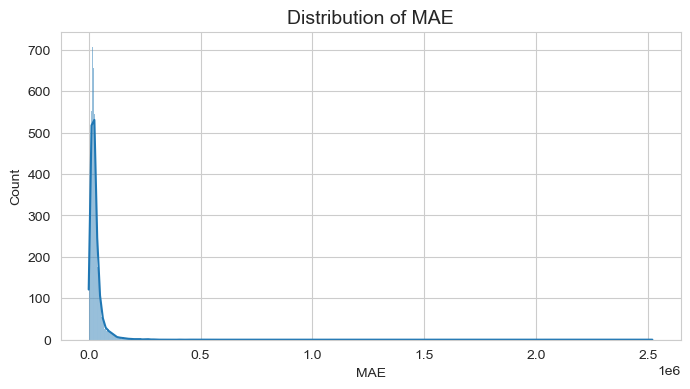

In [121]:
#exploratory data analysis: plot the distribution of MAE
sb.set_style('whitegrid')
sb.histplot(x=evaluation_results_reg['MAE'],
           kde = True)
plt.title('Distribution of MAE', fontdict = {'fontsize': 14})
plt.plot()

### Calculate the Return on Investments

In [133]:
#perform group by to get average median housing value per year
predictions_reg['Year'] = predictions_reg['ds'].str[:4]
predictions_reg = predictions_reg.fillna({'Year': 2022})
predictions_reg['Year'] = predictions_reg['Year'].apply(pd.to_numeric)
predictions_reg = predictions_reg[['RegionName','Year','y','CPI']]

#aggarate data by year to get the average housing price each year in each zip code
grouped_all_reg = predictions_reg.groupby(['RegionName','Year']).agg('mean')
grouped_all_reg = grouped_all_reg.reset_index()
print(grouped_all_reg)

# pivot table to have each year's value having their own columns
df_by_year_reg = grouped_all_reg.pivot(index='RegionName', columns='Year', values='y')
df_by_year_reg = df_by_year_reg.rename_axis("", axis="columns")
print(df_by_year_reg)

        RegionName  Year              y         CPI
0             1001  1997  129328.646616  160.516667
1             1001  1998  136825.420049  163.008333
2             1001  1999  146637.955371  166.575000
3             1001  2000  151285.548380  172.200000
4             1001  2001  158572.110212  177.066667
...            ...   ...            ...         ...
340075       99587  2018  406136.156105  251.106833
340076       99587  2019  428735.643789  255.657417
340077       99587  2020  442588.928977  258.811167
340078       99587  2021  461844.964537  270.969750
340079       99587  2022  472234.133706  160.916667

[340080 rows x 4 columns]
                     1997           1998           1999           2000  \
RegionName                                                               
1001        129328.646616  136825.420049  146637.955371  151285.548380   
1002        193579.958295  197965.923142  207588.673680  224898.770945   
1005        123304.335470  131942.379635  139609.7798

In [134]:
#Performed additional cleaning
df_by_year_reg['RegionName'] = df_by_year_reg.index
df_by_year_reg= df_by_year_reg.set_index([pd.Index(list(range(13080)))])

# create new variables for changes in average housing values between predicted year and last available year
df_by_year_reg['1Y_ROI'] = df_by_year_reg.iloc[:,-2]/df_by_year_reg.iloc[:,-3] - 1
df_by_year_reg['5Y_ROI'] = df_by_year_reg.iloc[:,-3]/df_by_year_reg.iloc[:,-8] - 1

# return the top 3 records when ranking by 1 year return
print('\nTop 3 Zip Codes With Highest 1-Year Return on Investment: ')
model2_top3_1y = df_by_year_reg.nlargest(3, '1Y_ROI', keep='last')[['RegionName','1Y_ROI']]
print(model2_top3_1y)


# return the top 3 records when ranking by 5 year return
print('\nTop 3 Zip Codes With Highest 5-Year Return on Investment: ')
model2_top3_5y = df_by_year_reg.nlargest(3, '5Y_ROI', keep='last')[['RegionName','5Y_ROI']]
print(model2_top3_5y)


Top 3 Zip Codes With Highest 1-Year Return on Investment: 
       RegionName    1Y_ROI
5667        33131  0.237180
5793        33496  0.209789
10863       81435  0.208046

Top 3 Zip Codes With Highest 5-Year Return on Investment: 
      RegionName    5Y_ROI
5079       30314  2.904829
7980       48213  2.215541
6980       42519  2.095813


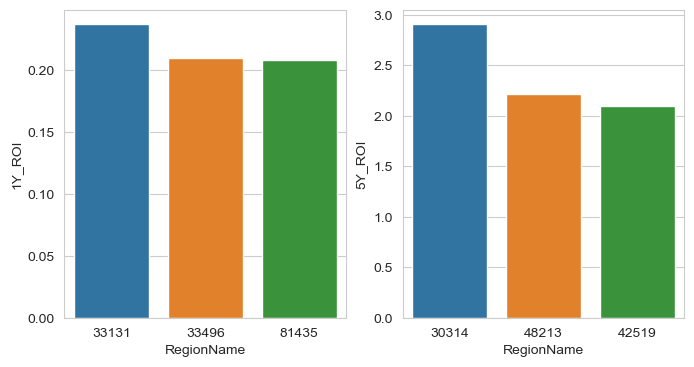

In [135]:
#Create a bar plot
fig, axs = plt.subplots(ncols=2)
sb.barplot(x="RegionName",
           y="1Y_ROI",
           data = model2_top3_1y,
          order = model2_top3_1y.sort_values('1Y_ROI',ascending = False).RegionName,
           ax=axs[0])
sb.barplot(x="RegionName",
           y="5Y_ROI",
           data = model2_top3_5y,
          order = model2_top3_5y.sort_values('5Y_ROI',ascending = False).RegionName, 
           ax=axs[1])
plt.show()

In [136]:
#create a dataframe for three zip code with highest 5-year ROI
top1_region = 33131
top2_region = 33496
top3_region = 81435

top3_results_reg = top3_df(grouped_all_reg,top1_region,top2_region,top3_region)
print(top3_results_reg)

               Top1          Top2          Top3
year                                           
1997  157766.125031  3.926583e+05  2.979172e+05
1998  167865.278279  3.927301e+05  3.456200e+05
1999  174322.533991  3.999483e+05  4.189386e+05
2000  182382.104997  4.228074e+05  4.794918e+05
2001  199752.660353  4.565464e+05  5.496642e+05
2002  231432.664098  5.015771e+05  6.056519e+05
2003  257285.916880  5.367120e+05  6.282384e+05
2004  289593.241884  5.853751e+05  6.646718e+05
2005  368466.441068  6.888621e+05  7.215286e+05
2006  456318.860714  7.806052e+05  7.567434e+05
2007  476808.781405  7.112574e+05  7.808007e+05
2008  397208.048743  6.085410e+05  8.324263e+05
2009  309595.834133  5.514996e+05  8.341995e+05
2010  286758.353658  5.467487e+05  7.924460e+05
2011  306319.631244  5.180668e+05  7.077331e+05
2012  347734.543816  5.124132e+05  6.445052e+05
2013  446655.937832  5.427399e+05  7.463167e+05
2014  548385.440044  5.814708e+05  1.069623e+06
2015  547355.848809  6.049922e+05  1.581

In [137]:
top3_records_reg = pd.DataFrame()
top3_records_reg = pd.concat([top3_records_reg,
                              record_by_region(final_df, top1_region),
                              record_by_region(final_df, top2_region),
                              record_by_region(final_df, top3_region)])
print(top3_records_reg)

      RegionName State              City  \
4251       33131    FL             Miami   
4027       33496    FL        Boca Raton   
8922       81435    CO  Mountain Village   

                                        Metro  
4251  Miami-Fort Lauderdale-Pompano Beach, FL  
4027  Miami-Fort Lauderdale-Pompano Beach, FL  
8922                                      NaN  


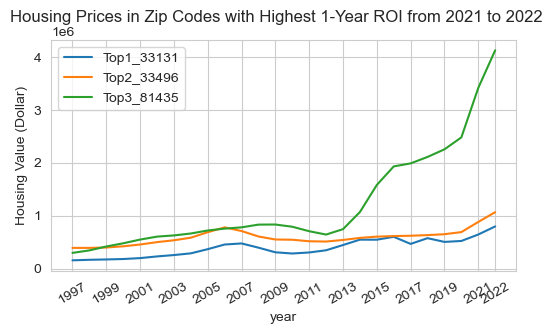

In [139]:
# Line plots of time series
top3_results_reg = top3_results_reg.rename(columns={"Top1":"Top1_33131", 
                                                    "Top2": "Top2_33496",
                                                   "Top3":"Top3_81435"})                                                    
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021,2022]
fig.suptitle('Housing Prices in Zip Codes with Highest 1-Year ROI from 2021 to 2022')
top3_results_reg.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

In [140]:
#check the MAE and RMSE values for these three areas
top3_records_reg_MAE = pd.DataFrame()
top3_records_reg_MAE = pd.concat([top3_records_reg_MAE,
                                  evaluation_results_reg[evaluation_results_reg['RegionName'] == top1_region],
                                  evaluation_results_reg[evaluation_results_reg['RegionName'] == top2_region],
                                  evaluation_results_reg[evaluation_results_reg['RegionName'] == top3_region]])
print(top3_records_reg_MAE)

  RegionName            MAE           RMSE
0      33131   39118.893324   42460.039478
0      33496  156082.066793  170177.941375
0      81435  487061.166208  533154.420424


In [141]:
#check the top records with highest 5-year return
top1_region = 30314
top2_region = 48213
top3_region = 42519

top3_results_reg2 = top3_df(grouped_all_reg,top1_region,top2_region,top3_region)
print(top3_results_reg2)

               Top1          Top2          Top3
year                                           
1997   29711.927680   4846.509502  12112.305806
1998   32702.046748   6142.174296  14684.480952
1999   37930.110770   6990.443138  19158.710281
2000   43176.746410   7549.463690  20658.087134
2001   47891.420916   8689.764617  21897.809077
2002   53867.852143   8416.691854  20042.081751
2003   61879.137477   9118.905066  18688.972031
2004   73499.742577  11367.191149  19089.403192
2005   82307.667106  12589.371914  19666.395381
2006   89429.798483  13955.207901  21472.603055
2007   83381.704651  13728.207744  19504.889102
2008   60182.638816  10725.540631  20124.886999
2009   36102.780549   7017.933599  21627.598982
2010   27511.585863   6011.207795  25199.344015
2011   22558.198306   5636.008890  31384.296865
2012   21834.590155   5442.923592  27910.898534
2013   26230.814334   6545.445810  30023.235300
2014   31117.848015   7966.430295  29136.583768
2015   33808.658190   9769.523017  35953

In [142]:
top3_records_reg2 = pd.DataFrame()
top3_records_reg2 = pd.concat([top3_records_reg2,
                               record_by_region(final_df, top1_region),
                               record_by_region(final_df, top2_region),
                               record_by_region(final_df, top3_region)])
print(top3_records_reg2)

      RegionName State      City                                 Metro
4024       30314    GA   Atlanta  Atlanta-Sandy Springs-Alpharetta, GA
4417       48213    MI   Detroit           Detroit-Warren-Dearborn, MI
9620       42519    KY  Burnside                          Somerset, KY


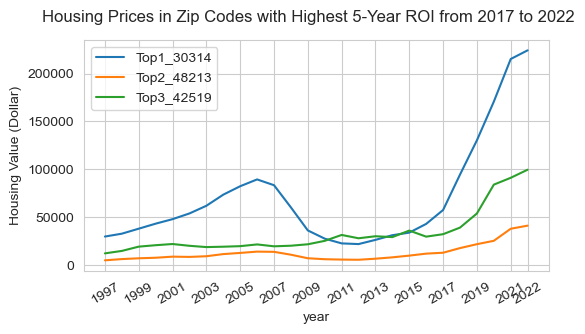

In [143]:
# Line plots of time series
top3_results_reg2 = top3_results_reg2.rename(columns={"Top1":"Top1_30314", 
                                                    "Top2": "Top2_48213",
                                                   "Top3":"Top3_42519"})     
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021,2022]
fig.suptitle('Housing Prices in Zip Codes with Highest 5-Year ROI from 2017 to 2022')
top3_results_reg2.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

### Top 3 Zip Codes Identified Using Acutal Data

In [144]:
# extract data before 2023
model_data_new = final_df[final_df['Year'] < 2023]

#perform group by to get average median housing value per year
model_data_new['Year'] = model_data_new['Year'].apply(pd.to_numeric)
model_data_new = model_data_new[['RegionName','Year','Value',]]

grouped_model_data = model_data_new.groupby(['RegionName','Year']).agg('mean')
grouped_model_data = grouped_model_data.reset_index()
print(grouped_model_data)

# pivot table to have each year's value having their own columns
df_by_year_actual = grouped_model_data.pivot(index='RegionName', columns='Year', values='Value')
df_by_year_actual = df_by_year_actual.rename_axis("", axis="columns")
print(df_by_year_actual)

        RegionName  Year          Value
0             1001  1997  129328.646616
1             1001  1998  136825.420049
2             1001  1999  146637.955371
3             1001  2000  151285.548380
4             1001  2001  158572.110212
...            ...   ...            ...
340075       99587  2018  406136.156105
340076       99587  2019  428735.643789
340077       99587  2020  442588.928977
340078       99587  2021  461844.964537
340079       99587  2022  499516.266289

[340080 rows x 3 columns]
                     1997           1998           1999           2000  \
RegionName                                                               
1001        129328.646616  136825.420049  146637.955371  151285.548380   
1002        193579.958295  197965.923142  207588.673680  224898.770945   
1005        123304.335470  131942.379635  139609.779821  153633.031635   
1007        158562.844789  165929.537456  174342.415355  185381.572093   
1008        119024.693870  124650.050146  125882.

In [145]:
#Performed additional cleaning
df_by_year_actual['RegionName'] = df_by_year_actual.index
df_by_year_actual= df_by_year_actual.set_index([pd.Index(list(range(13080)))])

# create new variables for changes in average housing values between predicted year and last available year
df_by_year_actual['1Y_ROI'] = df_by_year_actual.iloc[:,-2]/df_by_year_actual.iloc[:,-3] - 1
df_by_year_actual['5Y_ROI'] = df_by_year_actual.iloc[:,-2]/df_by_year_actual.iloc[:,-7] - 1

# return the top 3 records when ranking by 1 year return
print('\nTop 3 Zip Codes With Highest 1-Year Return on Investment: ')
actual_top3_1y = df_by_year_actual.nlargest(3, '1Y_ROI', keep='last')[['RegionName','1Y_ROI']]
print(actual_top3_1y)


# return the top 3 records when ranking by 5 year return
print('\nTop 3 Zip Codes With Highest 5-Year Return on Investment: ')
actual_top3_5y = df_by_year_actual.nlargest(3, '5Y_ROI', keep='last')[['RegionName','5Y_ROI']]
print(actual_top3_5y)


Top 3 Zip Codes With Highest 1-Year Return on Investment: 
      RegionName    1Y_ROI
5787       33480  0.468639
5676       33141  0.438664
5707       33181  0.436814

Top 3 Zip Codes With Highest 5-Year Return on Investment: 
      RegionName    5Y_ROI
7980       48213  1.733503
9912       74110  1.285244
7188       43608  1.206339


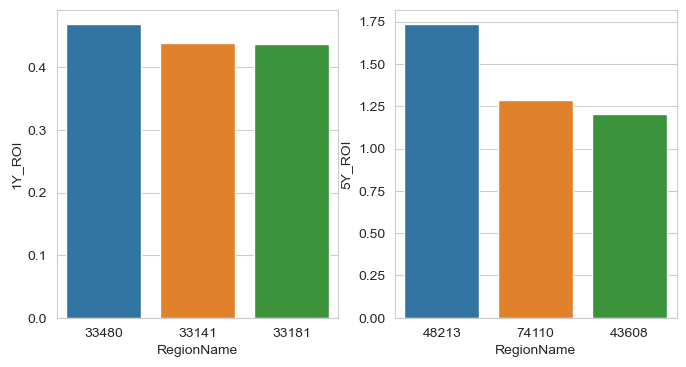

In [146]:
#Create a bar plot
fig, axs = plt.subplots(ncols=2)
sb.barplot(x="RegionName",
           y="1Y_ROI",
           data = actual_top3_1y,
          order = actual_top3_1y.sort_values('1Y_ROI',ascending = False).RegionName,
           ax=axs[0])
sb.barplot(x="RegionName",
           y="5Y_ROI",
           data = actual_top3_5y,
          order = actual_top3_5y.sort_values('5Y_ROI',ascending = False).RegionName, 
           ax=axs[1])
plt.show()

In [147]:
#create a plot for top 3 zip codes
def top3_df_actual (df, top1, top2, top3):
    # Create a dataframe to save the records for top 3 zip codes
    predictions1 = df[df['RegionName'] == top1].reset_index()
    predictions2 = df[df['RegionName'] == top2].reset_index()
    predictions3 = df[df['RegionName'] == top3].reset_index()

    year = predictions1['Year']
    Top1 = predictions1['Value']
    Top2 = predictions2['Value']
    Top3 = predictions3['Value']
    
    # Create DataFrame
    df_final = pd.DataFrame({'year': year,
                        'Top1': Top1,
                        'Top2': Top2,
                        'Top3': Top3
                       })

    df_final = df_final.set_index('year')
    return(df_final)


In [148]:
#check top three results with highest 1-year ROI
top1_region = 33480
top2_region = 33141
top3_region = 33181

top3_results_actual = top3_df_actual(grouped_model_data, top1_region,top2_region,top3_region)
print(top3_results_actual)

              Top1          Top2          Top3
year                                          
1997  1.312743e+06  1.985246e+05  1.587716e+05
1998  1.379761e+06  2.022170e+05  1.600809e+05
1999  1.557324e+06  2.136188e+05  1.706325e+05
2000  1.830341e+06  2.397339e+05  1.870202e+05
2001  2.143450e+06  2.815174e+05  2.173946e+05
2002  2.514426e+06  3.483947e+05  2.596305e+05
2003  2.870438e+06  4.197313e+05  3.106966e+05
2004  3.303964e+06  5.096416e+05  3.729269e+05
2005  3.812200e+06  6.767914e+05  4.996054e+05
2006  4.161160e+06  8.585054e+05  6.346501e+05
2007  3.978386e+06  9.125736e+05  6.559808e+05
2008  3.439973e+06  7.454825e+05  5.282968e+05
2009  3.197091e+06  5.758969e+05  3.921571e+05
2010  3.263641e+06  5.287775e+05  3.576297e+05
2011  3.167599e+06  5.033317e+05  3.309147e+05
2012  3.293579e+06  5.596155e+05  3.358584e+05
2013  3.785109e+06  6.738004e+05  4.006472e+05
2014  4.454857e+06  7.887066e+05  4.629758e+05
2015  5.206381e+06  9.105124e+05  5.422747e+05
2016  5.54939

In [149]:
top3_records = pd.DataFrame()
top3_records = pd.concat([top3_records,
                          record_by_region(final_df, top1_region),
                          record_by_region(final_df, top2_region),
                          record_by_region(final_df, top3_region)])
print(top3_records)

      RegionName State               City  \
7330       33480    FL         Palm Beach   
3437       33141    FL        Miami Beach   
5346       33181    FL  North Miami Beach   

                                        Metro  
7330  Miami-Fort Lauderdale-Pompano Beach, FL  
3437  Miami-Fort Lauderdale-Pompano Beach, FL  
5346  Miami-Fort Lauderdale-Pompano Beach, FL  


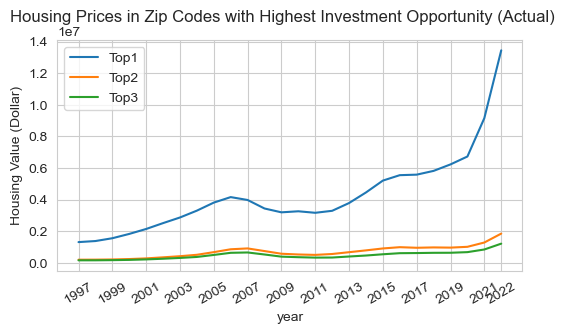

In [150]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021,2022]
fig.suptitle('Housing Prices in Zip Codes with Highest Investment Opportunity (Actual)')
top3_results_actual.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

### Create a map to visualize ROI by state (using results from the first model)

In [151]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd

In [152]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
print(contiguous_usa.head())

          state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...  
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...  


In [153]:
#read state name data
state_name = pd.read_csv('state_name.csv', sep = ',', header = 0)

print(state_name.head())
print(state_name.shape)

        State Postal
0     Alabama     AL
1      Alaska     AK
2     Arizona     AZ
3    Arkansas     AR
4  California     CA
(55, 2)


In [154]:
state_name = state_name.rename(columns={"State": "state", "Postal": "State"})
new_contiguous_usa = pd.merge(contiguous_usa, state_name, how="inner", on=["state"])
print(new_contiguous_usa.head())

          state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry State  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...    MN  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...    MT  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...    ND  
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...    ID  
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...    WA  


In [155]:
grouped_final_df = final_df.groupby(['State','RegionName','Year']).agg('mean')
grouped_final_df = grouped_final_df.reset_index()
grouped_final_df = grouped_final_df[grouped_final_df['Year'] == 2022]
print(grouped_final_df.head())

    State  RegionName  Year  SizeRank          Value
25     AK       99501  2022    7512.0  388196.594061
51     AK       99502  2022    5583.0  408621.414359
77     AK       99503  2022    8766.0  313558.777501
103    AK       99504  2022    1561.0  324109.165666
129    AK       99508  2022    1985.0  334819.050316


In [156]:
#create dataframe for the map
df_by_year_map1 = df_by_year_reg[['RegionName','1Y_ROI','5Y_ROI']]
df_by_year_map2 = pd.merge(grouped_final_df, df_by_year_map1, how="inner", on=['RegionName'])
print(df_by_year_map2.head())

df_by_year_map3 = df_by_year_map2.groupby(['State']).agg('mean')
df_by_year_map3['State'] = df_by_year_map3.index
df_by_year_map3 = df_by_year_map3.reset_index(drop = True)
new_contiguous_usa_map = pd.merge(new_contiguous_usa, df_by_year_map3, how="inner", on=['State'])
print(new_contiguous_usa_map.head())

  State  RegionName  Year  SizeRank          Value    1Y_ROI    5Y_ROI
0    AK       99501  2022    7512.0  388196.594061  0.002323  0.072706
1    AK       99502  2022    5583.0  408621.414359  0.018441  0.136855
2    AK       99503  2022    8766.0  313558.777501  0.015477  0.141497
3    AK       99504  2022    1561.0  324109.165666  0.012185  0.135252
4    AK       99508  2022    1985.0  334819.050316  0.000903  0.088436
        state adm1_code  population  \
0   Minnesota  USA-3514     5303925   
1       Idaho  USA-3518     1567582   
2  Washington  USA-3519     6724540   
3     Arizona  USA-3520     6392017   
4  California  USA-3521    37253956   

                                            geometry State    RegionName  \
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...    MN  55419.626794   
1  POLYGON ((-111.04973 44.48816, -111.05025 42.0...    ID  83462.100000   
2  POLYGON ((-116.99807 46.33017, -116.90653 46.1...    WA  98442.711610   
3  POLYGON ((-109.04523 36.99991, -

In [157]:
print(new_contiguous_usa_map.nlargest(8, '1Y_ROI', keep='last'))

        state adm1_code  population  \
23    Florida  USA-3542    18801310   
31  Tennessee  USA-3551     6346105   
3     Arizona  USA-3520     6392017   
24    Georgia  USA-3543     9687653   
1       Idaho  USA-3518     1567582   
9    Arkansas  USA-3528     2915918   
6      Nevada  USA-3523     2700551   
8        Utah  USA-3526     2763885   

                                             geometry State    RegionName  \
23  POLYGON ((-80.05654 26.88000, -80.08801 26.205...    FL  33371.394904   
31  POLYGON ((-81.67938 36.58557, -81.70477 36.460...    TN  37777.656000   
3   POLYGON ((-109.04523 36.99991, -109.04367 31.3...    AZ  85518.685484   
24  POLYGON ((-80.86501 32.03316, -81.33629 31.440...    GA  30990.185882   
1   POLYGON ((-111.04973 44.48816, -111.05025 42.0...    ID  83462.100000   
9   POLYGON ((-89.66292 36.02307, -89.67351 35.940...    AR  72346.536290   
6   POLYGON ((-114.03053 36.99410, -114.02363 36.1...    NV  89229.400000   
8   POLYGON ((-109.05318 41.0019

Text(0.5, 1.0, 'Prediction of 1-Year 2021-2022 ROI for Housing Prices in US')

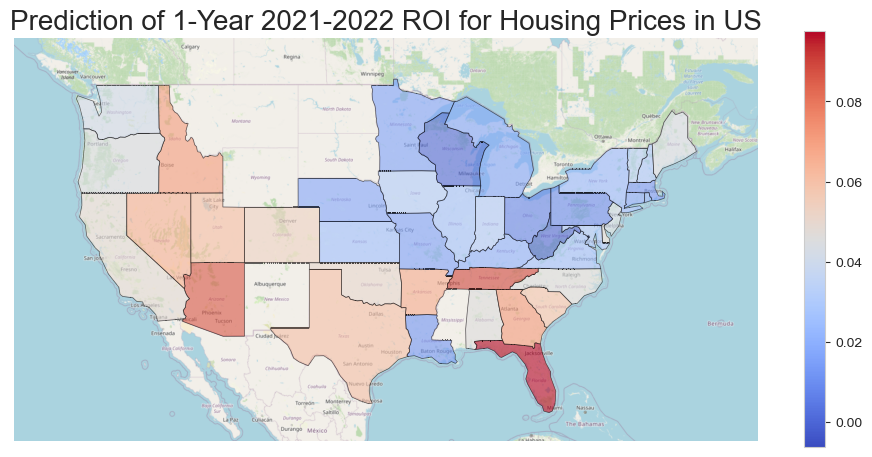

In [172]:
#Create the Map
#ax = gplt.polyplot(new_contiguous_usa_map, projection=gcrs.AlbersEqualArea())
ax = gplt.webmap(contiguous_usa, figsize=(12, 12), projection=gcrs.WebMercator())
gplt.choropleth(
    new_contiguous_usa_map,
    hue="1Y_ROI",
    edgecolor="black",
    linewidth=0.5,
    alpha = 0.6,
    cmap="coolwarm",
    legend=True,
    legend_kwargs={'orientation': 'vertical','shrink': 0.45},
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)
ax.set_title("Prediction of 1-Year 2021-2022 ROI for Housing Prices in US", fontsize=20)

Text(0.5, 1.0, 'Prediction of 5-Year 2017-2022 ROI for Housing Prices in US')

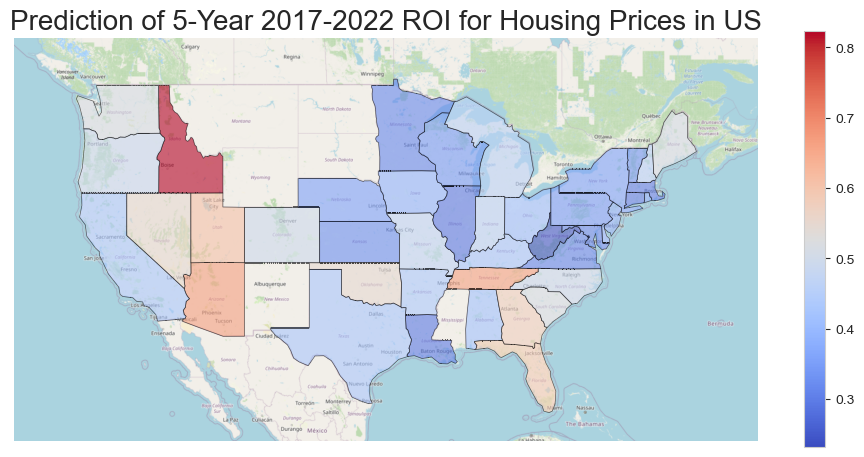

In [171]:
#Create the Map
#ax = gplt.polyplot(new_contiguous_usa_map, projection=gcrs.AlbersEqualArea())
ax = gplt.webmap(contiguous_usa, figsize=(12, 12), projection=gcrs.WebMercator())
gplt.choropleth(
    new_contiguous_usa_map,
    hue="5Y_ROI",
    edgecolor="black",
    linewidth=0.5,
    alpha = 0.6,
    cmap="coolwarm",
    legend=True,
    legend_kwargs={'orientation': 'vertical','shrink': 0.45},
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)
ax.set_title("Prediction of 5-Year 2017-2022 ROI for Housing Prices in US", fontsize=20)

Text(0.5, 1.0, 'Average 2022 Predicted Housing Prices in US')

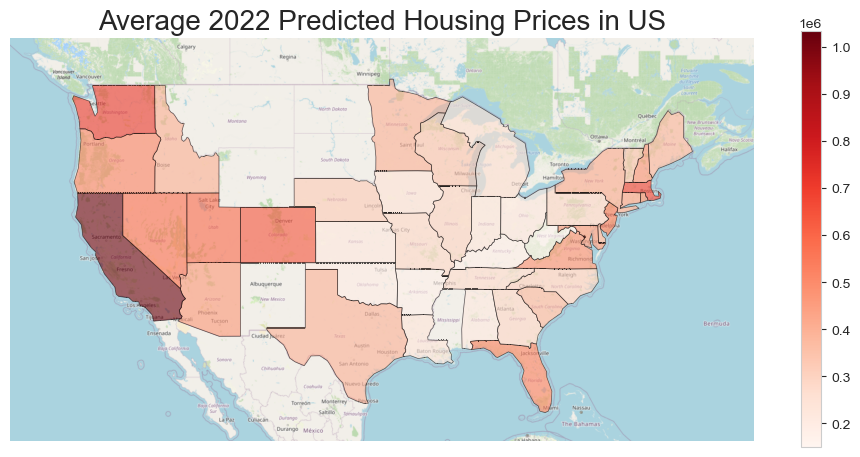

In [169]:
#Create the Map
#ax = gplt.polyplot(new_contiguous_usa_map, projection=gcrs.AlbersEqualArea())
ax = gplt.webmap(contiguous_usa, figsize=(12, 12), projection=gcrs.WebMercator())
gplt.choropleth(
    new_contiguous_usa_map,
    hue="Value",
    edgecolor="black",
    linewidth=0.5,
    alpha = 0.6,
    cmap="Reds",
    legend=True,
    legend_kwargs={'orientation': 'vertical','shrink': 0.45},
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)
ax.set_title("Average 2022 Predicted Housing Prices in US", fontsize=20)